<a href="https://colab.research.google.com/github/nielsleadholm/CNN_Binding/blob/master/BoundaryAttack_vs_MadryMethod%26BindingCNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Boundary Attack vs Madry Method and Binding-CNNs

Implement the Boundary attack method (Brendel et al, 2018) against the Madry et al (2017) method of adversarial resistance, then explore novel neural network architectures for greater adversarial resistance.


##Background/Introduction

###What are adversarial examples?

In recent years machine learning systems have significantly improved their performance on challenging tasks such as object recognition. Despite achieving near human-level performance on many of these problems, it has been realised that state-of-the-art machine learning systems such as deep neural networks are susceptible to subtle changes in the input space that would otherwise not be considered sufficient to change the true class of an item. For example, in the domain of vision, slight adjustments in pixel intensity that are imperceptible to humans can result in catastrophic misclassification by an otherwise well-performing model.

These engineered stimuli that fool the network are known as 'adversarial examples', and their generation as 'adversarial attacks'. Worryingly, adversarial examples have been found in multiple domain (such as audio and natural-language processing), function 'in the wild' (e.g. via video-feeds), and are known to generalize across machine learning systems.

###What are black box attacks, and what is the Boundary Attack?

The earliest methods for developing adversarial examples relied in detailed information about the network being attacked: specficially, how the gradient of the loss function relates to the input space. This enables calculated adjustments of the input domain so as to create an example that will be misclassified. Such methods are known as 'white box attacks' due to their intimate knowledge of the network.

Other methods enable attacks to be mounted with little information about the target, known as 'black box attacks'. A particularly powerful form of this is known as the Boundary Attack. Intuitively, the idea is to begin by adding a noise mask to the input such that it is misclassified. The L-2 (Euclidian) distance of this new image to the original is then iteratively reduced by minimizing the intensity of the pixel changes while ensuring the example remains adversarial. Eventually, a local minimum is found of an adversarial example which (ideally) is perceived to have been minimally changed to a human observer. Such an attack can in theory be implemented against networks regardless of their architecture (e.g. whether it is differentiable).

###What is the Madry et al method for adversarial resistance?

The Madry et al method is a process of training a machine learning classifier so as to be resistant to adversarial examples. To begin, an exhaustive search is performed for adversarial examples using a gradient-based attack. This search is constrained such that the l-infinite (Chebyshev) distance between the original and adversarial image is below a given threshold. A sufficiently large/complex model is then trained on both the original examples and these generated adversarial examples so as to maximize correct classification. The claim is that there is a degree of guarentee on the resistance of the network, at least within the bounds of input perturbation allowed by the earlier search method.

###What makes the following work novel or interesting?

####Part 1

My first prediction after reading about the Boundary Attack and the Madry et al method was that, as the Madry's search of adversarial examples is performed by a gradient based (white box) method, the Boundary attack might be able to find local minima that escaped this earlier search, and thus that the Madry method might be more vulnerable to l-2 (Euclidian) metric attacks than stated in the original paper. After beginning work on exploring this, I discovered that a later paper by the Boundary Attack authors had indeed confirmed this, and so the following begins with a simple replication of this result. 

####Part 2

My own research is currently focused on how the human brain encodes visual information in ways that are much richer and more complex that current deep learning systems, and how this might explain the curious existence of adversarial examples. In order to explore whether a network implementing these representations is more resistant, I first begin by developing and training a simple convolutional neural network based on the classic LeNet-5 architecture, using the MNIST hand-written characters dataset. As the steps for applying FoolBox methods such as the Boundary Attack against custom models implemented in TensorFlow's low-level API is different from pre-trained models such as ResNet-50 or the Madry network, I first demonstrate an attack against this network.

I then define and train a convolutional neural network on MNIST with a proposed change so as to confer adversarial resistance. This change results in carrying the activations of an earlier layer forward, similar to the process in 'Residual Networks' (ResNets). Unlike ResNets, this information is filtered by a boolean mask that encodes which low-level nodes are driving the high-level nodes. This relationship is similar to the 'hierarchical feature binding' that I am researching in the brain, and which may be critical to our own visual systems. This output is then rolled out and concatenated at the end to the standard 'max-pooling' output, before being fed into the latter stages of the neural network. 

Finally, I explore how this novel architecture fairs against the Boundary Attack, and compare its performance to the standard convolutional neural network, and the Madry model.

###How to Use this Notebook

The easiest way to use this Colaboratory Notebook is to run all the cells from beginning to end. 

At the beginning of the section implementing the Madry model, a code cell will run to terminate all Python operations, as this prevents variable conflict between the Madry model and the earlier ResNet model. After running this cell, all running cells will terminate, so a user must re-initiate the running of any subsequent cells. 

##Dependencies/Set-Up

In [1]:
pip install foolbox

     |████████████████████████████████| 245kB 2.8MB/s 
     |████████████████████████████████| 450kB 50.2MB/s 
     |████████████████████████████████| 71kB 31.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/d7/e7/c8/153284a6e5e5c3fd4da42a8453175b45e2e185e8b5a09ced06
Successfully built foolbox


Randomgen is necessary for the Boundary Attack

In [2]:
pip install --no-binary randomgen randomgen

     |████████████████████████████████| 706kB 2.8MB/s 
Skipping bdist_wheel for randomgen, due to binaries being disabled for it.
  Running setup.py install for randomgen ... done


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy
import datetime, os
import keras
import foolbox
from foolbox.models import KerasModel
from foolbox.criteria import TargetClassProbability
from foolbox import zoo
from keras.applications.resnet50 import ResNet50
from keras.datasets import mnist

Using TensorFlow backend.


In [4]:
cd /content/sample_data

/content/sample_data


#Part 1 - Setting Up Attacks on Pre-Trained Models

##Execute the Boundary Attack on the Madry Network (MNIST data-set)

###Load the Madry Model and Necessary Data

In [5]:
#Load the Madry et al model to be attacked
Madry_model = zoo.get_model(url="https://github.com/bethgelab/mnist_challenge")

imported module: <module 'foolbox_model' from '/root/.foolbox_zoo/c0c3849144d0e3d772010fecfe1141efd086a988bc208ed1f36fbe9d54e58298/foolbox_model.py'>


W0621 09:18:54.116577 140430577895296 deprecation_wrapper.py:119] From /root/.foolbox_zoo/c0c3849144d0e3d772010fecfe1141efd086a988bc208ed1f36fbe9d54e58298/model.py:13: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0621 09:18:54.158782 140430577895296 deprecation_wrapper.py:119] From /root/.foolbox_zoo/c0c3849144d0e3d772010fecfe1141efd086a988bc208ed1f36fbe9d54e58298/model.py:59: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0621 09:18:54.183343 140430577895296 deprecation_wrapper.py:119] From /root/.foolbox_zoo/c0c3849144d0e3d772010fecfe1141efd086a988bc208ed1f36fbe9d54e58298/model.py:73: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0621 09:18:54.227734 140430577895296 deprecation_wrapper.py:119] From /root/.foolbox_zoo/c0c3849144d0e3d772010fecfe1141efd086a988bc208ed1f36fbe9d54e58298/foolbox_model.py:18: The name tf.Session is deprecated. Please use tf.compat.v1.Session

In [6]:
#Load the full MNIST dataset
(_,_), (Madry_testing_data, Madry_testing_labels) = mnist.load_data()

Madry_testing_data = np.reshape(Madry_testing_data, (np.shape(Madry_testing_data)[0], np.shape(Madry_testing_data)[1]*np.shape(Madry_testing_data)[2]))

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
#Note the Madry model takes the images in a flattened form, rather than a 2D-reshaped input

#Separate the training and testing images and their labels
#Madry_testing_data = Madry_testing_import[:, 1:]
#Madry_testing_labels = Madry_testing_import[:, 0]

#Rescale images to values between 0:1
Madry_testing_data = Madry_testing_data/255

#Transform the labels into one-hot encoding
num_classes = 10
Madry_testing_labels = np.eye(num_classes)[Madry_testing_labels.astype(int)]

Visualize a typical example from MNIST, and the Madry model's predicted label

5


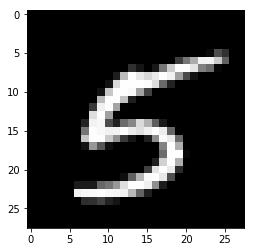

In [8]:
image_iter = 52
test_image_Madry = Madry_testing_data[image_iter, :]
plt.imshow(np.reshape(test_image_Madry, [28, 28, 1])[:,:,0], cmap='gray')
test_label_Madry = np.argmax(Madry_testing_labels[image_iter,:])

print(test_label_Madry)

In [9]:
#The predicted label of the network prior to carrying out the attack
pre_label = np.argmax(Madry_model.predictions(Madry_testing_data[image_iter, :]))
assert(pre_label == test_label_Madry)
print("The predicted label is " + str(pre_label))


The predicted label is 5


###Carry Out and Visualize the Boundary Attack

In [10]:
#Carry out the black-box attack
num_iterations = 100 #Note that the more iterations that are run, the more similar the new image will be to the original
Madry_attack = foolbox.attacks.BoundaryAttack(model=Madry_model, criterion=foolbox.criteria.Misclassification())
Madry_adversarial_image = Madry_attack(test_image_Madry, test_label_Madry, iterations=num_iterations, log_every_n_steps=50)

run with verbose=True to see details
Step 0: 1.10625e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.05561e-01, stepsizes = 1.5e-02/1.0e-02:  (took 0.04400 seconds)
Step 100: 9.74189e-02, stepsizes = 1.5e-02/4.4e-03:  (took 0.04411 seconds)


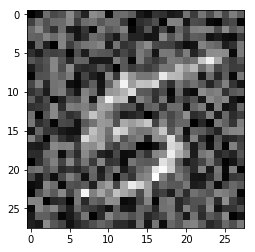

In [11]:
#Visualize the image after adversarial modification
#NB imshow can only accept values in the range of 0:255 if they are integers, hence the they are normalized to 0...1
plt.imshow(np.reshape(Madry_adversarial_image, [28, 28, 1])[:,:,0], cmap='gray')

In [12]:
#The predicted label of the network after the attack
post_label = np.argmax(Madry_model.predictions(Madry_adversarial_image))
print("The predicted label is " + str(post_label))

The predicted label is 2


###Quantify the Vulnerability of the Madry Model to the Boundary Attack

As the Boundary Attack optimizes for the L-2 norm, it is not possible to investigate it's ability to identify new local minima in L-inf norm space. On the other hand, Madry et al report a level of accuracy for l-2 norm resistance, based on PGD (gradient based) adversaries; specifically, they found that an l-2 perturbation of >5 was needed to drop the performance of classification significantly below 85%. I will explore here whether the Boundary Attack can find new local minima such that greater misclassification occurs without using a large l-2 perturbation.

In [0]:
#Function to iterate through a series of images to be attacked
def evaluate_l2_BoundaryAttack_resistance_MadryModel(num_images_to_attack, num_iterations):
    adversary_found = np.zeros([num_images_to_attack]) #array of booleans that indicates if an adversary was found for a particular image
    adversary_distance = np.zeros([num_images_to_attack])
    adversary_arrays = np.zeros([num_images_to_attack, Madry_testing_data.shape[1]])
    
    for ii in range(num_images_to_attack):
        test_image_Madry = Madry_testing_data[ii, :]
        test_label_Madry = np.argmax(Madry_testing_labels[ii,:])

        Madry_attack = foolbox.attacks.BoundaryAttack(model=Madry_model, criterion=foolbox.criteria.Misclassification())
        Madry_adversarial_image = Madry_attack(test_image_Madry, test_label_Madry, iterations=num_iterations, log_every_n_steps=500)
        adversary_arrays[ii, :] = Madry_adversarial_image
        
        # **** need to check this logical statement for accuracy
        if np.any(np.any(Madry_adversarial_image == None) | (Madry_model.predictions(Madry_adversarial_image) == test_label_Madry)):
            print("No adversarial image found")

        else:
            l2_distance = scipy.spatial.distance.euclidean(test_image_Madry, Madry_adversarial_image)
            print("The L2 distance of the adversary is " + str(l2_distance))
            adversary_found[ii] = 1
            adversary_distance[ii] = l2_distance

    return adversary_found, adversary_distance, adversary_arrays


In [14]:
num_images_to_attack = 2
num_iterations = 50
adversary_found, adversary_distance, adversary_arrays = evaluate_l2_BoundaryAttack_resistance_MadryModel(num_images_to_attack=num_images_to_attack, num_iterations=num_iterations)


run with verbose=True to see details
Step 0: 9.26512e-02, stepsizes = 1.0e-02/1.0e-02: 
The L2 distance of the adversary is 8.078735905883269
run with verbose=True to see details
Step 0: 1.34529e-01, stepsizes = 1.0e-02/1.0e-02: 
The L2 distance of the adversary is 9.382675440391623


In [0]:
np.savetxt("Madry_adversaries.csv", adversary_arrays, delimiter=',')

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
mean_distance_successful_attacks = np.sum(adversary_distance)/np.sum(adversary_found)

In [17]:
print("The success ratio is " + str(success_ratio))
print("The mean distance is " + str(mean_distance_successful_attacks))

The success ratio is 1.0
The mean distance is 8.730705673137447


My own results suggest that the boundary attack can achieve 100% misclassification of the Madry model, using a *mean* l-2 epsilon of only 1.406. In their original paper, they reported that an l-2 epislon of >5 was necessary to cause more than 15% misclassification. While my metric differed from that in the paper, and therefore direct comparisons are not possible, this suggests that the Boundary Attack method is indeed capable of finding local minima that escape gradient-based methods. Note this result was based on a sample of 50 images, allowing the BoundaryAttack to perform 1000 iterations for each.

Over the course of this work, I discovered a later pape by Schott et al (Towards the First Adversarially Robust Neural Network Model on MNIST, 2018 Arxiv) which used the same metric as in Madry et al, and found a similar result.

The earlier prediction that the Boundary Attack can identify novel local minima that gradient-based attacks cannot therefore appears confirmed.

#Part 2 - Setting Up Attacks on Custom Models, and Implementation of the Binding Network

##Execute the Boundary Attack on a Standard Convolutional Neural Network

The following demonstrates the use of the Boundary Attack Method against a standard convolutional neural network model trained on MNIST. This work helps to lay-out the steps necessary to apply FoolBox methods to a custom neural network that has been developed in TensorFlow's low-level API. Note this CNN is based on a model I previously developed in TensorFlow, and is based on the architecture of the classic network 'LeNet-5'.

###Data Setup and Preprocessing

In [0]:
#Load the full MNIST dataset
#Note the shape of the images required by the custom CNNs is 2D, rather than flattened as for the Madry model

(training_data, training_labels), (testing_data, testing_labels) = mnist.load_data()


In [0]:
#Rescale images to values between 0:1 and reshape so each image is 28x28
training_data = training_data/255
training_data = np.reshape(training_data, [np.shape(training_data)[0], 28, 28, 1])

testing_data = testing_data/255
testing_data = np.reshape(testing_data, [np.shape(testing_data)[0], 28, 28, 1])

In [0]:
#Transform the labels into one-hot encoding
num_classes = 10
training_labels = np.eye(num_classes)[training_labels.astype(int)]

testing_labels = np.eye(num_classes)[testing_labels.astype(int)]

###Model Setup

In [0]:
#Define training parameters
batch_size = 128
training_epochs = 30

In [0]:
#Define a summary variables funciton for later visualisation of the network
def var_summaries(variable):
    with tf.name_scope('Summaries'):
        mean = tf.reduce_mean(variable)
        tf.summary.scalar('Mean', mean) #The tf.summary operation determines which graph node you would like to annotate, and scalar or histogram the type of summary

        with tf.name_scope('STD'):
            std = tf.sqrt(tf.reduce_mean(tf.square(variable - mean)))
            
        tf.summary.scalar('STD', std)
        tf.summary.scalar('Max', tf.reduce_max(variable))
        tf.summary.scalar('Min', tf.reduce_min(variable))
        tf.summary.histogram('Histogram', variable)


In [0]:
#Declare placeholders for the input features and labels
#The first dimension of the palceholder shape is set to None as this will later be defined by the batch size

with tf.name_scope('Input'):
    x = tf.placeholder(training_data.dtype, [None, 28, 28, 1], name='x-input')
    y = tf.placeholder(training_labels.dtype, [None, num_classes], name='y-input')

with tf.name_scope('Drop-Out'):
    keep_prob = tf.placeholder(tf.float32)
    tf.summary.scalar('Dropout_Keep_Probability', keep_prob)

In [24]:
#Define weight and bias variables, and initialize values 
#Note for example that the first convolutional weights layer has a 5x5 filter with 1 input channel, and 6 output channels
#tf.get_variable will either get an existing variable with these parameters, or otherwise create a new one

with tf.name_scope('Weights'):
    weights_LeNet = {
        'conv_W1' : tf.get_variable('CW1', shape=(5, 5, 1, 6), initializer=tf.contrib.layers.xavier_initializer()),
        'conv_W2' : tf.get_variable('CW2', shape=(5, 5, 6, 16), initializer=tf.contrib.layers.xavier_initializer()),
        'dense_W1' : tf.get_variable('DW1', shape=(400, 120), initializer=tf.contrib.layers.xavier_initializer()),
        'dense_W2' : tf.get_variable('DW2', shape=(120, 84), initializer=tf.contrib.layers.xavier_initializer()),
        'output_W' : tf.get_variable('OW', shape=(84, num_classes), initializer=tf.contrib.layers.xavier_initializer())
    }
    
    #Add summaries for each weight variable in the dictionary, for later use in TensorBoard
    for weights_var in weights_LeNet.values():
        var_summaries(weights_var)

with tf.name_scope('Biases'):
    biases_LeNet = {
        'conv_b1' : tf.get_variable('Cb1', shape=(6), initializer=tf.contrib.layers.xavier_initializer()),
        'conv_b2' : tf.get_variable('Cb2', shape=(16), initializer=tf.contrib.layers.xavier_initializer()),
        'dense_b1' : tf.get_variable('Db1', shape=(120), initializer=tf.contrib.layers.xavier_initializer()),
        'dense_b2' : tf.get_variable('Db2', shape=(84), initializer=tf.contrib.layers.xavier_initializer()),
        'output_b' : tf.get_variable('Ob', shape=(num_classes), initializer=tf.contrib.layers.xavier_initializer())
    }

    for biases_var in biases_LeNet.values():
        var_summaries(biases_var)


W0621 09:23:23.476586 140430577895296 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
var_list_LeNet = [weights_LeNet['conv_W1'], weights_LeNet['conv_W2'], weights_LeNet['dense_W1'], weights_LeNet['dense_W2'], 
                  weights_LeNet['output_W'], biases_LeNet['conv_b1'], biases_LeNet['conv_b2'], biases_LeNet['dense_b1'],
                  biases_LeNet['dense_b2'], biases_LeNet['output_b']]

In [0]:
#Define the model

def cnn_predictions(features, temp_batch_size, keep_prob):

    #Note temp_batch_size is not currently used in this particular model, but is 
    #included as an argument to enable arbitrary calling of models later
    
    conv1 = tf.nn.conv2d(input=tf.dtypes.cast(features, dtype=tf.float32), filter=weights_LeNet['conv_W1'], 
                         strides=[1, 1, 1, 1], padding="SAME")
    conv1 = tf.nn.bias_add(conv1, biases_LeNet['conv_b1'])
    conv1_drop = tf.nn.dropout(conv1, keep_prob)
    relu1 = tf.nn.relu(conv1_drop)
    tf.summary.histogram('Relu1_activations', relu1)
    pool1 = tf.nn.max_pool(relu1, ksize=(1,2,2,1), strides=(1,2,2,1), padding="VALID")
    pool1_drop = tf.nn.dropout(pool1, keep_prob)
    #Note in the tuple defining strides for max_pool, the first entry is always 1 as this refers to the batches/indexed images,
    #rather than the dimensions of a particular image

    conv2 = tf.nn.conv2d(pool1_drop, weights_LeNet['conv_W2'], strides=[1,1,1,1], padding="VALID")
    conv2 = tf.nn.bias_add(conv2, biases_LeNet['conv_b2'])
    conv2_drop = tf.nn.dropout(conv2, keep_prob)
    relu2 = tf.nn.relu(conv2_drop)
    tf.summary.histogram('Relu2_activations', relu2)
    pool2 = tf.nn.max_pool(relu2, ksize=(1,2,2,1), strides=(1,2,2,1), padding="VALID")
    pool2_drop = tf.nn.dropout(pool2, keep_prob)
    
    #Flatten Pool 2 before connecting it (fully) with the dense layers 1 and 2
    pool2_flat = tf.reshape(pool2, [-1, 5 * 5 * 16])
    dense1 = tf.add(tf.matmul(pool2_flat, weights_LeNet['dense_W1']), biases_LeNet['dense_b1'])
    dense1_drop = tf.nn.dropout(dense1, keep_prob)
    dense1 = tf.nn.relu(dense1)
    tf.summary.histogram('Dense1_activations', dense1)
    dense2 = tf.add(tf.matmul(dense1, weights_LeNet['dense_W2']), biases_LeNet['dense_b2'])
    dense2_drop = tf.nn.dropout(dense2, keep_prob)
    dense2 = tf.nn.relu(dense2)
    tf.summary.histogram('Dense2_activations', dense2)

    logits = tf.add(tf.matmul(dense2, weights_LeNet['output_W']), biases_LeNet['output_b'])

    return logits



###Define Training

In [0]:
#Primary training function
def LeNet5_train(var_list, training_data, training_labels, testing_data, testing_labels, learning_rate, temp_batch_size, dropout_keep_prob):
    
    predictions = cnn_predictions(x, temp_batch_size, keep_prob) #NB that x was defined earlier with tf.placeholder
    
    #Define the main Tensors (left hand) and Operations (right hand) that will be used during training
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y))
    tf.summary.scalar('Softmax_cross_entropy', cost)
    
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('Accuracy', accuracy)

    #Create the chosen optimizer with tf.train.Adam..., then add it to the graph with .minimize
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    #Define values to be written with the summary method for later visualization
    loss_summary = tf.summary.scalar(name="Loss_values", tensor=cost)
    accuracy_summary = tf.summary.scalar(name="Accuracy_values", tensor=accuracy)
    
    #Create a Saver object to enable later re-loading of the learned weights
    saver = tf.train.Saver(var_list)
    
    #Merge and provide directory for saving TF summaries
    merged = tf.summary.merge_all()

    #Aside on understanding 'with' and 'tf.Session()'
        #Python's 'with' statement enables the evaluation of tf.Session, while ensuring
        #that the associated __exit__ method (similar to e.g. closing a file) will always 
        #be executed even if an error is raised
        #tf.Session() provides a connection between the Python program and the C++ runtime
        #It also caches information about the tf.Graph to enable efficient re-use of data
        #As tf.Session owns physical resources (such as the GPU), 'with' is particularly important
    with tf.Session() as sess:
        #Initialize variables; note the requirement for explicit initialization prevents expensive
        #initializers from being re-run when e.g. relaoding a model from a checkpoint
        sess.run(tf.global_variables_initializer())
        training_writer = tf.summary.FileWriter('/tmp/log', sess.graph)
        #testing_writer = tf.summary.FileWriter('LeNet/testing')
        
        #Empty arrays for storing performance measures
        train_loss = []
        test_loss = []
        train_accuracy = []
        test_accuracy = []


        for epoch in range(training_epochs):

            for batch in range(int(len(training_labels)/batch_size)):

                batch_x = training_data[batch*batch_size:min((batch+1)*batch_size, len(training_labels))]
                batch_y = training_labels[batch*batch_size:min((batch+1)*batch_size, len(training_labels))]
                
                #Recall that tf.Session.run is the main method for running a tf.Operation or evaluation a tf.Tensor
                #By passing or more Tensors or Operations, TensorFlow will execute the operations needed
                run_optim = sess.run(optimizer, feed_dict = {x: batch_x, y: batch_y, keep_prob : dropout_keep_prob})

                loss, acc = sess.run([cost, accuracy], feed_dict = {x: batch_x, y: batch_y, keep_prob : 1.0})
                

            print("At iteration " + str(epoch) + ", Loss = " + \
                 "{:.6f}".format(loss) + ", Training Accuracy = " + \
                                "{:.5f}".format(acc))

            train_acc, _ = sess.run([merged, accuracy], feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})
            training_writer.add_summary(train_acc, epoch)
            
            #test_acc, _ = sess.run([merged, accuracy], feed_dict={x: testing_data, y: testing_labels, keep_prob : 1.0})
            #testing_writer.add_summary(test_acc, epoch)
            
        print("Training complete")
        
        save_path = saver.save(sess, "/MNIST_LeNet5_CNN.ckpt")
        print("Model saved in MNIST_LeNet5_CNN.ckpt")
        
        test_acc, _ = sess.run([accuracy,cost], feed_dict={x: testing_data, y: testing_labels, keep_prob : 1.0})
        
        print("Final testing Accuracy:","{:.5f}".format(test_acc))
        
        training_writer.close()



###Train the Model

In [32]:
LeNet5_train(var_list_LeNet, training_data, training_labels, testing_data, testing_labels, learning_rate=0.001, temp_batch_size=None, dropout_keep_prob=0.5)

At iteration 0, Loss = 0.281245, Training Accuracy = 0.99219
At iteration 1, Loss = 0.158310, Training Accuracy = 1.00000
At iteration 2, Loss = 0.121041, Training Accuracy = 0.99219
At iteration 3, Loss = 0.092838, Training Accuracy = 1.00000
At iteration 4, Loss = 0.096151, Training Accuracy = 1.00000
At iteration 5, Loss = 0.070129, Training Accuracy = 1.00000
At iteration 6, Loss = 0.069162, Training Accuracy = 0.99219
At iteration 7, Loss = 0.062490, Training Accuracy = 1.00000
At iteration 8, Loss = 0.059370, Training Accuracy = 1.00000
At iteration 9, Loss = 0.061923, Training Accuracy = 1.00000
At iteration 10, Loss = 0.054522, Training Accuracy = 0.98438
At iteration 11, Loss = 0.032298, Training Accuracy = 1.00000
At iteration 12, Loss = 0.049480, Training Accuracy = 1.00000
At iteration 13, Loss = 0.044097, Training Accuracy = 1.00000
At iteration 14, Loss = 0.041941, Training Accuracy = 1.00000
At iteration 15, Loss = 0.038515, Training Accuracy = 1.00000
At iteration 16, L

###Check the Successful Loading of the Model Using tf.train.Saver()

In [0]:
def LeNet5_test(var_list_LeNet, testing_data, testing_labels, temp_batch_size):

    predictions = cnn_predictions(x, temp_batch_size, keep_prob)

    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    saver = tf.train.Saver(var_list=var_list_LeNet)
    
    with tf.Session() as sess:
        saver.restore(sess, "/MNIST_LeNet5_CNN.ckpt")
        
        test_acc = sess.run([accuracy], feed_dict={x: testing_data, y: testing_labels, keep_prob : 1.0})
        
        print("Testing Accuracy:" + str(test_acc))

In [34]:
LeNet5_test(var_list_LeNet, testing_data, testing_labels, temp_batch_size=None)

Testing Accuracy:[0.9882]


###Test the Trained Model on Random Examples

In [0]:
def LeNet5_predict(var_list_LeNet, test_image, temp_batch_size):
    
    predictions = cnn_predictions(x, temp_batch_size, keep_prob)
    
    saver = tf.train.Saver(var_list=var_list_LeNet)
    
    with tf.Session() as sess:
        saver.restore(sess, "/MNIST_LeNet5_CNN.ckpt")
        
        num_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
        print(num_parameters)
        
        output_predictions = sess.run([predictions], feed_dict={x: test_image, keep_prob : 1.0})
                
        return output_predictions

5


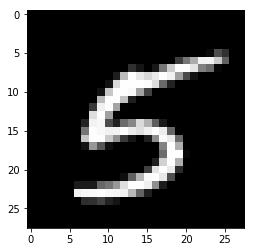

In [36]:
image_iter = 52
test_image_LeNet = testing_data[image_iter, :, :]
plt.imshow(test_image_LeNet[:,:,0], cmap='gray')
test_label_LeNet = np.argmax(testing_labels[image_iter,:])

print(test_label_LeNet)

In [37]:
output_predictions = LeNet5_predict(var_list_LeNet, test_image_LeNet[None, :, :, :], temp_batch_size=None)
print("The predicted value is " + str(np.argmax(output_predictions)))

3336340
The predicted value is 5


###Carry Out and Visualize an Attack

In [0]:
#Function used to attack an arbitrary model that has been implemented with TensorFlow's low-level API (i.e. requires a session to be called explicitly)
def Boundary_Attack_customTensorFlowModel(model_prediction_function, model_weights, var_list, num_iterations, test_image, test_label, temp_batch_size, keep_prob):

    images = x #x is a place-holder for 28x28 images earlier defined
    logits = model_prediction_function(images, temp_batch_size, keep_prob)

    saver = tf.train.Saver(var_list) #Define saver object for use later when loading the model weights

    #Note how when attacking a low-level TensorFlow API model, it is necessary for all steps to occur within the tf.Session()
    with tf.Session() as session:
        saver.restore(session, model_weights) #Note when restoring weights its important not to run init on the same
        #variables, as this will over-write the learned weights with randomly initialized ones

        #Define the foolbox model
        fmodel = foolbox.models.TensorFlowModel(images, logits, (0,1)) 

        #The predicted label of the network prior to carrying out the attack
        pre_label = np.argmax(fmodel.predictions(test_image[:, :, :]))
        #print("The classification label prior to attack is " + str(pre_label))
        if (pre_label != test_label):
            print("The model predicted a " + str(pre_label) + " when the ground-truth label is " + str(test_label))
            plt.imshow(test_image[:,:,0], cmap='gray')

        #Carry out the untargeted Bounary Attack
        attack_fmodel = foolbox.attacks.BoundaryAttack(model=fmodel, criterion=foolbox.criteria.Misclassification())
        adversarial_image_fmodel = attack_fmodel(test_image, test_label, iterations=num_iterations, log_every_n_steps=50)
        plt.imshow(adversarial_image_fmodel[:,:,0], cmap='gray')
        plt.show()
        
        #Check the output of the adversarial attack
        adversarial_label_fmodel = np.argmax(fmodel.predictions(adversarial_image_fmodel[:, :, :]))
        print("The classification label following attack is " + str(adversarial_label_fmodel) 
              + " from an original classification of " + str(test_label))
        
        return adversarial_image_fmodel, adversarial_label_fmodel

run with verbose=True to see details
Step 0: 1.00961e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 9.69891e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.04706 seconds)


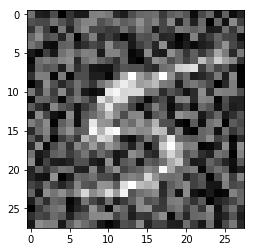

The classification label following attack is 9 from an original classification of 5


In [40]:
#An example of the attack
adversarial_image_fmodel, adversarial_label_fmodel = Boundary_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                                                 model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                                                 var_list=var_list_LeNet,
                                                                num_iterations=50, 
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=None,
                                                                keep_prob = 1.0)


In [41]:
print("The prediction following adversarial perturbation is " + str(adversarial_label_fmodel))

The prediction following adversarial perturbation is 9


###Quantify the Vulnerability of the Standard CNN Model to the Boundary Attack

In [0]:
#Iterate through a series of images to be attacked
def evaluate_l2_BoundaryAttack_resistance_CustomModel(model_prediction_function, model_weights, var_list, num_images_to_attack, num_iterations, temp_batch_size):
    adversary_found = np.zeros([num_images_to_attack]) #array of booleans that indicates if an adversary was found for a particular image
    adversary_distance = np.zeros([num_images_to_attack])
    adversary_arrays = np.zeros([num_images_to_attack, testing_data.shape[1], testing_data.shape[2], 1])

    for ii in range(num_images_to_attack):
        test_image = testing_data[ii, :, :]
        test_label = np.argmax(testing_labels[ii,:])

        adversarial_image_fmodel, adversarial_classification = Boundary_Attack_customTensorFlowModel(model_prediction_function, 
                                                                                                     model_weights, var_list,
                                                                                                     num_iterations, 
                                                                                                     test_image, test_label, 
                                                                                                     temp_batch_size,
                                                                                                    keep_prob = 1.0)
        adversary_arrays[ii, :, :] = adversarial_image_fmodel

        if ((np.any(adversarial_image_fmodel == None) | adversarial_classification == test_label)):
            print("No adversarial image found")

        else:
            l2_distance = scipy.spatial.distance.euclidean(test_image.flatten(), adversarial_image_fmodel.flatten())
            print("The L2 distance of the adversary is " + str(l2_distance))
            adversary_found[ii] = 1
            adversary_distance[ii] = l2_distance
        
    return adversary_found, adversary_distance, adversary_arrays

run with verbose=True to see details
Step 0: 1.50418e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.24710e-01, stepsizes = 1.5e-02/1.0e-02:  (took 0.03988 seconds)


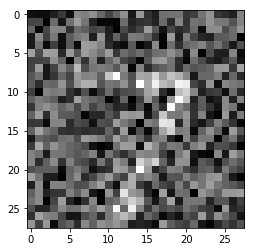

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 9.887987612568455
run with verbose=True to see details
Step 0: 6.63836e-02, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 6.55015e-02, stepsizes = 1.5e-02/6.7e-03:  (took 0.03992 seconds)


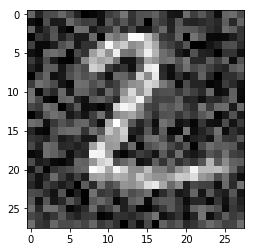

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 7.166102366831463


In [43]:
num_images_to_attack = 2
num_iterations = 50
adversary_found, adversary_distance, adversary_arrays = evaluate_l2_BoundaryAttack_resistance_CustomModel(model_prediction_function=cnn_predictions,
                                                                                       model_weights="/MNIST_LeNet5_CNN.ckpt",
                                                                                      var_list=var_list_LeNet,
                                                                                       num_images_to_attack=num_images_to_attack, 
                                                                                       num_iterations=num_iterations,
                                                                                      temp_batch_size=None)


In [0]:
np.savetxt("StandardCNN_adversaries.csv", 
           np.reshape(adversary_arrays, [adversary_arrays.shape[0], adversary_arrays.shape[1]*adversary_arrays.shape[2]]), 
                      delimiter=',')

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
mean_distance_successful_attacks = np.sum(adversary_distance)/np.sum(adversary_found)

In [46]:
print("The success ratio is " + str(success_ratio))
print("The mean distance is " + str(mean_distance_successful_attacks))

The success ratio is 1.0
The mean distance is 8.52704498969996


Assessing the simple CNN model found 100% misclassification of the Bounday Attack, using a *mean* l-2 perturbation of only 1.735; note this is actually a slightly larger distance necesary than that found when attacking the Madry model. This fits with the notion that the Madry method actually displays poor resistance to l-2 attacks from the Boundary Attack, as it has overfit on l-infinity attacks. This result is confirmed in the earlier discussed paper by Schott et al. Note this result was based on a sample of 50 images, allowing the BoundaryAttack to perform 1000 iterations for each.

##Execute the Boundary Attack on a Binding-Capable CNN

###Model Setup

The following demonstrates the use of the Boundary Attack Method against a convolutional neural network model trained on MNIST. This model has been augmented in an attempt to capture 'hierarchical binding information' - essentially how low-level features are driving high level features. Whether this confers resistance to the l-2 based Boundary Attack is then explored. Note that the model, unlike the Madry et al method, receives *no* training on adversarial examples.

In [0]:
#Define weight and bias variable dictionaries, initialize values, and add L-2 regularization 

initializer = tf.contrib.layers.xavier_initializer()
regularizer = tf.contrib.layers.l2_regularizer(scale=0.1)



weights_Binding = {
    'conv_W1_bind' : tf.get_variable('CW1_bind', shape=(5, 5, 1, 6), initializer=initializer, regularizer=regularizer),
    'conv_W2_bind' : tf.get_variable('CW2_bind', shape=(5, 5, 6, 16), initializer=initializer, regularizer=regularizer),
    'dense_W1_bind' : tf.get_variable('DW1_bind', shape=(400+1600+1176, 120), initializer=initializer, regularizer=regularizer),
    'dense_W2_bind' : tf.get_variable('DW2_bind', shape=(120, 84), initializer=initializer, regularizer=regularizer),
    'output_W_bind' : tf.get_variable('OW_bind', shape=(84, num_classes), initializer=initializer, regularizer=regularizer)
}


biases_Binding = {
    'conv_b1_bind' : tf.get_variable('Cb1_bind', shape=(6), initializer=initializer, regularizer=regularizer),
    'conv_b2_bind' : tf.get_variable('Cb2_bind', shape=(16), initializer=initializer, regularizer=regularizer),
    'dense_b1_bind' : tf.get_variable('Db1_bind', shape=(120), initializer=initializer, regularizer=regularizer),
    'dense_b2_bind' : tf.get_variable('Db2_bind', shape=(84), initializer=initializer, regularizer=regularizer),
    'output_b_bind' : tf.get_variable('Ob_bind', shape=(num_classes), initializer=initializer, regularizer=regularizer)
}


In [0]:
var_list_Binding = [weights_Binding['conv_W1_bind'], weights_Binding['conv_W2_bind'], weights_Binding['dense_W1_bind'], 
                    weights_Binding['dense_W2_bind'], weights_Binding['output_W_bind'], biases_Binding['conv_b1_bind'], 
                    biases_Binding['conv_b2_bind'], biases_Binding['dense_b1_bind'], biases_Binding['dense_b2_bind'], 
                    biases_Binding['output_b_bind']]

In [0]:
#Declare placeholders for the input features and labels
#The first dimension of the palceholder shape is set to None as this will later be defined by the batch size

x = tf.placeholder(training_data.dtype, [None, 28, 28, 1])
y = tf.placeholder(training_labels.dtype, [None, num_classes])
keep_prob = tf.placeholder(tf.float32)
# batch_size_placeholder = tf.placeholder(tf.int32, shape=())

In [0]:
#Define training parameters
batch_size = 128
training_epochs = 30

In [0]:
def max_unpool(pool, ind, prev_tensor, scope='unpool_2d'):
	"""
	Code courtecy of 'Twice22' from thread https://github.com/tensorflow/tensorflow/issues/2169
    
    Implement the unpooling operation, as explained here:
	https://stackoverflow.com/questions/36548736/tensorflow-unpooling

	Args:
		pool (tensor): Input tensor of shape (N, H, W, C)
		ind (tensor): Input tensor of shape (N, H, W, C) containing the maximum
			flatten indices (see https://www.tensorflow.org/api_docs/python/tf.nn.max_pool_with_argmax)
		prev_tensor (tensor): previous tensor shape
		scope (str): scope in which to register the operations
	Return:
		ret (tensor): tensor same shape as prev_tensor that corresponds to the "invert" of the
			max pooling operation
	"""
	with tf.variable_scope(scope):
		# input_shape = [N, H, W, C]
		input_shape = tf.shape(pool)
		o_shape = tf.shape(prev_tensor)

		output_shape = [input_shape[0], o_shape[1], o_shape[2], input_shape[3]]

		# N * H * W * C
		flat_input_size = tf.reduce_prod(input_shape)

		# flat output_shape = [N, 4 * H * W * C]
		flat_output_shape = [output_shape[0], output_shape[1] * output_shape[2] * output_shape[3]]

		updates = tf.reshape(pool, [flat_input_size])

		# create the tensor [ [[[1]]], [[[0]]], ..., [[[N-1]]] ]
		batch_range = tf.reshape(
			tf.range(tf.cast(output_shape[0], tf.int64), dtype=ind.dtype),
			shape=[input_shape[0], 1, 1, 1])

		# b is a tensor of size (N, H, W, C) whose first element of the batch are 3D-array full of 0
		# second element of the batch are 3D-array full of 1, ...   
		b = tf.ones_like(ind) * batch_range
		b = tf.reshape(b, [flat_input_size, 1])

		# indices = [ [0, ind_1], [0, ind_2], ... [0, ind_k], ..., [N-1, ind_{N*H*W*C}], [N-1, ind_{N*H*W*C-1}] ]
		indices = tf.reshape(ind, [flat_input_size, 1])
		indices = tf.concat([b, indices], axis=-1)

		ret = tf.scatter_nd(indices, updates, shape=tf.cast(flat_output_shape, tf.int64))
		ret = tf.reshape(ret, output_shape)

		set_input_shape = pool.get_shape()
		prev_tensor_shape = prev_tensor.get_shape()

		set_output_shape = [set_input_shape[0], prev_tensor_shape[1], prev_tensor_shape[2], set_input_shape[3]]
		ret.set_shape(set_output_shape)

		return ret

In [0]:
#Define the convolutional model now with binding information

def cnn_binding_predictions(features, temp_batch_size, keep_prob):

    conv1 = tf.nn.conv2d(input=tf.dtypes.cast(features, dtype=tf.float32), filter=weights_Binding['conv_W1_bind'], 
                         strides=[1, 1, 1, 1], padding="SAME")
    conv1 = tf.nn.bias_add(conv1, biases_Binding['conv_b1_bind'])
    relu1 = tf.nn.relu(conv1)
    pool1 = tf.nn.max_pool(relu1, ksize=(1,2,2,1), strides=(1,2,2,1), padding="VALID")
    #Note in the tuple defining strides for max_pool, the first entry is always 1 as this refers to the batches/indexed images,
    #rather than the dimensions of a particular image
    
    #Multiply pool1 element-wise by a tensor of 1's to simplify later gradient calculation
    pool1_identity_w = tf.ones(tf.shape(pool1))
    pool1 = tf.multiply(pool1, pool1_identity_w)
    
    #Continue standard feed-forward calculations
    conv2 = tf.nn.conv2d(pool1, weights_Binding['conv_W2_bind'], strides=[1,1,1,1], padding="VALID")
    conv2 = tf.nn.bias_add(conv2, biases_Binding['conv_b2_bind'])
    relu2 = tf.nn.relu(conv2)

    #Perform second max-pooling, and extract binding information for mid-level neurons that are driving the max-pooled (spatially invariant) representations
    invariant_pool2, invariant_binding_indeces = tf.nn.max_pool_with_argmax(relu2, ksize=(1,2,2,1), strides=(1,2,2,1), padding="VALID")
    invariant_pool2_flat = tf.reshape(invariant_pool2, [-1, 5 * 5 * 16])
    invariant_binding_activations = max_unpool(invariant_pool2, invariant_binding_indeces, relu2, scope='unpool_2d')
    invariant_binding_activations_flat = tf.reshape(invariant_binding_activations, [-1, 10 * 10 * 16])

    #Extract binding information for low-level neurons that are driving critical mid-level neurons
    #Specifically, the gradients provide the neurons in pool1 that, given the weights of conv2, contributed most to the neurons that were eventually max-pooled
    binding_grad = tf.squeeze(tf.gradients(invariant_pool2, pool1_identity_w), 0) #Squeeze removes the dimension of the gradient tensor that stores dtype
    #print("The shape of binding_grad " + str(binding_grad))
    #binding_grad.set_shape([None, 14, 14, 6])
    mask = tf.not_equal(binding_grad, 0)
    mask_float = tf.dtypes.cast(mask, dtype=tf.float32)
    #print("The shape of mask is " + str(mask))
    #mask.set_shape([1, 14, 14, 6])
    #pool1.set_shape([None, 14, 14, 6])
    #print("The shape of pool1 is " + str(pool1))
    #print("The shape of mask is " + str(mask))
    early_binding_activations = tf.multiply(pool1, mask_float)
    #print("The values of early_binding activations are " + str(early_binding_activations[0]))
    #print("The shape of early_binding_activations is " + str(early_binding_activations))
    #early_binding returns a sparse matrix with the activation levels of the early neurons that were most important, but with the values given being before transformation by subsequent weights
    early_binding_activations_flat = tf.reshape(early_binding_activations, [-1, 14 * 14 * 6])
    #print("The shape of early_binding_flat is " + str(early_binding_activations_flat))
    
    #Continue standard feed-forward calculations, but with binding information projected upwards (concatinated)
    dense1 = tf.add(tf.matmul(tf.concat([invariant_pool2_flat, invariant_binding_activations_flat, 
                                         early_binding_activations_flat], axis=1), 
                              weights_Binding['dense_W1_bind']), biases_Binding['dense_b1_bind'])
    dense1 = tf.nn.relu(dense1)
    dense2 = tf.add(tf.matmul(dense1, weights_Binding['dense_W2_bind']), biases_Binding['dense_b2_bind'])
    dense2 = tf.nn.relu(dense2)

    logits = tf.add(tf.matmul(dense2, weights_Binding['output_W_bind']), biases_Binding['output_b_bind'])

    return logits

###Define Training

In [0]:
#Define the training function of the new Binding-CNN
def BindingNet_train(var_list, training_data, training_labels, testing_data, testing_labels, learning_rate, dropout_keep_prob):
    
    predictions = cnn_binding_predictions(x, 128, keep_prob) #NB that x was defined earlier with tf.placeholder
        
    #Define the main Tensors (left hand) and Operations (right hand) that will be used during training
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predictions, labels=y))
    correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    #Create the chosen optimizer with tf.train.Adam..., then add it to the graph with .minimize
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    #Define values to be written with the summary method for later visualization
    loss_summary = tf.summary.scalar(name="Loss_values", tensor=cost)
    accuracy_summary = tf.summary.scalar(name="Accuracy_values", tensor=accuracy)
    
    saver = tf.train.Saver(var_list)
    
    #Carry out training
    with tf.Session() as sess:
        #Initialize the new variables
        sess.run(tf.global_variables_initializer())
        

        for epoch in range(training_epochs):

            for batch in range(int(len(training_labels)/batch_size)):

                batch_x = training_data[batch*batch_size:min((batch+1)*batch_size, len(training_labels))]
                batch_y = training_labels[batch*batch_size:min((batch+1)*batch_size, len(training_labels))]
                

                #Recall that tf.Session.run is the main method for running a tf.Operation or evaluation a tf.Tensor
                #By passing or more Tensors or Operations, TensorFlow will execute the operations needed
                run_optim = sess.run(optimizer, feed_dict = {x: batch_x, y: batch_y, keep_prob : dropout_keep_prob})

                loss, acc = sess.run([cost, accuracy], feed_dict = {x: batch_x, y: batch_y, keep_prob : 1.0})
                

            print("At iteration " + str(epoch) + ", Loss = " + \
                 "{:.6f}".format(loss) + ", Training Accuracy = " + \
                                "{:.5f}".format(acc))

        print("Training complete")
        
        save_path = saver.save(sess, "/Binding_CNN.ckpt")
        print("Model saved in Binding_CNN.ckpt")
        
        test_acc_list = []
        test_loss_list = []
        
        for batch in range(int(len(testing_labels)/batch_size)):

            batch_x = testing_data[batch*batch_size:min((batch+1)*batch_size, len(testing_labels))]
            batch_y = testing_labels[batch*batch_size:min((batch+1)*batch_size, len(testing_labels))]


            test_acc, test_l = sess.run([accuracy,cost], feed_dict={x: batch_x, y: batch_y, keep_prob : 1.0})

            test_acc_list.append(test_acc)
            test_loss_list.append(test_l)

        return test_acc_list, test_loss_list
        #print("Testing Accuracy:","{:.5f}".format(test_acc))



###Train the Model

In [54]:
test_acc_list, test_loss_list = BindingNet_train(var_list_Binding, training_data, training_labels, 
                                                 testing_data, testing_labels, learning_rate=0.001, dropout_keep_prob=1.0)

At iteration 0, Loss = 0.045175, Training Accuracy = 0.99219
At iteration 1, Loss = 0.015249, Training Accuracy = 1.00000
At iteration 2, Loss = 0.010496, Training Accuracy = 1.00000
At iteration 3, Loss = 0.007218, Training Accuracy = 1.00000
At iteration 4, Loss = 0.011818, Training Accuracy = 0.99219
At iteration 5, Loss = 0.011184, Training Accuracy = 1.00000
At iteration 6, Loss = 0.008147, Training Accuracy = 0.99219
At iteration 7, Loss = 0.007096, Training Accuracy = 1.00000
At iteration 8, Loss = 0.005923, Training Accuracy = 1.00000
At iteration 9, Loss = 0.009716, Training Accuracy = 1.00000
At iteration 10, Loss = 0.003133, Training Accuracy = 1.00000
At iteration 11, Loss = 0.002553, Training Accuracy = 1.00000
At iteration 12, Loss = 0.006516, Training Accuracy = 1.00000
At iteration 13, Loss = 0.006843, Training Accuracy = 1.00000
At iteration 14, Loss = 0.000279, Training Accuracy = 1.00000
At iteration 15, Loss = 0.002694, Training Accuracy = 1.00000
At iteration 16, L

In [55]:
print("Achieved an accuracy of " + str(np.mean(test_acc_list)))

Achieved an accuracy of 0.98407453


###Carry Out and Visualize an Attack

In [0]:
### *** temporary code to help count the number of parameters

def Binding_predict(var_list, test_image, temp_batch_size):
    
    predictions = cnn_binding_predictions(x, temp_batch_size, keep_prob)
    
    saver = tf.train.Saver(var_list)
    
    with tf.Session() as sess:
        saver.restore(sess, "/Binding_CNN.ckpt")
        
        num_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
        print(num_parameters)
        
        output_predictions = sess.run([predictions], feed_dict={x: test_image, keep_prob: 1.0})
                
        return output_predictions

In [57]:
Binding_predict(var_list_Binding, test_image_LeNet[None,:,:,:], temp_batch_size=1)

3731166


[array([[-16.419209 , -19.197252 , -24.46287  ,  -7.7274785, -27.371592 ,
          35.136166 , -13.504407 , -13.563036 , -12.629851 ,   2.039219 ]],
       dtype=float32)]

run with verbose=True to see details
Step 0: 2.02227e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.94258e-01, stepsizes = 1.0e-02/6.7e-03:  (took 0.05955 seconds)


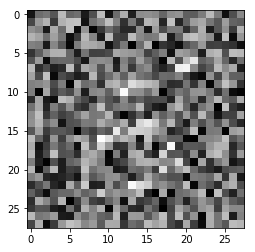

The classification label following attack is 8 from an original classification of 5


In [59]:
#An example of the attack
adversarial_image_fmodel = Boundary_Attack_customTensorFlowModel(model_prediction_function=cnn_binding_predictions,
                                                                 model_weights="/Binding_CNN.ckpt",
                                                                 var_list=var_list_Binding,
                                                                 num_iterations=50, 
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=1,
                                                                keep_prob = 1.0)


In [0]:
#Function to try to identify why the Boundary Attack does not stop iteratively decreasing noise into correct classification
# def bug_test_attack(num_iterations, test_image, test_label, target_image, target_label, temp_batch_size):

#     images = x #x is a place-holder for 28x28 images earlier defined
#     logits = cnn_binding_predictions(images, temp_batch_size)

#     saver = tf.train.Saver(var_list_Binding) #Define saver object for use later when loading the model weights

#     #Note how when attacking a low-level TensorFlow API model, it is necessary for all steps to occur within the tf.Session()
#     with tf.Session() as session:
#         saver.restore(session, "/Binding_CNN.ckpt") #Note when restoring weights its important not to run init on the same
#         #variables, as this will over-write the learned weights with randomly initialized ones

#         #Define the foolbox model
#         fmodel = foolbox.models.TensorFlowModel(images, logits, (0,1)) 

#         #The predicted label of the network prior to carrying out the attack
#         pre_label = np.argmax(fmodel.predictions(test_image[:, :, :]))
#         #print("The classification label prior to attack is " + str(pre_label))
#         if (pre_label != test_label):
#             print("The model predicted a " + str(pre_label) + " when the ground-truth label is " + str(test_label))
#             plt.imshow(test_image[:,:,0], cmap='gray')

#         #Carry out the untargeted Bounary Attack
#         attack_fmodel = foolbox.attacks.BoundaryAttack(model=fmodel, criterion=foolbox.criteria.TargetClass(target_label_LeNet))
#         adversarial_image_fmodel = attack_fmodel(test_image, test_label, iterations=num_iterations, starting_point=target_image_LeNet,
#                                                  log_every_n_steps=50)
#         plt.imshow(adversarial_image_fmodel[:,:,0], cmap='gray')
#         plt.show()
        
#         #Check the output of the adversarial attack
#         adversarial_label_fmodel = np.argmax(fmodel.predictions(adversarial_image_fmodel[:, :, :]))
#         print("The classification label following attack is " + str(adversarial_label_fmodel) 
#               + " from an original classification of " + str(test_label))
        
#         return adversarial_image_fmodel, adversarial_label_fmodel

In [0]:
#To be used if a targeted attack is desired

#Unfortunately the targeted boundary attack appears to have the same odd behaviour

# image_iter = 56
# target_image_LeNet = testing_data[image_iter, :, :]
# plt.imshow(target_image_LeNet[:,:,0], cmap='gray')
# target_label_LeNet = np.argmax(testing_labels[image_iter,:])

# print(target_label_LeNet)

In [0]:
# #An example of the attack
# adversarial_image_fmodel = bug_test_attack(num_iterations=100, 
#                                                                  test_image=test_image_LeNet, 
#                                                                  test_label=test_label_LeNet,
#                                                                 target_image=target_image_LeNet,
#                                                                 target_label=target_label_LeNet,
#                                                                  temp_batch_size=1)


###Quantify the Vulnerability of the Binding-Capable CNN to the Boundary Attack

run with verbose=True to see details
Step 0: 1.11077e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 1.02503e-01, stepsizes = 1.0e-02/6.7e-03:  (took 0.06010 seconds)


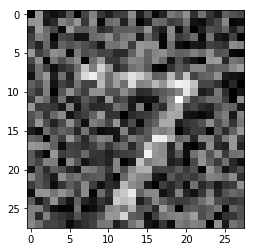

The classification label following attack is 5 from an original classification of 7
The L2 distance of the adversary is 8.96448731202363
run with verbose=True to see details
Step 0: 2.17210e-01, stepsizes = 1.0e-02/1.0e-02: 
Step 50: 2.08651e-01, stepsizes = 6.7e-03/6.7e-03:  (took 0.05414 seconds)


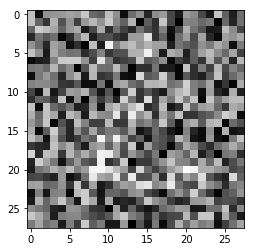

The classification label following attack is 5 from an original classification of 2
The L2 distance of the adversary is 12.789915169479851


In [60]:
num_images_to_attack = 2
num_iterations = 50
adversary_found, adversary_distance, adversary_arrays = evaluate_l2_BoundaryAttack_resistance_CustomModel(model_prediction_function=cnn_binding_predictions,
                                                                                        model_weights="/Binding_CNN.ckpt", 
                                                                                      var_list=var_list_Binding,
                                                                                        num_images_to_attack=num_images_to_attack,
                                                                                        num_iterations=num_iterations, temp_batch_size=1)
#Note that as the Boundary Attack appears to display unusual behaviour against this network, each adversarial image is also shown

In [0]:
np.savetxt("BindingNetwork_adversaries.csv", 
           np.reshape(adversary_arrays, [adversary_arrays.shape[0], adversary_arrays.shape[1]*adversary_arrays.shape[2]]), 
                      delimiter=',')

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
mean_distance_successful_attacks = np.sum(adversary_distance)/np.sum(adversary_found)

In [63]:
print("The success ratio is " + str(success_ratio))
print("The mean distance is " + str(mean_distance_successful_attacks))

The success ratio is 1.0
The mean distance is 10.877201240751742


In [64]:
!find -type f | grep -P '\.csv' | tar cvzf Generated_adversaries.gz -T -

./Madry_adversaries.csv
./StandardCNN_adversaries.csv
./BindingNetwork_adversaries.csv
./california_housing_train.csv
./mnist_test.csv
./california_housing_test.csv
./mnist_train_small.csv


In [0]:
from google.colab import files
files.download('Generated_adversaries.gz') 

On running the above, the Binding-network appears to only misclassify 24% of the examples generated, and of these, the mean L-2 distance required to cause misclassification is 8.32. This is much better performance than for the other networks, but on inspecting the running of the code, the Boundary Attack appears to be performing oddly together with the network, in that after identifying an adversarial example (i.e. with 100% success, as for the other models), it continues to iteratively decrease the noise over the 1000 iteraitons. After this reduction in noise, the network is generally able to classify the example; thus the issue appears to be that the Boundary Attack is not remaining in what the 'region of adversity'. It is likely this is due to a bug in my own execution of the attack, and so an alternative measure of adversarial resistance is explored below.

#Part 3 - Direct Comparison of Each Network's Performance

##Transfer Attacks

As it is unclear from the above results whether the Binding CNN is genuinely more resistant to adversarial attacks, or there is simply an issue with how the Boundary Attack is being leveraged against it, an additional measure will be performed. The following assesses how resistant each network is to the adversarial examples generated by the other networks; such an attack is in fact a form of a blac box attack know as a 'transfer attack'. Generally speaking, adversarial examples generalize well across models, and so any indication that a model is resistant to the adversarial examples of other is a positive sign that it is genuinely resistant. As this assessment does not make use of FoolBox, any possible issues with the implementation of the Boundary Attack against the binding network should not confer non-genuine resistance to the transfer attacks.

###Transfer Attacks Against the Keras Models

In [0]:
def Transfer_Attack_KerasModel(model, transfer_attack_images):
    
    #Load transfer_attack_images and reshape
    transfer_images = np.genfromtxt(transfer_attack_images, delimiter=',')
    

    
    for ii in range(transfer_images.shape[0]):
        test_image = transfer_images[ii, :]
                
        plt.imshow(np.reshape(test_image, [28, 28, 1])[:,:,0], cmap='gray')
        plt.show()
        print("The network predicted a class label of " + str(np.argmax(model.predictions(test_image))))
        


####Madry Model vs Standard CNN Adversaries

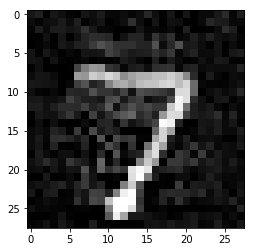

The network predicted a class label of 7


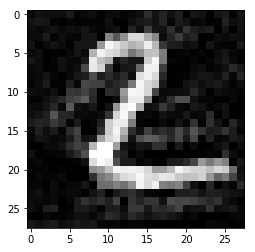

The network predicted a class label of 2


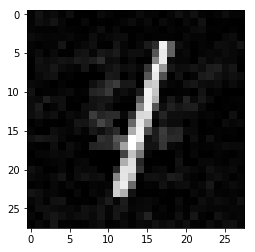

The network predicted a class label of 1


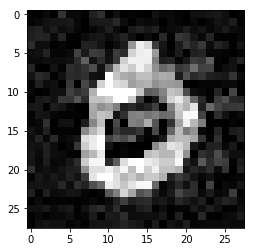

The network predicted a class label of 0


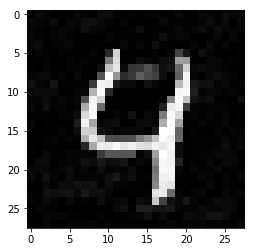

The network predicted a class label of 4


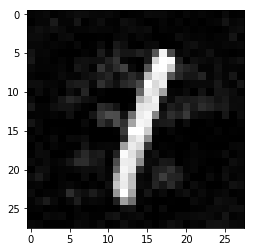

The network predicted a class label of 1


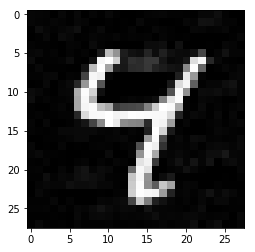

The network predicted a class label of 4


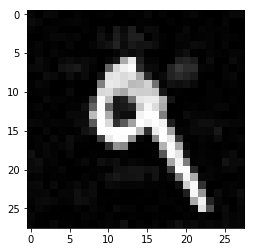

The network predicted a class label of 9


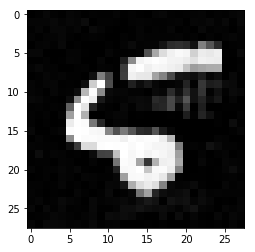

The network predicted a class label of 5


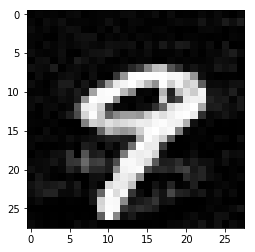

The network predicted a class label of 9


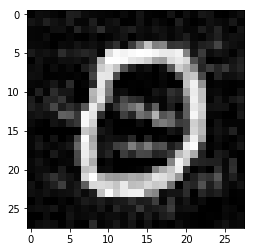

The network predicted a class label of 0


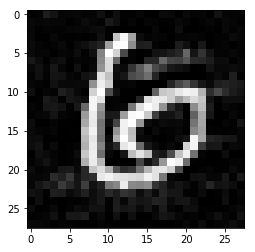

The network predicted a class label of 6


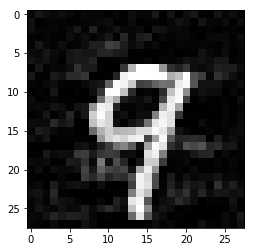

The network predicted a class label of 9


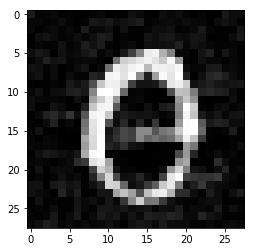

The network predicted a class label of 0


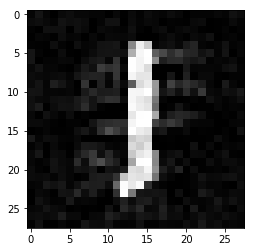

The network predicted a class label of 1


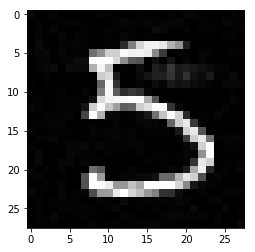

The network predicted a class label of 5


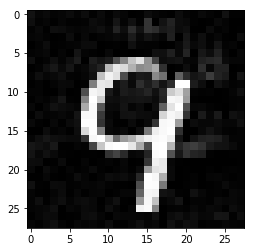

The network predicted a class label of 9


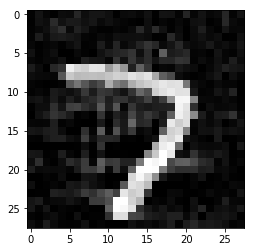

The network predicted a class label of 7


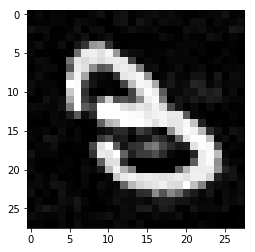

The network predicted a class label of 3


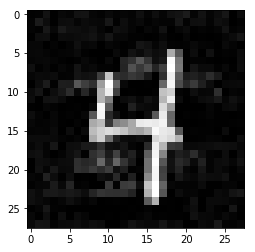

The network predicted a class label of 4


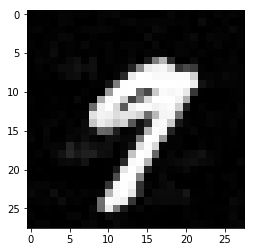

The network predicted a class label of 9


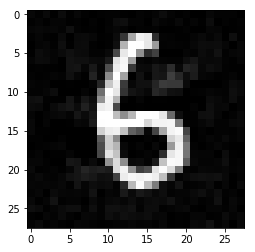

The network predicted a class label of 6


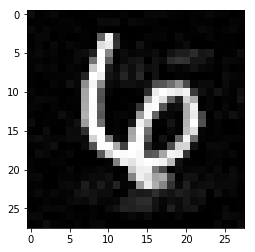

The network predicted a class label of 6


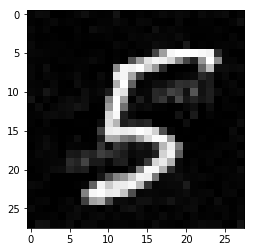

The network predicted a class label of 5


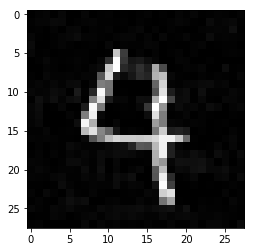

The network predicted a class label of 4


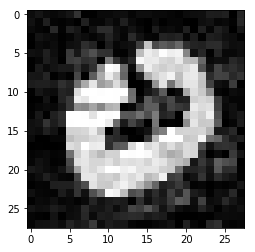

The network predicted a class label of 0


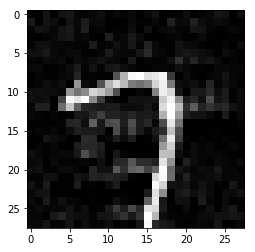

The network predicted a class label of 7


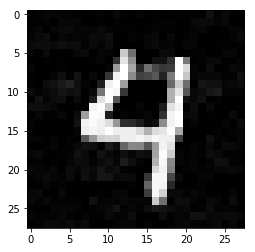

The network predicted a class label of 4


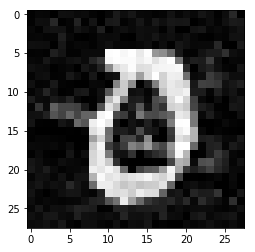

The network predicted a class label of 0


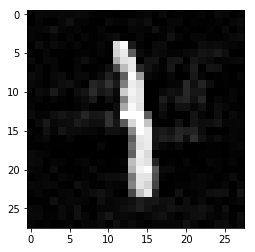

The network predicted a class label of 1


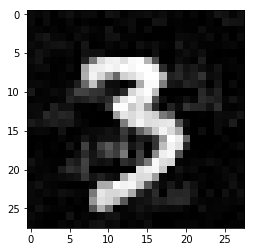

The network predicted a class label of 3


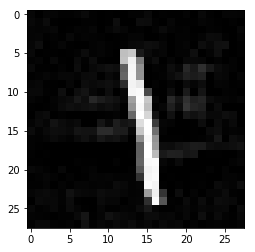

The network predicted a class label of 1


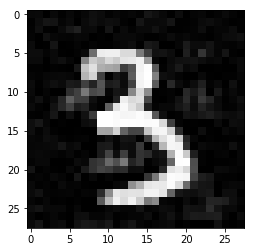

The network predicted a class label of 3


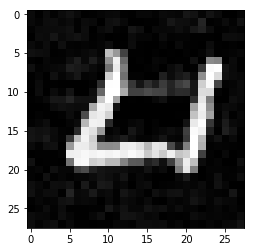

The network predicted a class label of 4


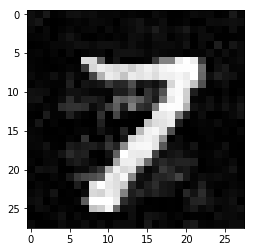

The network predicted a class label of 7


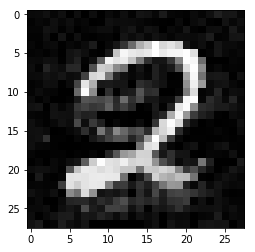

The network predicted a class label of 2


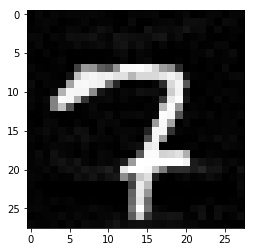

The network predicted a class label of 7


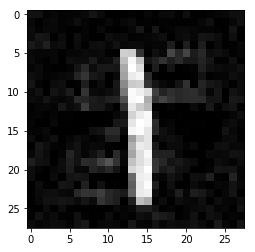

The network predicted a class label of 1


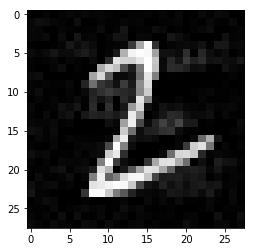

The network predicted a class label of 2


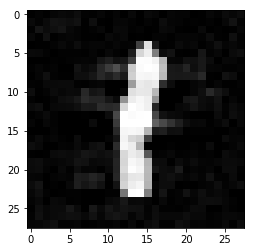

The network predicted a class label of 1


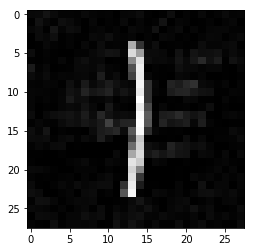

The network predicted a class label of 1


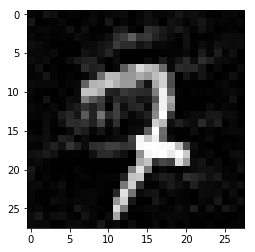

The network predicted a class label of 7


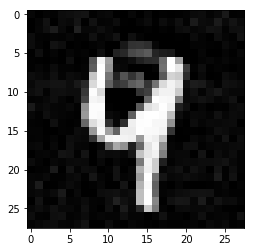

The network predicted a class label of 4


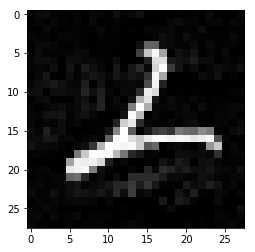

The network predicted a class label of 2


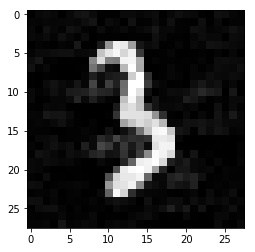

The network predicted a class label of 3


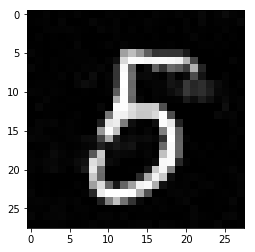

The network predicted a class label of 5


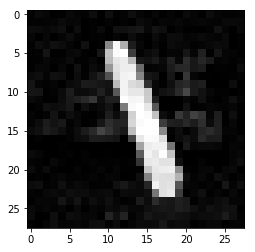

The network predicted a class label of 1


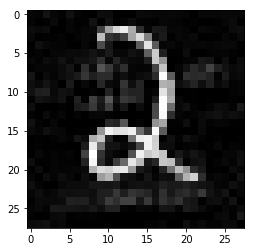

The network predicted a class label of 2


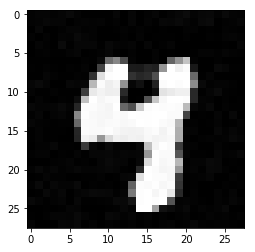

The network predicted a class label of 4


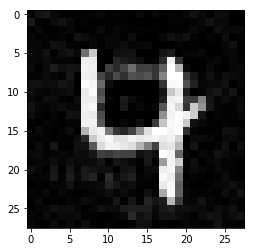

The network predicted a class label of 4


In [0]:
Transfer_Attack_KerasModel(model=Madry_model, transfer_attack_images="StandardCNN_adversaries.csv")

The Madry network performs well against standard CNN adversaries, getting 10/10.

####Madry Model vs Binding CNN Adversaries

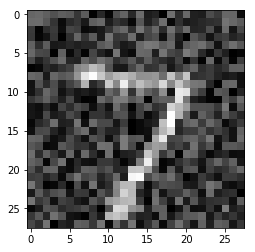

The network predicted a class label of 7


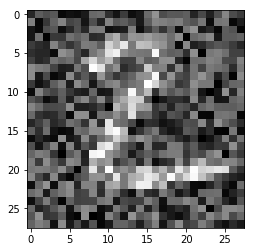

The network predicted a class label of 2


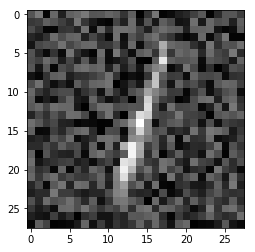

The network predicted a class label of 1


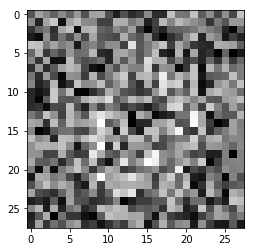

The network predicted a class label of 0


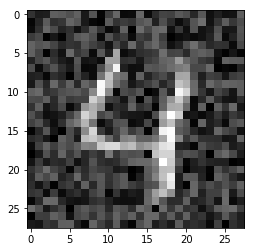

The network predicted a class label of 4


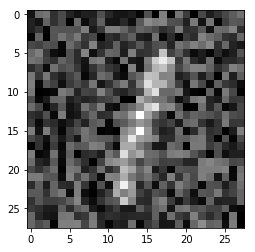

The network predicted a class label of 2


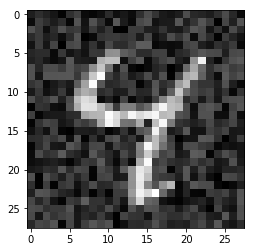

The network predicted a class label of 4


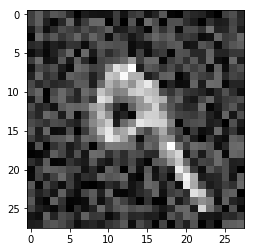

The network predicted a class label of 9


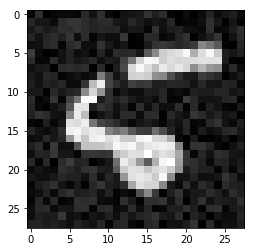

The network predicted a class label of 5


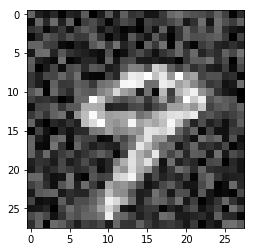

The network predicted a class label of 9


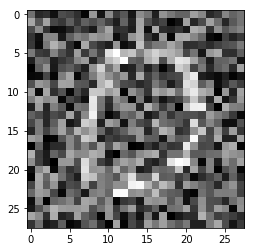

The network predicted a class label of 0


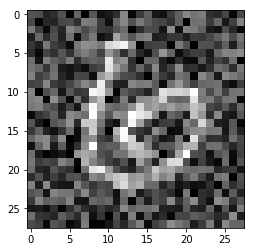

The network predicted a class label of 0


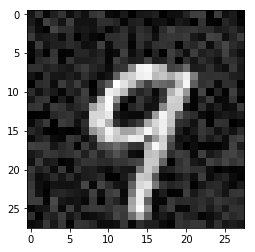

The network predicted a class label of 9


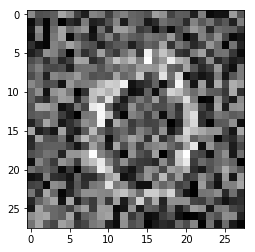

The network predicted a class label of 0


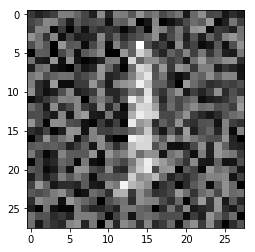

The network predicted a class label of 0


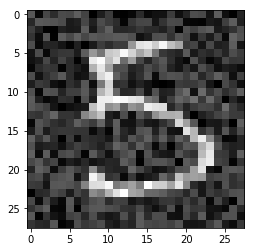

The network predicted a class label of 5


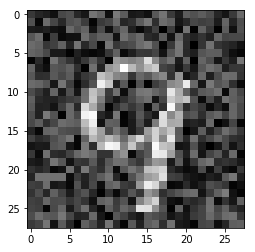

The network predicted a class label of 9


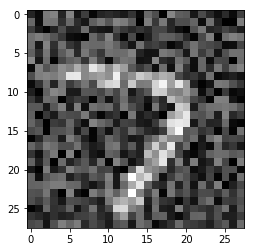

The network predicted a class label of 0


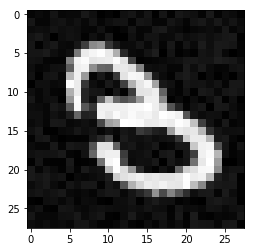

The network predicted a class label of 3


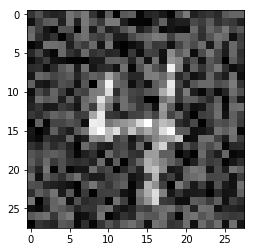

The network predicted a class label of 4


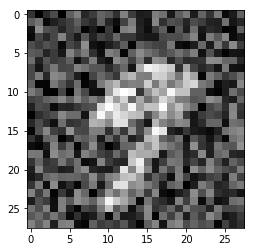

The network predicted a class label of 2


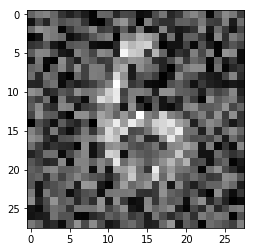

The network predicted a class label of 8


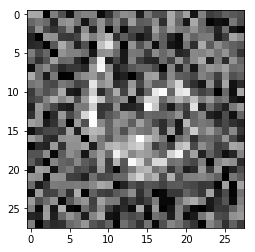

The network predicted a class label of 0


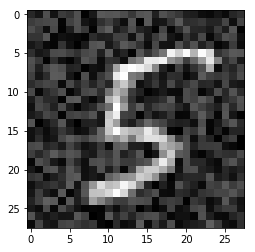

The network predicted a class label of 5


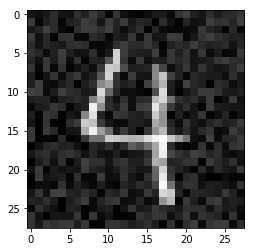

The network predicted a class label of 4


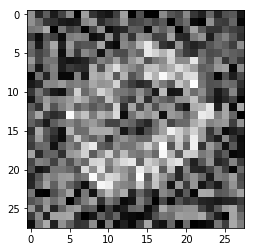

The network predicted a class label of 0


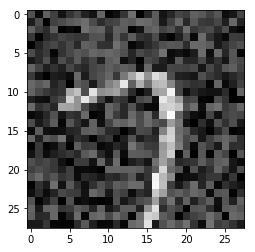

The network predicted a class label of 7


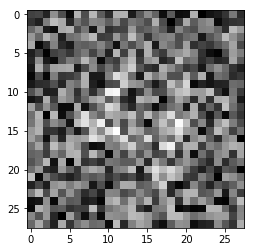

The network predicted a class label of 0


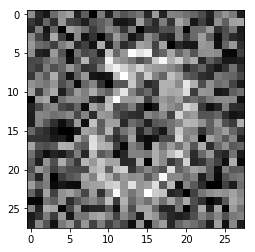

The network predicted a class label of 0


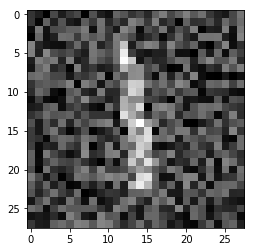

The network predicted a class label of 8


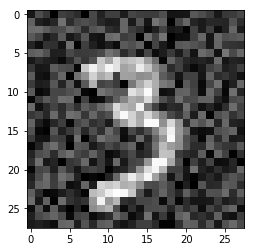

The network predicted a class label of 3


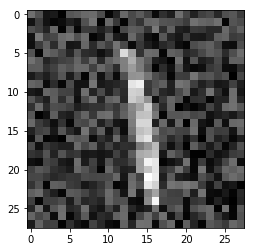

The network predicted a class label of 1


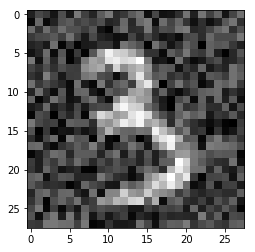

The network predicted a class label of 3


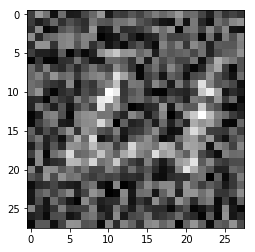

The network predicted a class label of 0


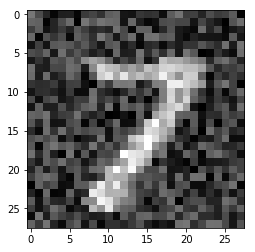

The network predicted a class label of 2


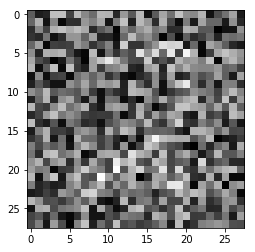

The network predicted a class label of 0


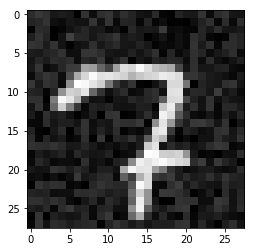

The network predicted a class label of 7


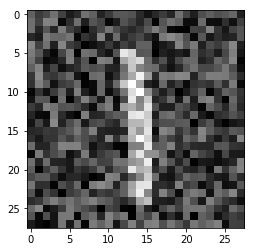

The network predicted a class label of 1


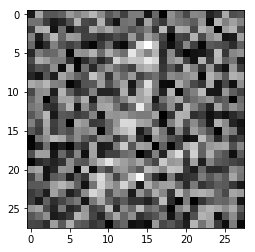

The network predicted a class label of 0


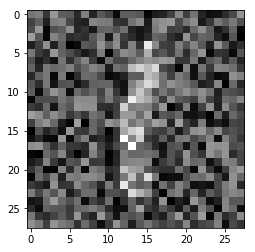

The network predicted a class label of 0


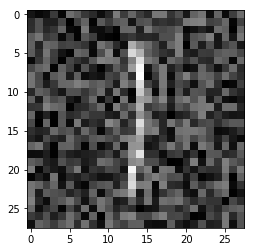

The network predicted a class label of 1


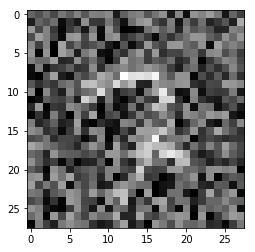

The network predicted a class label of 0


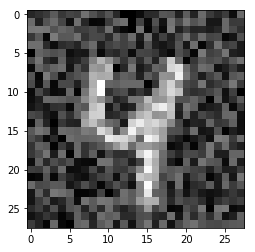

The network predicted a class label of 9


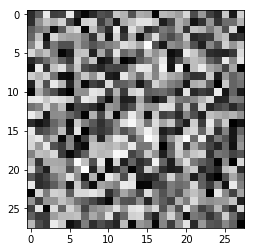

The network predicted a class label of 0


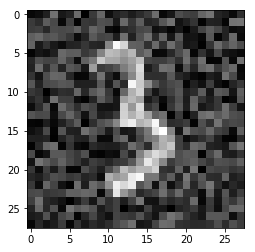

The network predicted a class label of 3


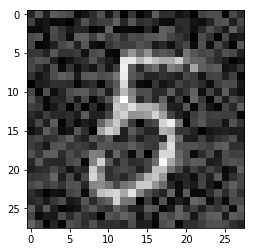

The network predicted a class label of 5


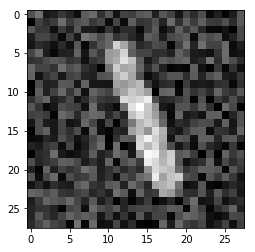

The network predicted a class label of 1


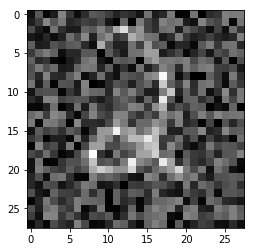

The network predicted a class label of 2


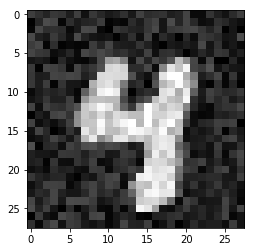

The network predicted a class label of 4


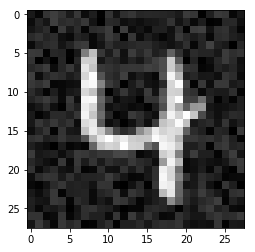

The network predicted a class label of 4


In [0]:
Transfer_Attack_KerasModel(model=Madry_model, transfer_attack_images="BindingNetwork_adversaries.csv")

The Madry network does reasonably well against the Binding-CNN adversaries, scoring 7/10. Note this may be more appropriately measured as 5/8, given that the '0' above is essentially uninformative to a human, and that the second-to-last example of a 5 is also arguably of poor ground-truth.

####Madry Model vs Its Own Adversaries

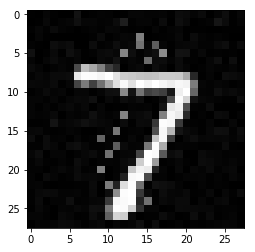

The network predicted a class label of 0


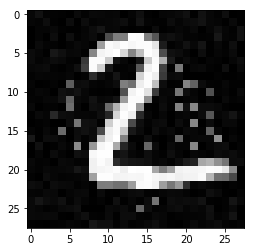

The network predicted a class label of 0


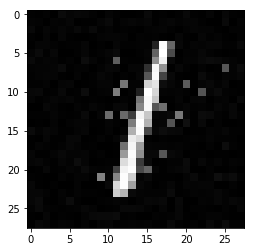

The network predicted a class label of 8


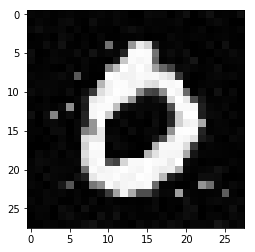

The network predicted a class label of 0


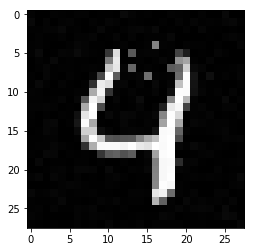

The network predicted a class label of 4


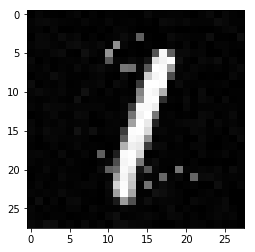

The network predicted a class label of 2


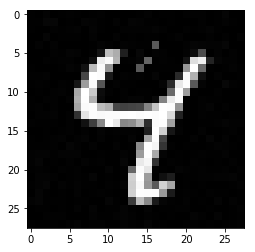

The network predicted a class label of 8


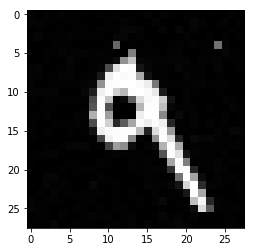

The network predicted a class label of 4


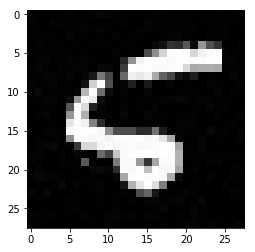

The network predicted a class label of 6


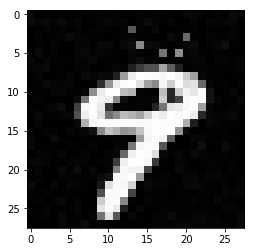

The network predicted a class label of 4


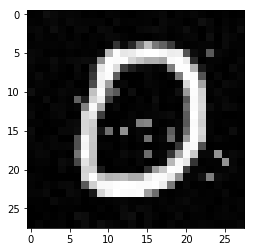

The network predicted a class label of 2


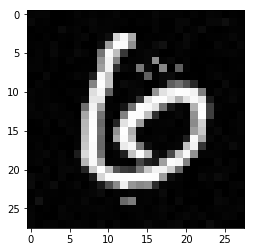

The network predicted a class label of 0


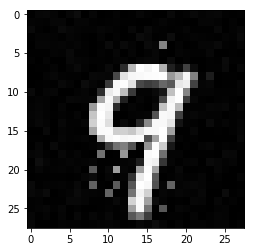

The network predicted a class label of 8


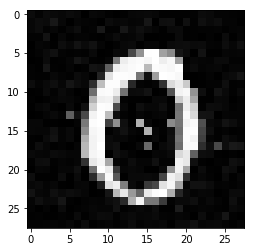

The network predicted a class label of 8


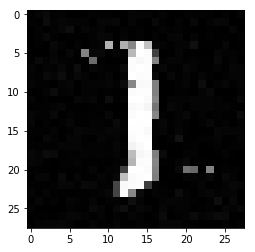

The network predicted a class label of 2


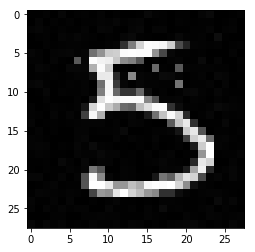

The network predicted a class label of 3


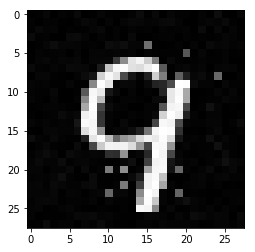

The network predicted a class label of 9


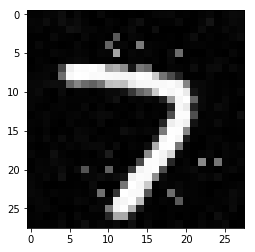

The network predicted a class label of 2


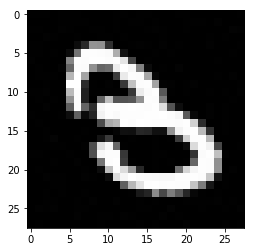

The network predicted a class label of 8


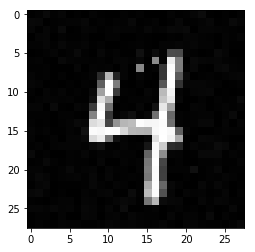

The network predicted a class label of 9


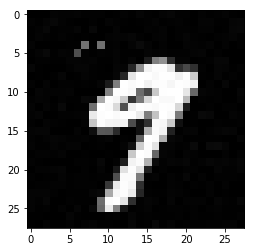

The network predicted a class label of 7


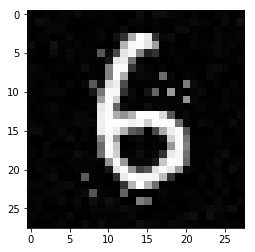

The network predicted a class label of 8


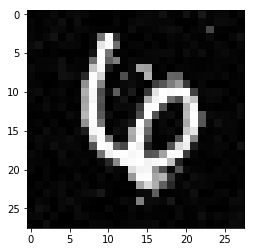

The network predicted a class label of 0


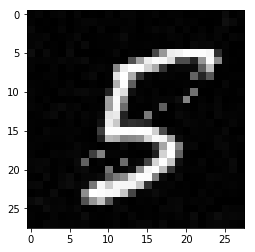

The network predicted a class label of 8


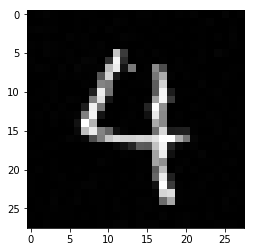

The network predicted a class label of 9


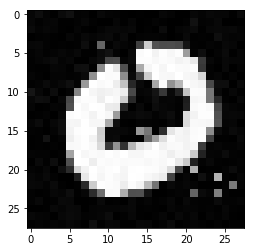

The network predicted a class label of 2


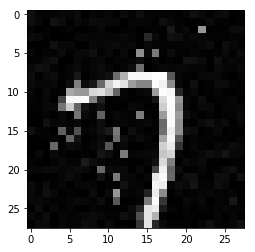

The network predicted a class label of 0


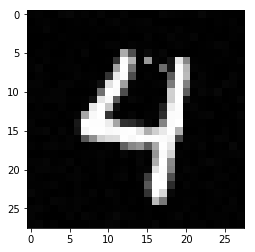

The network predicted a class label of 9


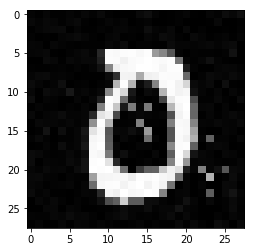

The network predicted a class label of 2


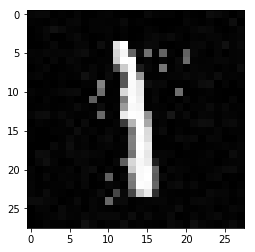

The network predicted a class label of 8


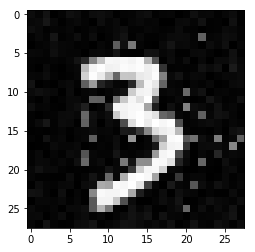

The network predicted a class label of 2


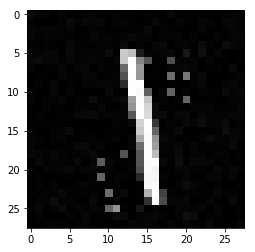

The network predicted a class label of 8


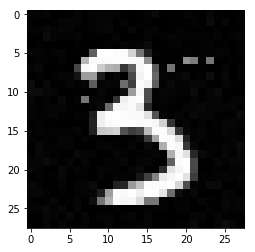

The network predicted a class label of 5


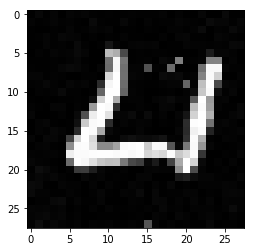

The network predicted a class label of 0


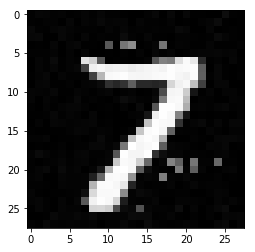

The network predicted a class label of 2


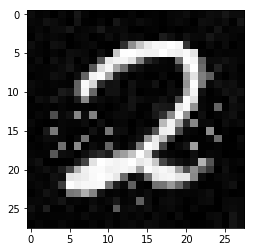

The network predicted a class label of 0


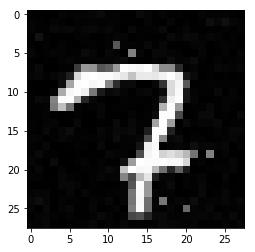

The network predicted a class label of 2


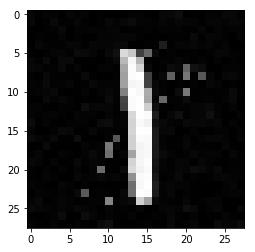

The network predicted a class label of 8


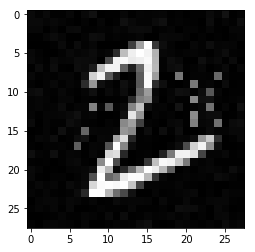

The network predicted a class label of 0


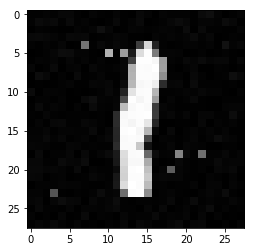

The network predicted a class label of 2


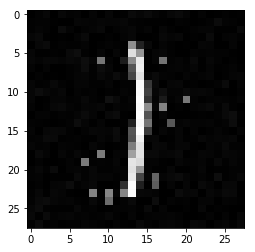

The network predicted a class label of 8


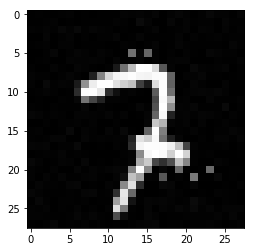

The network predicted a class label of 7


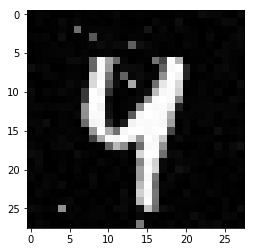

The network predicted a class label of 9


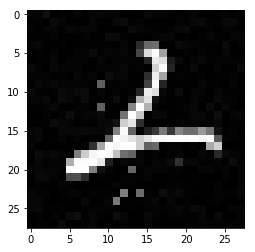

The network predicted a class label of 4


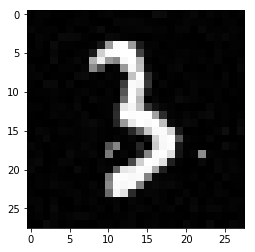

The network predicted a class label of 2


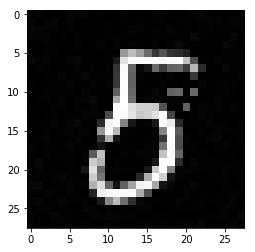

The network predicted a class label of 8


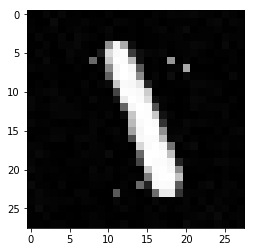

The network predicted a class label of 8


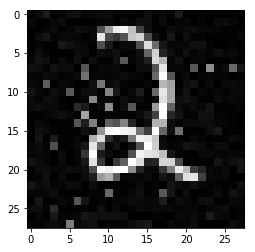

The network predicted a class label of 4


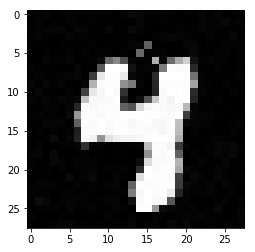

The network predicted a class label of 9


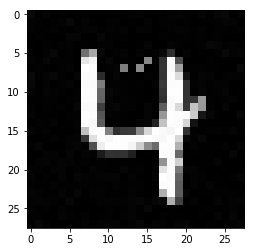

The network predicted a class label of 9


In [0]:
#Double check the adversaries work against the model they were developed for
Transfer_Attack_KerasModel(model=Madry_model, transfer_attack_images="Madry_adversaries.csv")

As expected, the Madry network scores 0/10 against its own adversaries.

###Transfer Attacks Against the TensorFlow Models

In [0]:
def Transfer_Attack_prediction_customTensorFlowModel(model_prediction_function, model_weights, var_list, test_image, temp_batch_size):
    
    predictions = model_prediction_function(x, temp_batch_size, keep_prob)
    
    saver = tf.train.Saver(var_list)
    
    with tf.Session() as sess:
        saver.restore(sess, model_weights)
        
        output_predictions = sess.run([predictions], feed_dict={x: test_image, keep_prob: 1.0})
                
        return output_predictions

In [0]:
def Transfer_Attack_customTensorFlowModel(model_prediction_function, model_weights, var_list, transfer_attack_images, temp_batch_size):
    
    #Load transfer_attack_images and reshape
    transfer_images = np.genfromtxt(transfer_attack_images, delimiter=',')
    
    
    transfer_images = np.reshape(transfer_images, [transfer_images.shape[0], 28, 28, 1])

    
    for ii in range(transfer_images.shape[0]):
        test_image = transfer_images[ii, :, :, :]
        
        output_predictions = Transfer_Attack_prediction_customTensorFlowModel(model_prediction_function, model_weights, var_list, 
                                                                              test_image[None, :, :, :], temp_batch_size)
        
        plt.imshow(test_image[:,:,0], cmap='gray')
        plt.show()
        print("The network predicted a class label of " + str(np.argmax(output_predictions)))

####Standard CNN vs Madry Adversaries

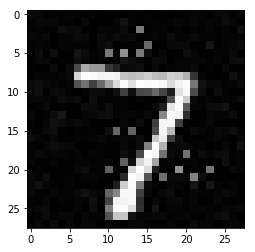

The network predicted a class label of 7


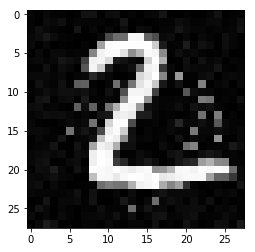

The network predicted a class label of 2


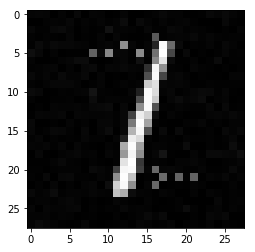

The network predicted a class label of 1


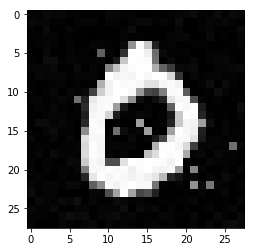

The network predicted a class label of 0


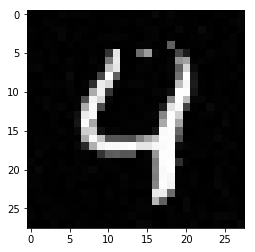

The network predicted a class label of 4


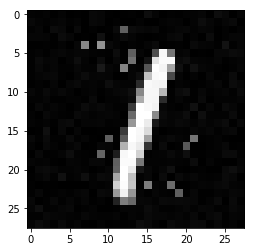

The network predicted a class label of 1


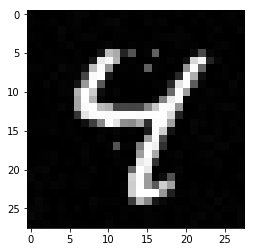

The network predicted a class label of 4


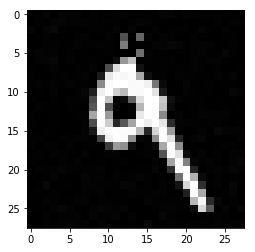

The network predicted a class label of 9


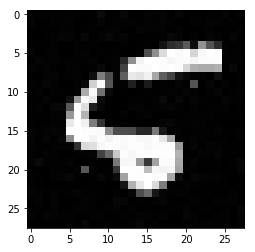

The network predicted a class label of 5


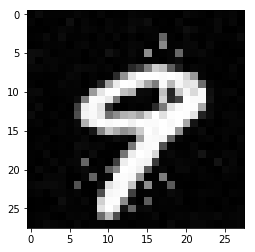

The network predicted a class label of 9


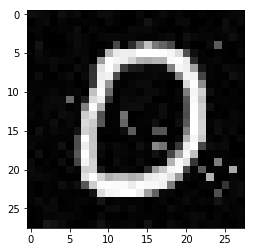

The network predicted a class label of 0


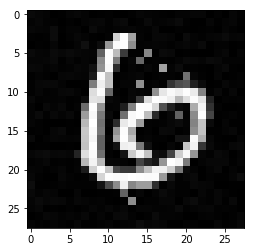

The network predicted a class label of 6


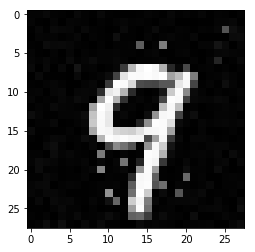

The network predicted a class label of 9


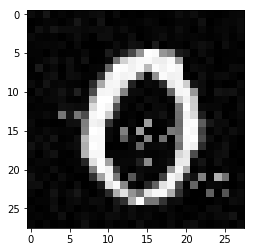

The network predicted a class label of 0


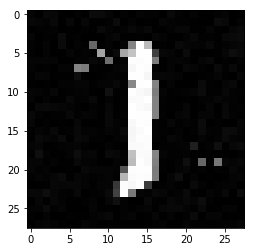

The network predicted a class label of 1


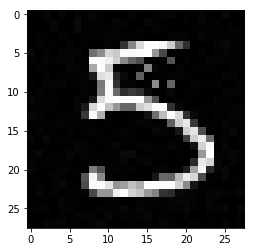

The network predicted a class label of 5


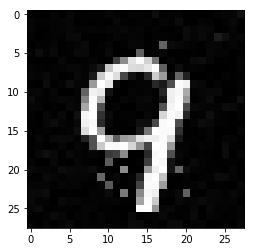

The network predicted a class label of 9


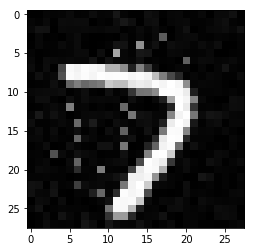

The network predicted a class label of 7


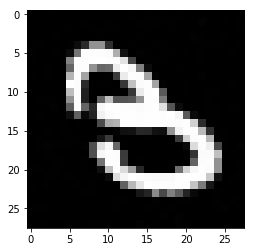

The network predicted a class label of 3


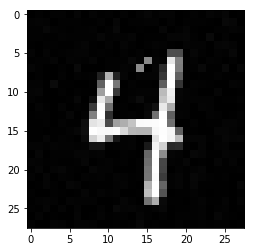

The network predicted a class label of 4


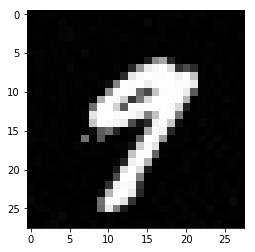

The network predicted a class label of 9


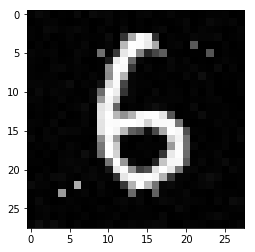

The network predicted a class label of 6


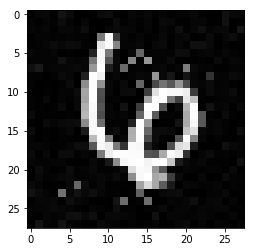

The network predicted a class label of 6


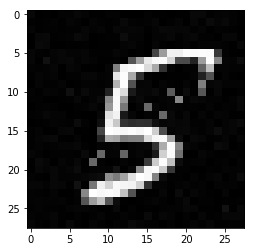

The network predicted a class label of 5


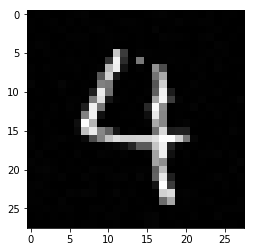

The network predicted a class label of 4


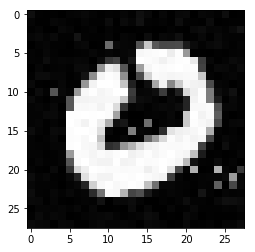

The network predicted a class label of 0


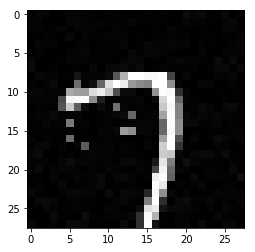

The network predicted a class label of 7


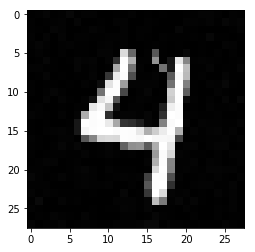

The network predicted a class label of 4


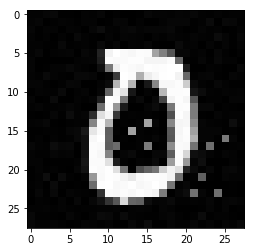

The network predicted a class label of 0


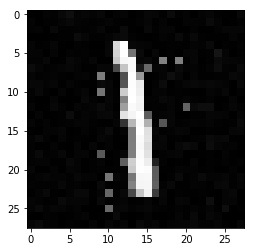

The network predicted a class label of 1


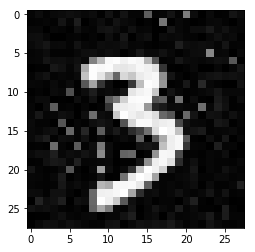

The network predicted a class label of 3


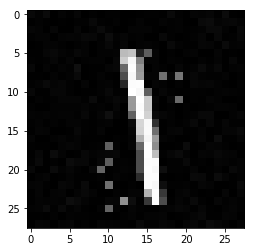

The network predicted a class label of 1


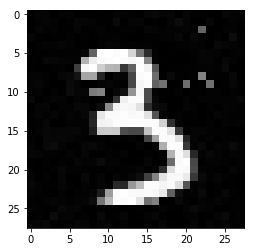

The network predicted a class label of 3


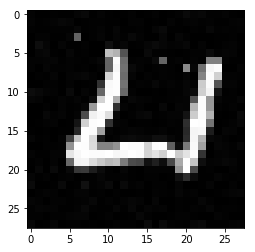

The network predicted a class label of 4


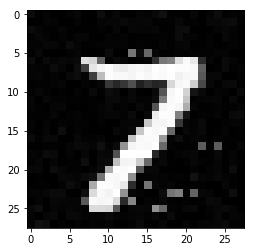

The network predicted a class label of 7


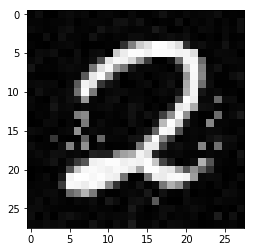

The network predicted a class label of 2


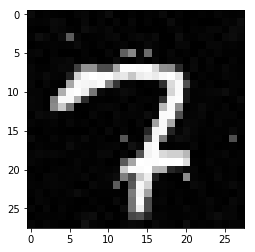

The network predicted a class label of 7


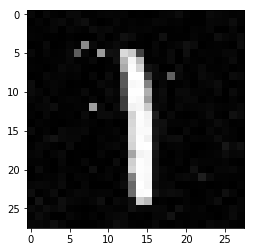

The network predicted a class label of 1


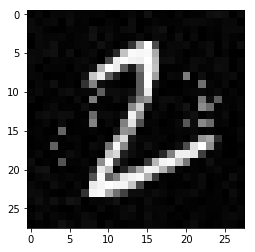

The network predicted a class label of 2


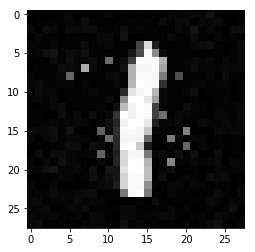

The network predicted a class label of 1


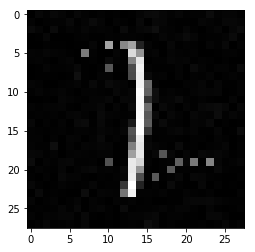

The network predicted a class label of 1


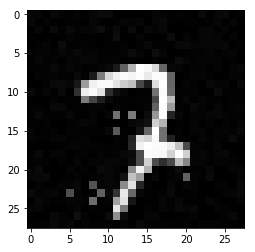

The network predicted a class label of 7


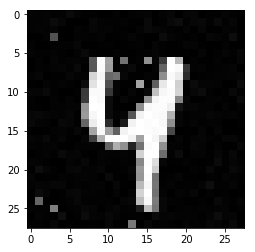

The network predicted a class label of 4


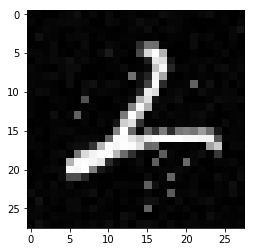

The network predicted a class label of 2


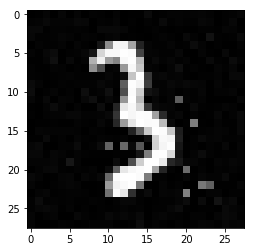

The network predicted a class label of 3


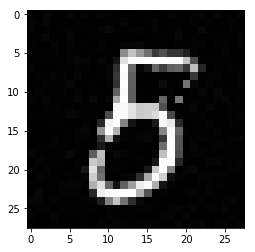

The network predicted a class label of 5


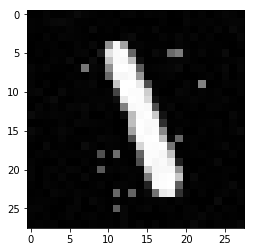

The network predicted a class label of 1


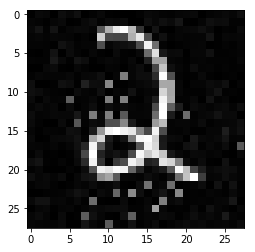

The network predicted a class label of 2


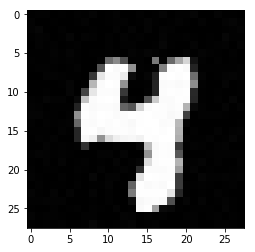

The network predicted a class label of 4


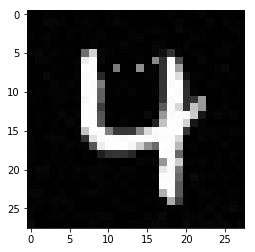

The network predicted a class label of 4


In [0]:
Transfer_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                      model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                      var_list=var_list_LeNet,
                                      transfer_attack_images="Madry_adversaries.csv",
                                      temp_batch_size=None)

The standard CNN scores 5/10 against the Madry examples; this is worse than the binding CNN, but not significantly so, suggesting that the binding-CNN may have most of its advantage simply from e.g. more parameters.

####Standard CNN vs Binding Network Adversaries

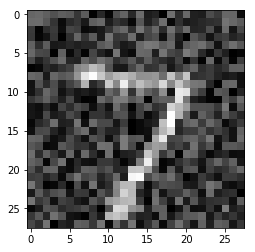

The network predicted a class label of 7


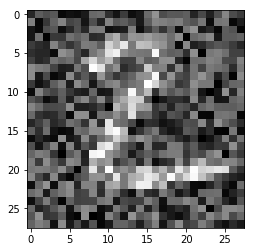

The network predicted a class label of 2


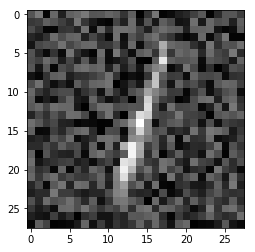

The network predicted a class label of 1


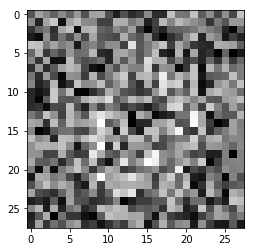

The network predicted a class label of 8


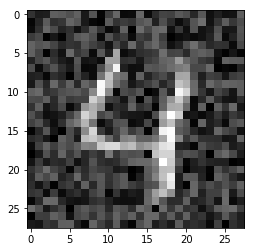

The network predicted a class label of 4


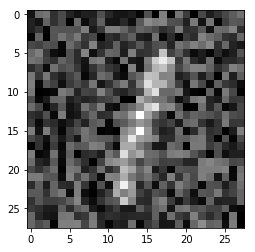

The network predicted a class label of 1


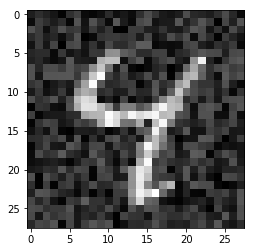

The network predicted a class label of 4


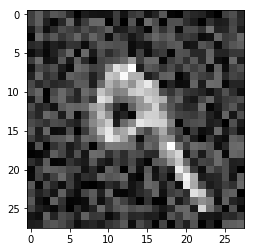

The network predicted a class label of 9


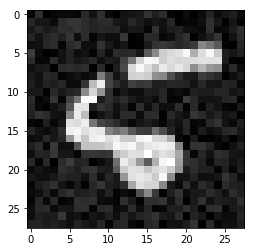

The network predicted a class label of 5


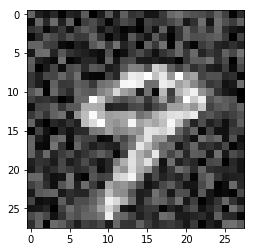

The network predicted a class label of 9


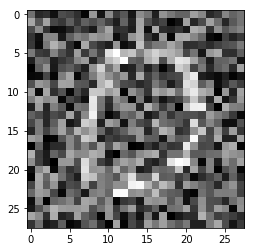

The network predicted a class label of 0


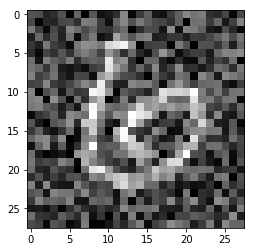

The network predicted a class label of 6


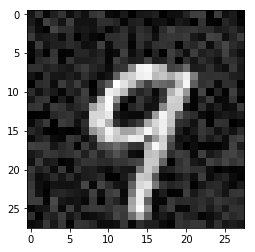

The network predicted a class label of 9


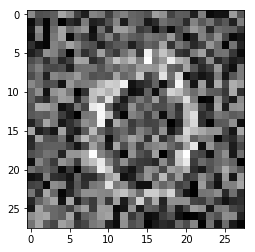

The network predicted a class label of 8


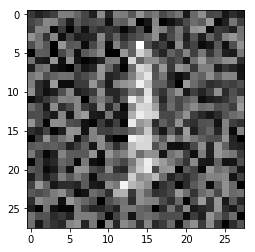

The network predicted a class label of 8


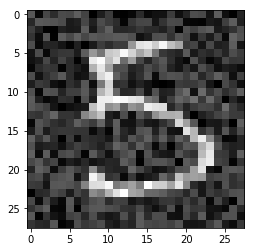

The network predicted a class label of 5


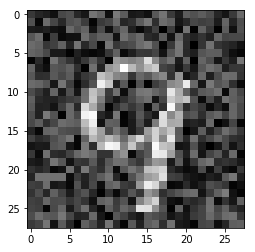

The network predicted a class label of 9


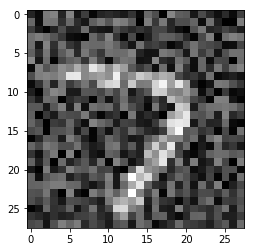

The network predicted a class label of 7


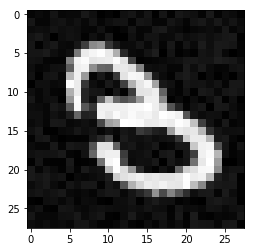

The network predicted a class label of 3


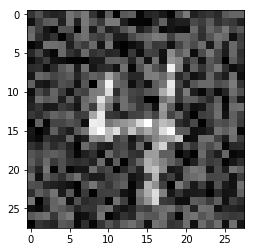

The network predicted a class label of 4


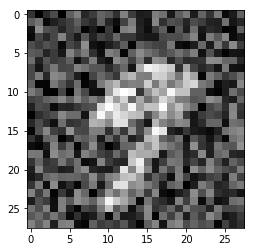

The network predicted a class label of 4


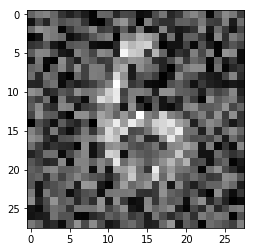

The network predicted a class label of 4


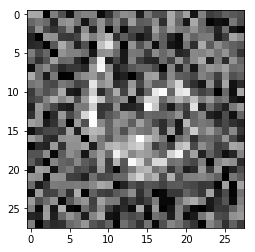

The network predicted a class label of 4


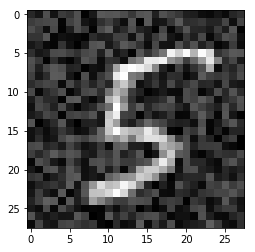

The network predicted a class label of 5


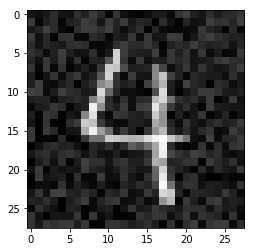

The network predicted a class label of 4


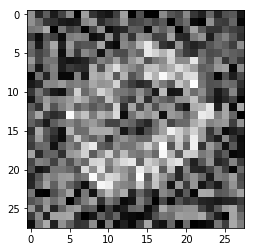

The network predicted a class label of 0


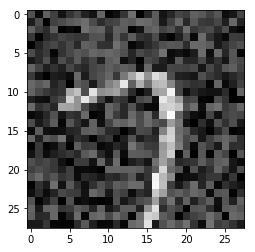

The network predicted a class label of 7


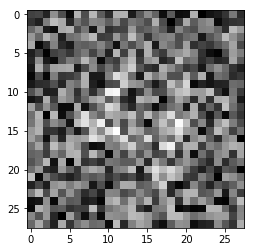

The network predicted a class label of 4


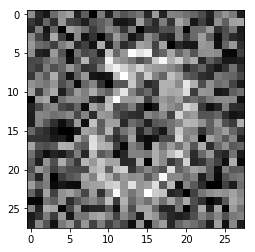

The network predicted a class label of 0


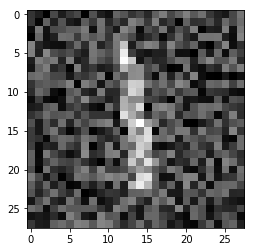

The network predicted a class label of 1


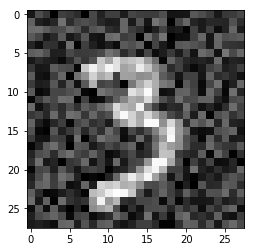

The network predicted a class label of 3


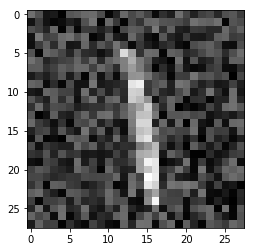

The network predicted a class label of 1


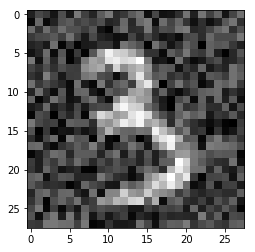

The network predicted a class label of 3


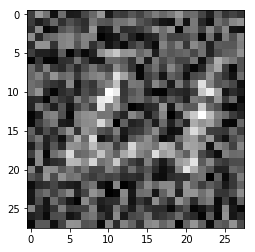

The network predicted a class label of 4


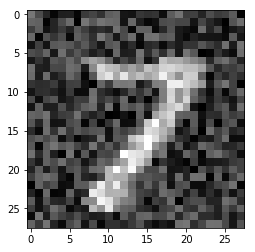

The network predicted a class label of 7


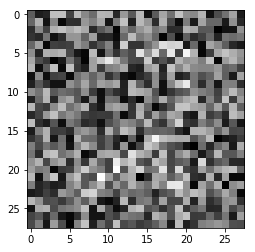

The network predicted a class label of 8


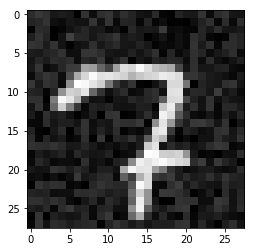

The network predicted a class label of 7


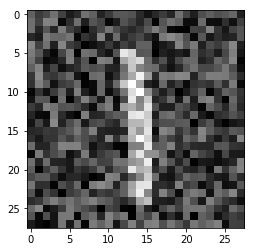

The network predicted a class label of 1


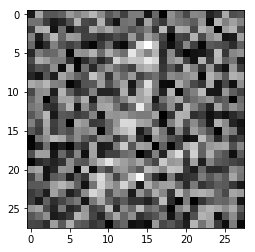

The network predicted a class label of 8


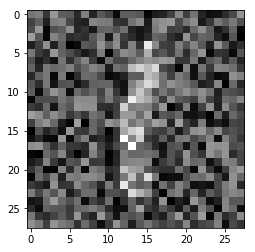

The network predicted a class label of 8


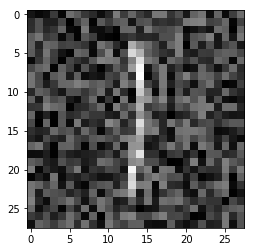

The network predicted a class label of 1


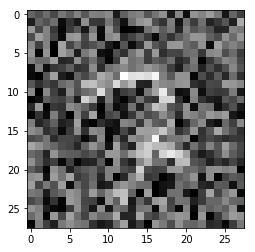

The network predicted a class label of 2


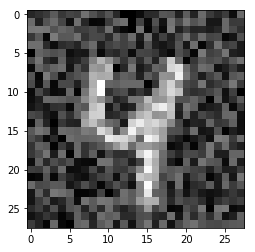

The network predicted a class label of 4


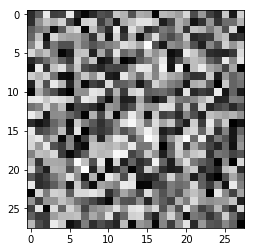

The network predicted a class label of 8


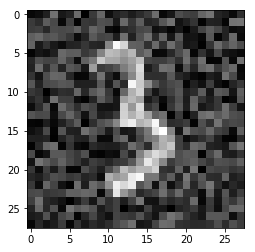

The network predicted a class label of 3


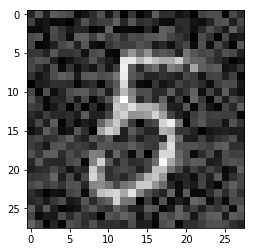

The network predicted a class label of 5


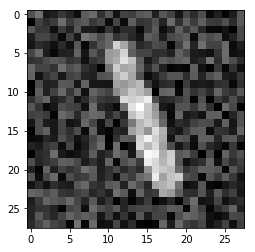

The network predicted a class label of 1


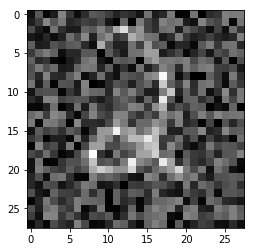

The network predicted a class label of 4


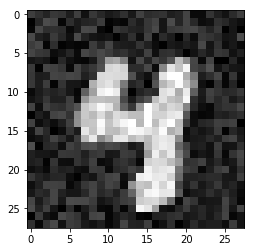

The network predicted a class label of 4


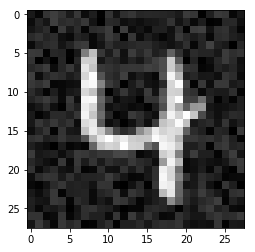

The network predicted a class label of 4


In [0]:
Transfer_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                      model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                      var_list=var_list_LeNet,
                                      transfer_attack_images="BindingNetwork_adversaries.csv",
                                      temp_batch_size=None)

The standard CNN performs poorly (2/10) against the binding networks adversaries.

####Standard CNN vs Its Own Adversaries

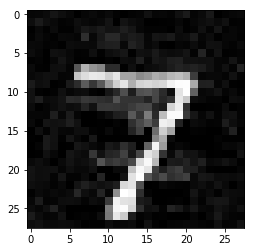

The network predicted a class label of 8


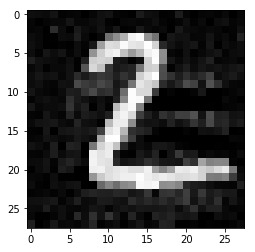

The network predicted a class label of 8


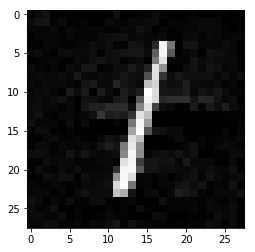

The network predicted a class label of 8


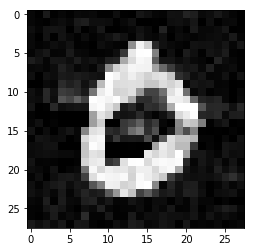

The network predicted a class label of 8


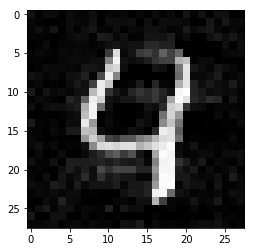

The network predicted a class label of 8


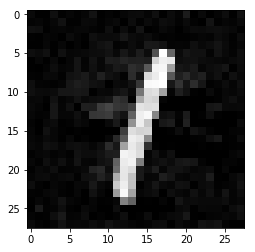

The network predicted a class label of 8


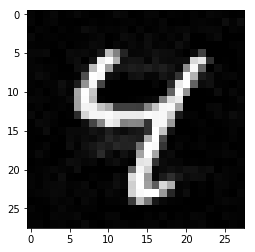

The network predicted a class label of 8


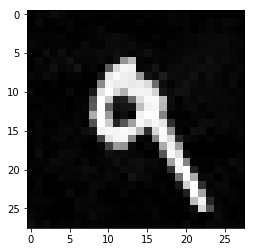

The network predicted a class label of 4


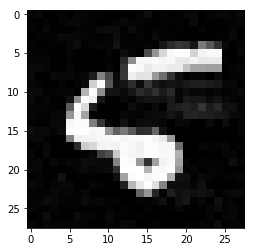

The network predicted a class label of 8


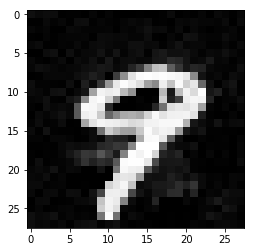

The network predicted a class label of 8


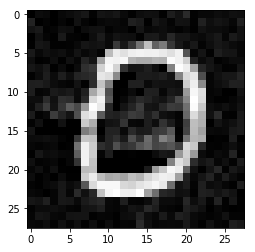

The network predicted a class label of 8


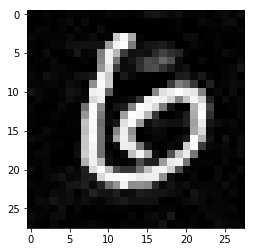

The network predicted a class label of 0


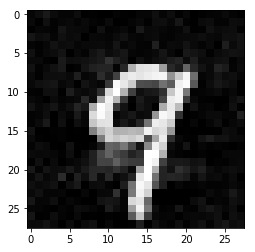

The network predicted a class label of 8


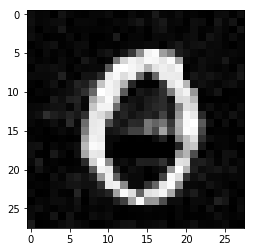

The network predicted a class label of 8


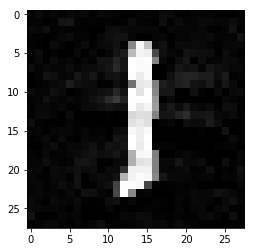

The network predicted a class label of 8


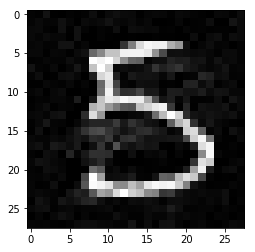

The network predicted a class label of 8


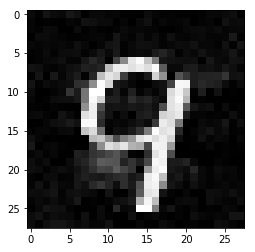

The network predicted a class label of 8


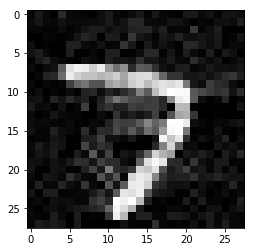

The network predicted a class label of 8


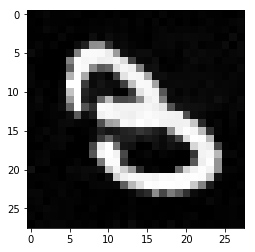

The network predicted a class label of 8


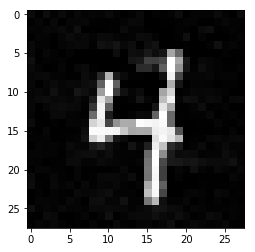

The network predicted a class label of 9


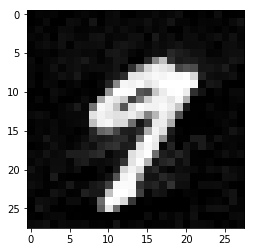

The network predicted a class label of 8


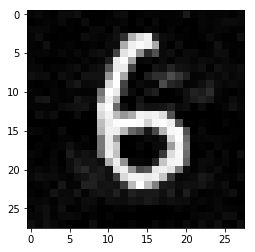

The network predicted a class label of 8


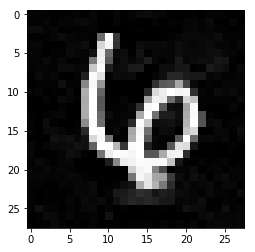

The network predicted a class label of 4


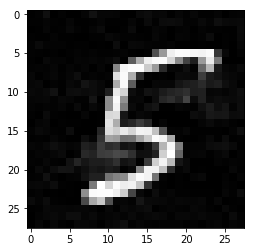

The network predicted a class label of 8


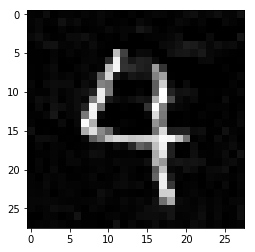

The network predicted a class label of 9


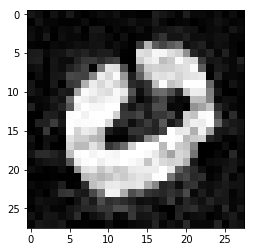

The network predicted a class label of 8


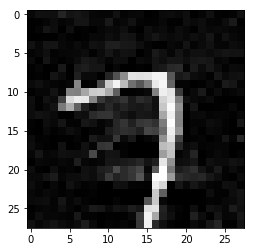

The network predicted a class label of 8


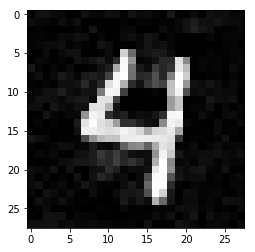

The network predicted a class label of 9


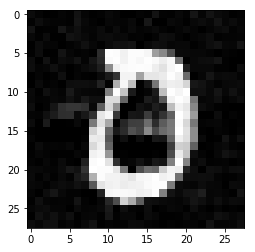

The network predicted a class label of 8


KeyboardInterrupt: ignored

In [0]:
#Double check the adversaries work against the model they were developed for
Transfer_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                      model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                      var_list=var_list_LeNet,
                                      transfer_attack_images="StandardCNN_adversaries.csv",
                                      temp_batch_size=None)

As expected, the standard CNN scores 0/10 against its own adversaries.

####Binding Model vs Standard CNN Adversaries

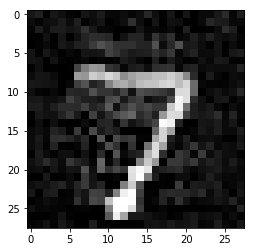

The network predicted a class label of 7


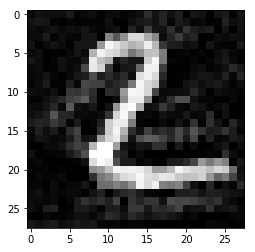

The network predicted a class label of 2


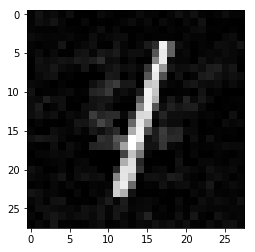

The network predicted a class label of 1


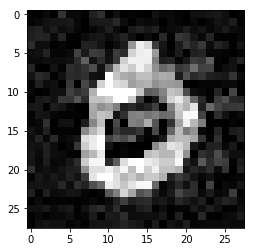

The network predicted a class label of 0


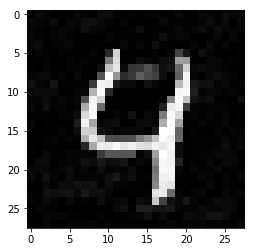

The network predicted a class label of 4


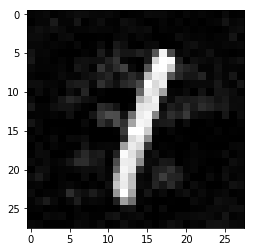

The network predicted a class label of 1


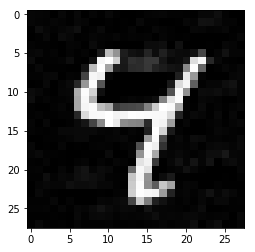

The network predicted a class label of 4


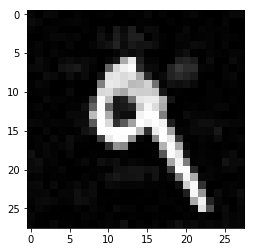

The network predicted a class label of 9


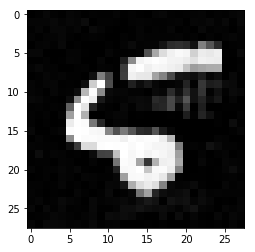

The network predicted a class label of 5


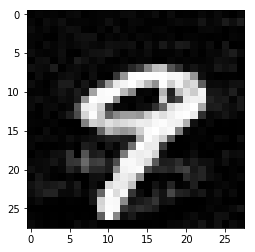

The network predicted a class label of 9


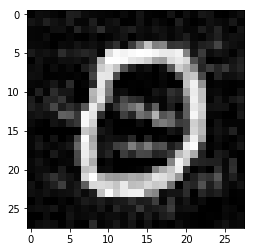

The network predicted a class label of 0


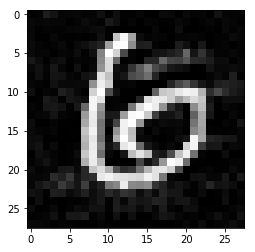

The network predicted a class label of 6


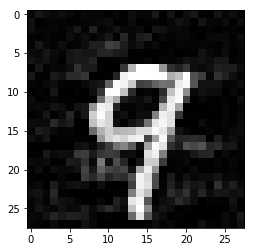

The network predicted a class label of 9


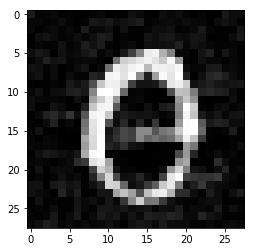

The network predicted a class label of 0


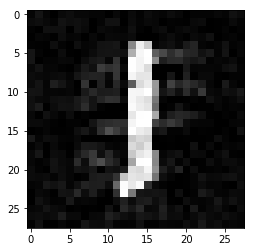

The network predicted a class label of 1


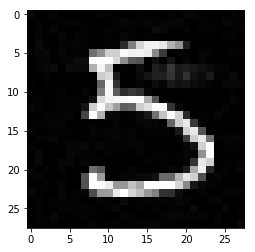

The network predicted a class label of 5


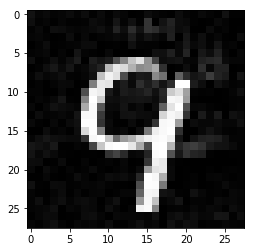

The network predicted a class label of 9


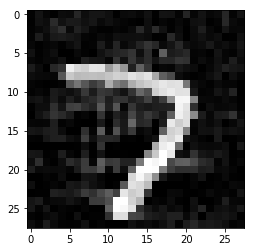

The network predicted a class label of 7


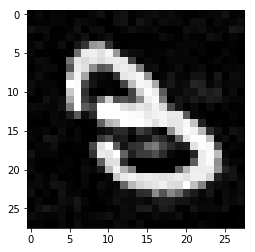

The network predicted a class label of 5


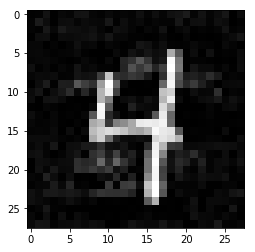

The network predicted a class label of 4


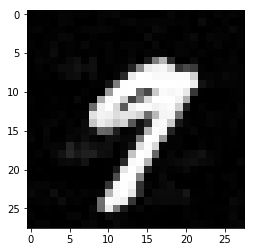

The network predicted a class label of 9


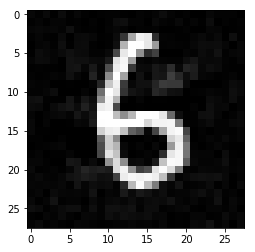

The network predicted a class label of 6


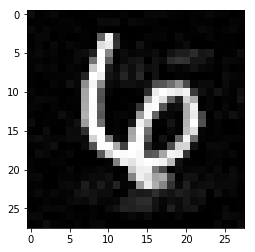

The network predicted a class label of 6


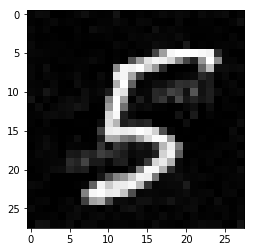

The network predicted a class label of 5


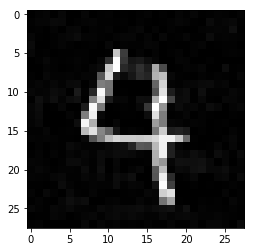

The network predicted a class label of 4


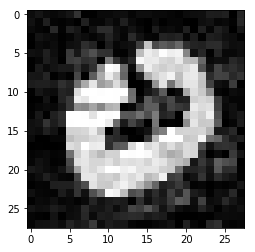

The network predicted a class label of 0


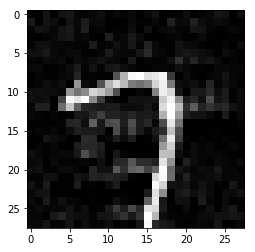

The network predicted a class label of 7


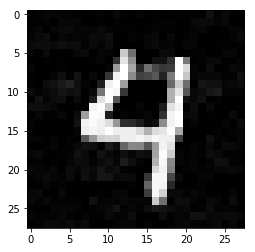

The network predicted a class label of 4


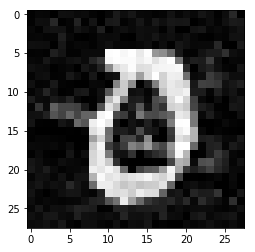

The network predicted a class label of 0


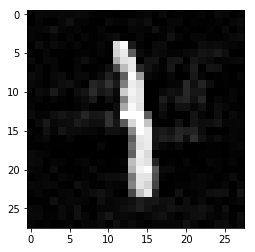

The network predicted a class label of 1


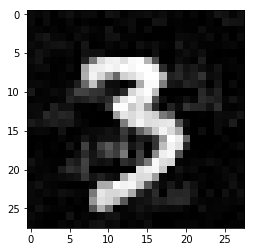

The network predicted a class label of 3


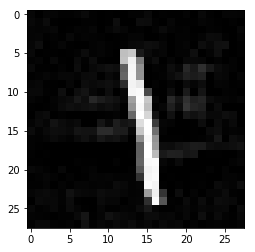

The network predicted a class label of 1


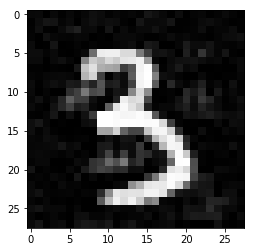

The network predicted a class label of 3


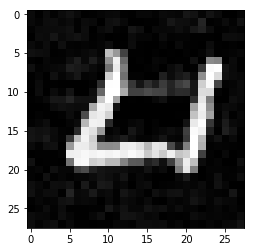

The network predicted a class label of 4


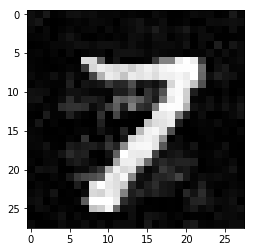

The network predicted a class label of 7


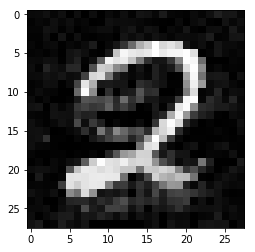

The network predicted a class label of 2


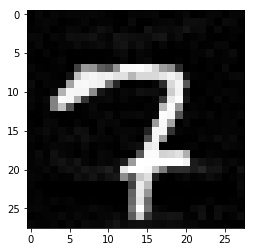

The network predicted a class label of 2


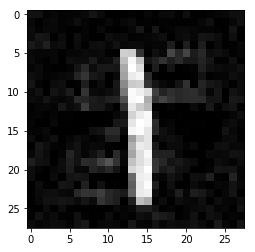

The network predicted a class label of 1


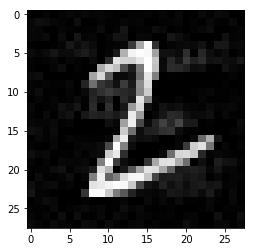

The network predicted a class label of 2


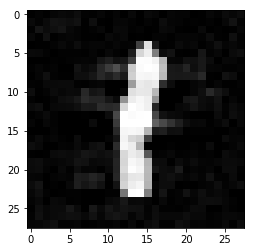

The network predicted a class label of 1


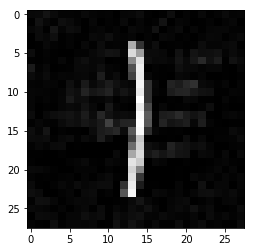

The network predicted a class label of 1


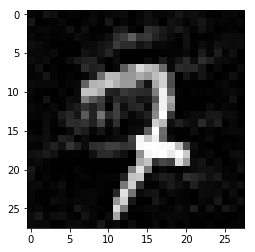

The network predicted a class label of 7


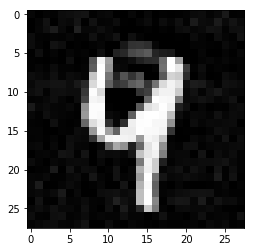

The network predicted a class label of 4


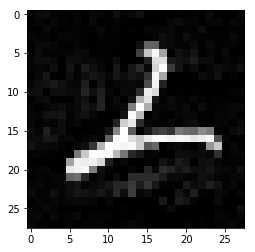

The network predicted a class label of 2


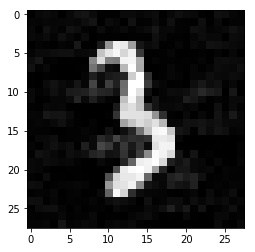

The network predicted a class label of 8


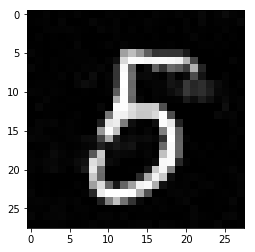

The network predicted a class label of 5


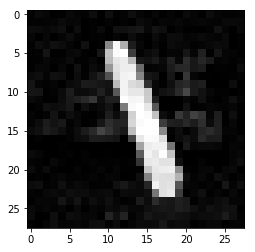

The network predicted a class label of 1


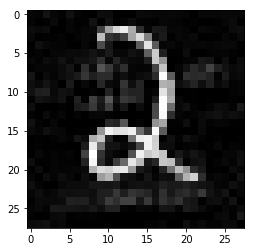

The network predicted a class label of 2


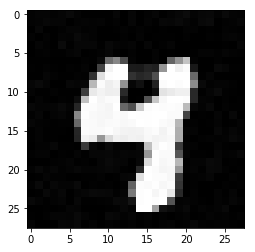

The network predicted a class label of 4


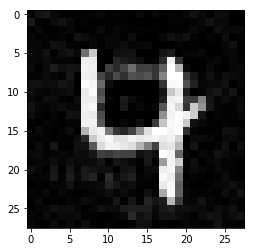

The network predicted a class label of 9


In [0]:
Transfer_Attack_customTensorFlowModel(model_prediction_function=cnn_binding_predictions,
                                      model_weights="/Binding_CNN.ckpt", 
                                      var_list=var_list_Binding,
                                      transfer_attack_images="StandardCNN_adversaries.csv",
                                      temp_batch_size=1)

The binding network performs well against the standard CNN adversaries, scoring 9/10, although note the one class it scored incorrectly (the second to last example) has a debatable ground truth.

####Binding Network vs Mardy Adversaries

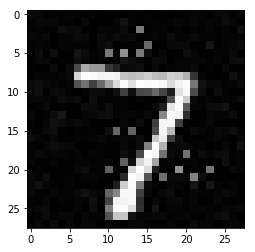

The network predicted a class label of 7


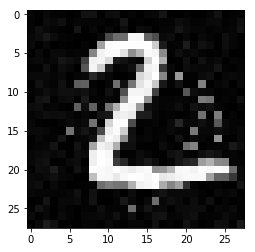

The network predicted a class label of 2


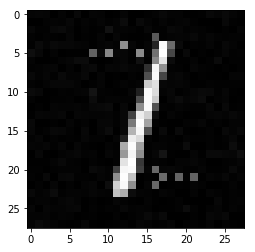

The network predicted a class label of 1


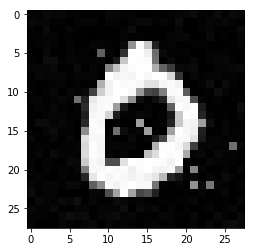

The network predicted a class label of 0


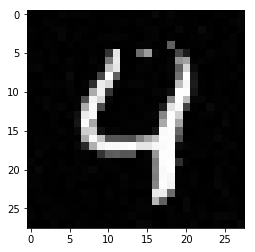

The network predicted a class label of 4


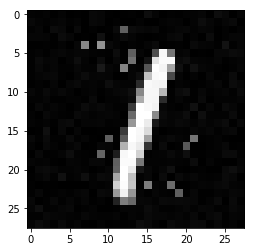

The network predicted a class label of 1


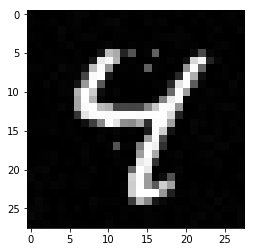

The network predicted a class label of 4


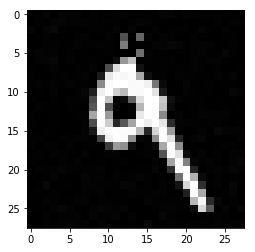

The network predicted a class label of 9


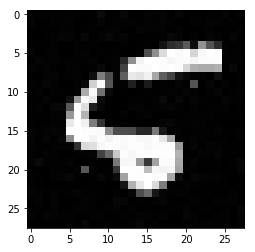

The network predicted a class label of 5


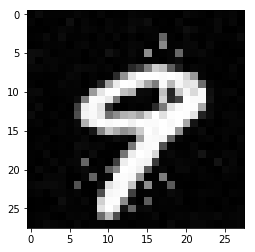

The network predicted a class label of 9


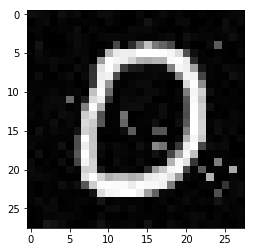

The network predicted a class label of 0


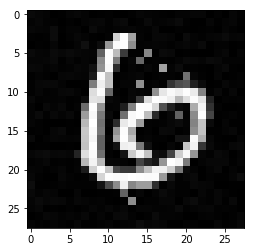

The network predicted a class label of 6


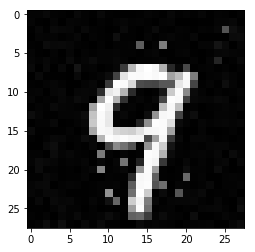

The network predicted a class label of 9


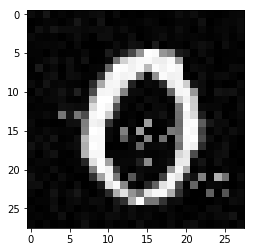

The network predicted a class label of 0


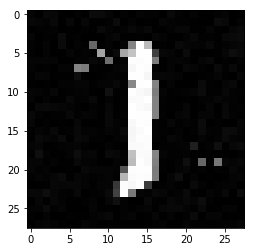

The network predicted a class label of 1


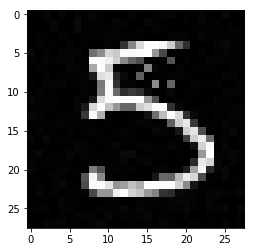

The network predicted a class label of 5


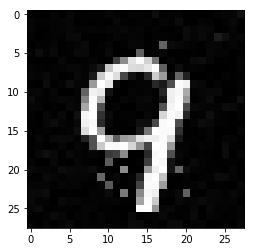

The network predicted a class label of 9


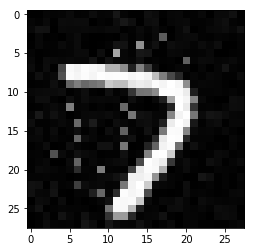

The network predicted a class label of 7


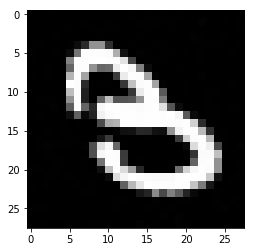

The network predicted a class label of 3


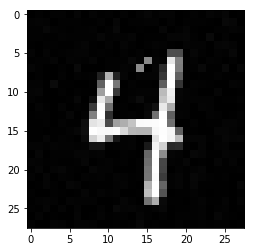

The network predicted a class label of 4


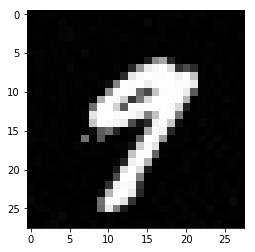

The network predicted a class label of 9


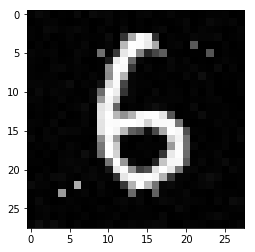

The network predicted a class label of 6


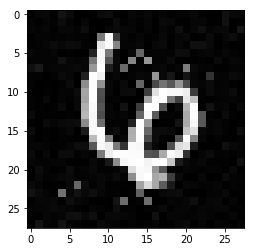

The network predicted a class label of 6


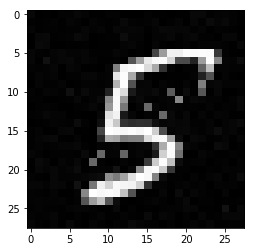

The network predicted a class label of 5


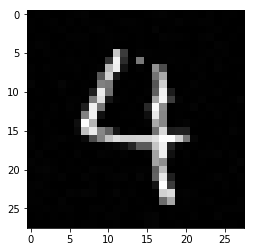

The network predicted a class label of 4


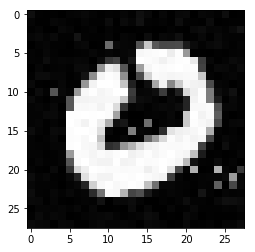

The network predicted a class label of 0


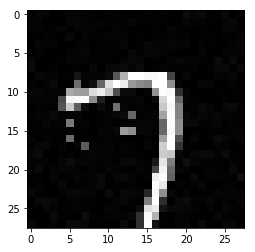

The network predicted a class label of 7


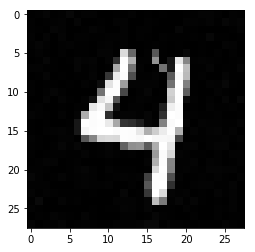

The network predicted a class label of 4


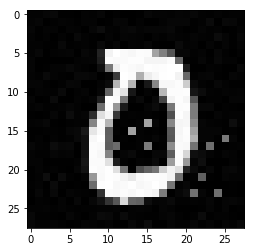

The network predicted a class label of 0


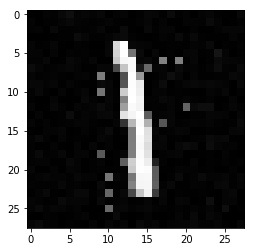

The network predicted a class label of 1


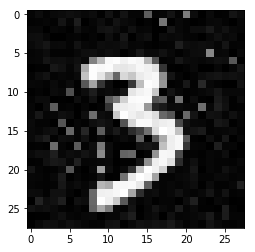

The network predicted a class label of 3


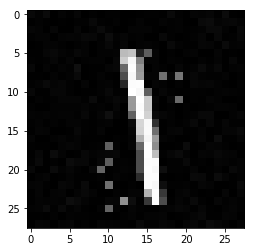

The network predicted a class label of 1


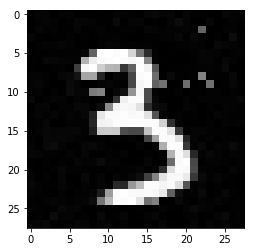

The network predicted a class label of 3


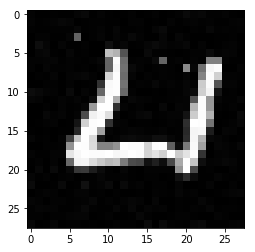

The network predicted a class label of 4


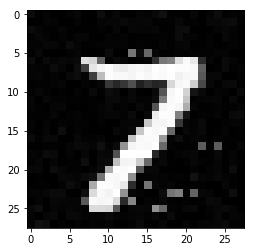

The network predicted a class label of 7


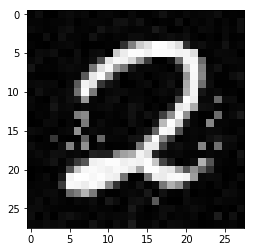

The network predicted a class label of 2


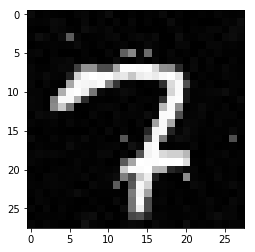

The network predicted a class label of 7


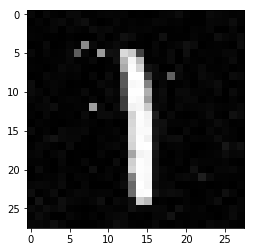

The network predicted a class label of 1


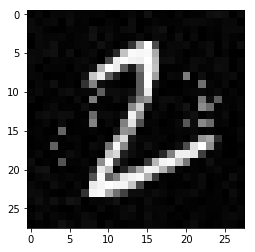

The network predicted a class label of 2


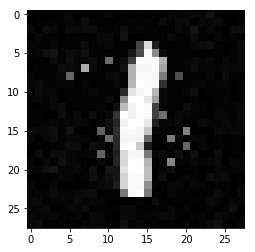

The network predicted a class label of 1


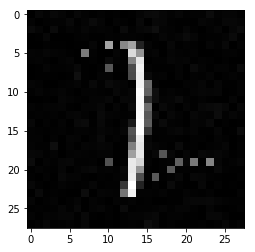

The network predicted a class label of 1


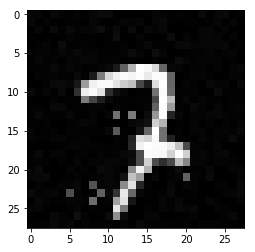

The network predicted a class label of 7


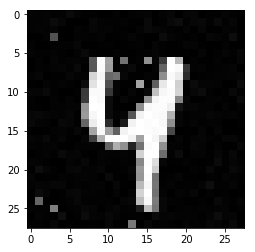

The network predicted a class label of 4


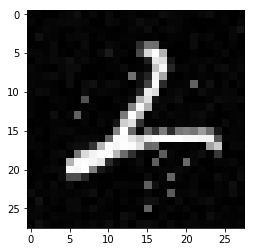

The network predicted a class label of 2


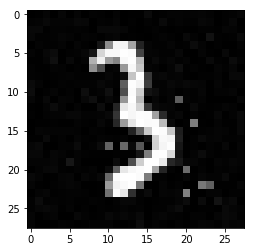

The network predicted a class label of 3


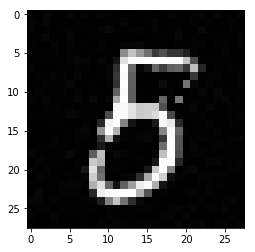

The network predicted a class label of 5


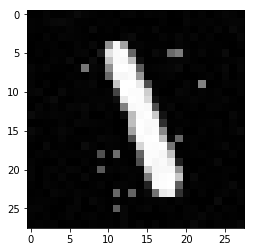

The network predicted a class label of 1


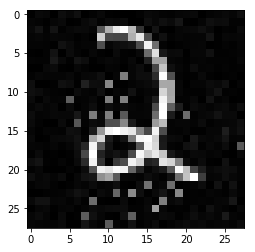

The network predicted a class label of 2


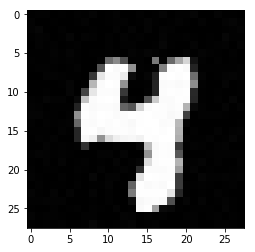

The network predicted a class label of 4


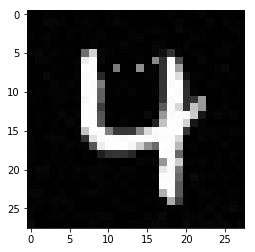

The network predicted a class label of 4


In [0]:
Transfer_Attack_customTensorFlowModel(model_prediction_function=cnn_binding_predictions,
                                      model_weights="/Binding_CNN.ckpt", 
                                      var_list=var_list_Binding,
                                      transfer_attack_images="Madry_adversaries.csv",
                                      temp_batch_size=1)

The binding network performed reasonably against the Madry adversaries, scoring 7/10. Note in particular that the binding network has had *no* training on adversarial examples, and yet its performance is comparable to that of the highly optimized (and I believe larger-parameter) Madry model.

####Binding Network vs Its Own Adversaries

In [0]:
Transfer_Attack_customTensorFlowModel(model_prediction_function=cnn_binding_predictions,
                                      model_weights="/Binding_CNN.ckpt", 
                                      var_list=var_list_Binding,
                                      transfer_attack_images="BindingNetwork_adversaries.csv",
                                      temp_batch_size=1)

As expected, the binding network scores 0/10 against its own adversaries.

##Point-Wise Attack

###Point-Wise Attack Functions for the TensorFlow Models

In [0]:
# *** this code can eventually be refractored with earlier functions

#Function used to attack an arbitrary model that has been implemented with TensorFlow's low-level API (i.e. requires a session to be called explicitly)
def PointWise_Attack_customTensorFlowModel(model_prediction_function, model_weights, var_list, test_image, test_label, temp_batch_size, keep_prob):

    images = x #x is a place-holder for 28x28 images earlier defined
    logits = model_prediction_function(images, temp_batch_size, keep_prob)

    saver = tf.train.Saver(var_list) #Define saver object for use later when loading the model weights

    #Note how when attacking a low-level TensorFlow API model, it is necessary for all steps to occur within the tf.Session()
    with tf.Session() as session:
        saver.restore(session, model_weights)

        #Define the foolbox model
        fmodel = foolbox.models.TensorFlowModel(images, logits, (0,1)) #The final parameter specifies the input values range

        #The predicted label of the network prior to carrying out the attack
        pre_label = np.argmax(fmodel.predictions(test_image[:, :, :]))
        #print("The classification label prior to attack is " + str(pre_label))
        if (pre_label != test_label):
            print("The model predicted a " + str(pre_label) + " when the ground-truth label is " + str(test_label))
            plt.imshow(test_image[:,:,0], cmap='gray')

        #Carry out the untargeted Bounary Attack
        attack_fmodel = foolbox.attacks.PointwiseAttack(model=fmodel, criterion=foolbox.criteria.Misclassification())
        adversarial_image_fmodel = attack_fmodel(test_image, test_label)
        plt.imshow(adversarial_image_fmodel[:,:,0], cmap='gray')
        plt.show()
        
        #Check the output of the adversarial attack
        adversarial_label_fmodel = np.argmax(fmodel.predictions(adversarial_image_fmodel[:, :, :]))
        print("The classification label following attack is " + str(adversarial_label_fmodel) 
              + " from an original classification of " + str(test_label))
        
        return adversarial_image_fmodel, adversarial_label_fmodel

In [0]:
#Iterate through a series of images to be attacked
def evaluate_l0_PointWiseAttack_resistance_CustomModel(model_prediction_function, model_weights, var_list, num_images_to_attack, temp_batch_size):
    adversary_found = np.zeros([num_images_to_attack]) #array of booleans that indicates if an adversary was found for a particular image
    adversary_distance = np.zeros([num_images_to_attack])
    adversary_arrays = np.zeros([num_images_to_attack, testing_data.shape[1], testing_data.shape[2], 1])

    for ii in range(num_images_to_attack):
        test_image = testing_data[ii, :, :]
        test_label = np.argmax(testing_labels[ii,:])

        adversarial_image_fmodel, adversarial_classification = PointWise_Attack_customTensorFlowModel(model_prediction_function, 
                                                                                                     model_weights, var_list, 
                                                                                                     test_image, test_label, 
                                                                                                     temp_batch_size,
                                                                                                     keep_prob=1.0)
        adversary_arrays[ii, :, :] = adversarial_image_fmodel

        if ((np.any(adversarial_image_fmodel == None) | adversarial_classification == test_label)):
            print("No adversarial image found")

        else:
            l0_distance = scipy.spatial.distance.hamming(test_image.flatten(), adversarial_image_fmodel.flatten())
            print("The L0 distance of the adversary is " + str(l0_distance))
            adversary_found[ii] = 1
            adversary_distance[ii] = l0_distance
        
    return adversary_found, adversary_distance, adversary_arrays

###Visualize the Point-Wise Attack

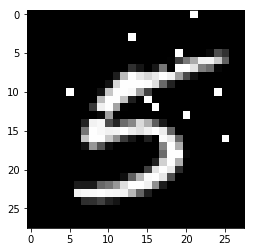

The classification label following attack is 3 from an original classification of 5


In [68]:
#An example of the attack
adversarial_image_fmodel, adversarial_label_fmodel = PointWise_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                                                 model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                                                var_list=var_list_LeNet,
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=None,
                                                                                           keep_prob=1.0)


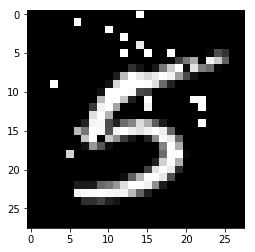

The classification label following attack is 3 from an original classification of 5


In [69]:
adversarial_image_fmodel, adversarial_label_fmodel = PointWise_Attack_customTensorFlowModel(model_prediction_function=cnn_binding_predictions,
                                                                 model_weights="/Binding_CNN.ckpt",
                                                                  var_list=var_list_Binding,
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=1,
                                                                                           keep_prob=1.0)


###Quantify Vulnerability

In [0]:
num_images_to_attack=50

####Standard CNN

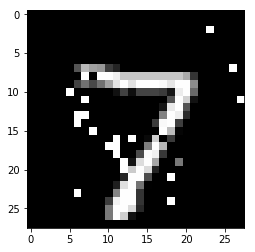

The classification label following attack is 8 from an original classification of 7
The L0 distance of the adversary is 0.030612244897959183


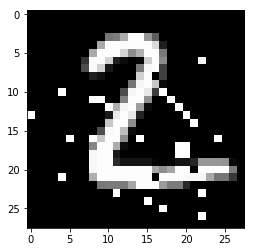

The classification label following attack is 8 from an original classification of 2
The L0 distance of the adversary is 0.03571428571428571


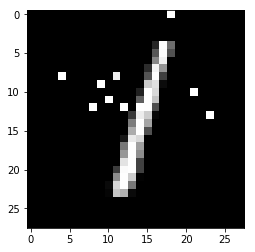

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.012755102040816327


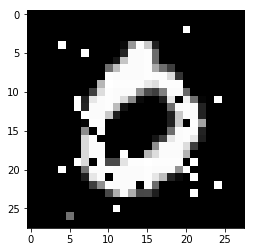

The classification label following attack is 2 from an original classification of 0
The L0 distance of the adversary is 0.03188775510204082


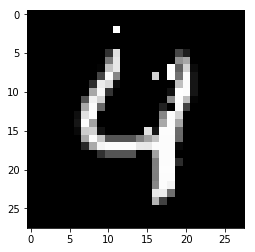

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.007653061224489796


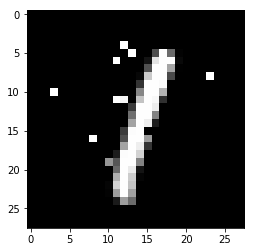

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.012755102040816327


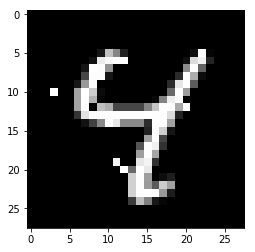

The classification label following attack is 8 from an original classification of 4
The L0 distance of the adversary is 0.012755102040816327


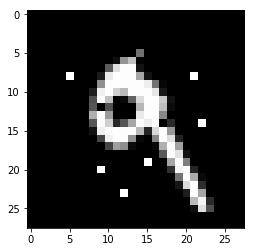

The classification label following attack is 8 from an original classification of 9
The L0 distance of the adversary is 0.011479591836734694


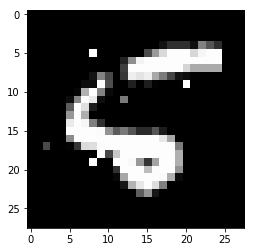

The classification label following attack is 6 from an original classification of 5
The L0 distance of the adversary is 0.01020408163265306


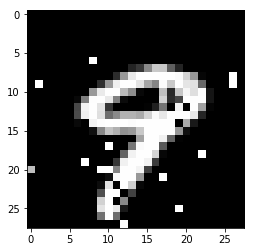

The classification label following attack is 8 from an original classification of 9
The L0 distance of the adversary is 0.025510204081632654


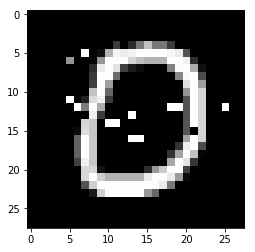

The classification label following attack is 8 from an original classification of 0
The L0 distance of the adversary is 0.017857142857142856


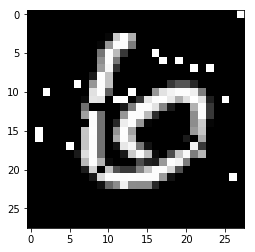

The classification label following attack is 8 from an original classification of 6
The L0 distance of the adversary is 0.029336734693877552


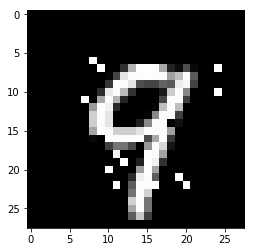

The classification label following attack is 8 from an original classification of 9
The L0 distance of the adversary is 0.017857142857142856


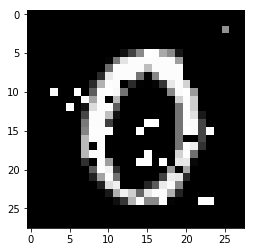

The classification label following attack is 8 from an original classification of 0
The L0 distance of the adversary is 0.03188775510204082


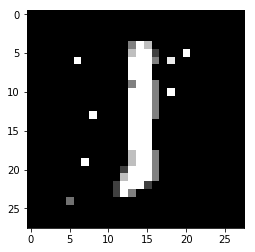

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.008928571428571428


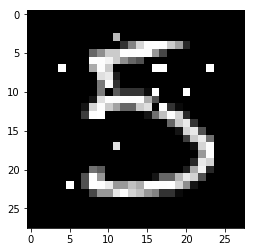

The classification label following attack is 3 from an original classification of 5
The L0 distance of the adversary is 0.016581632653061226


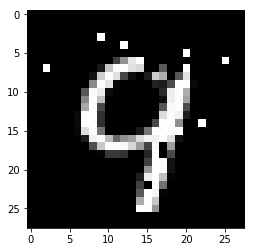

The classification label following attack is 4 from an original classification of 9
The L0 distance of the adversary is 0.02040816326530612


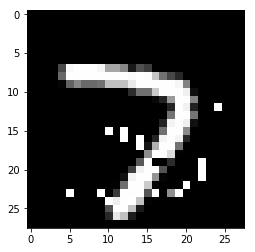

The classification label following attack is 3 from an original classification of 7
The L0 distance of the adversary is 0.02295918367346939


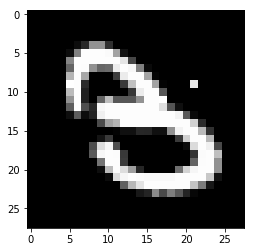

The classification label following attack is 8 from an original classification of 3
The L0 distance of the adversary is 0.002551020408163265


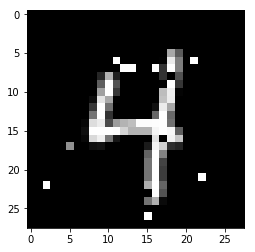

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.016581632653061226


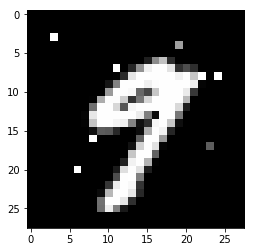

The classification label following attack is 7 from an original classification of 9
The L0 distance of the adversary is 0.011479591836734694


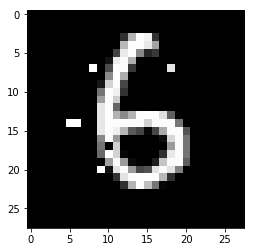

The classification label following attack is 5 from an original classification of 6
The L0 distance of the adversary is 0.007653061224489796


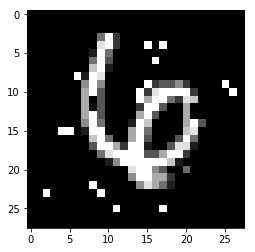

The classification label following attack is 8 from an original classification of 6
The L0 distance of the adversary is 0.02806122448979592


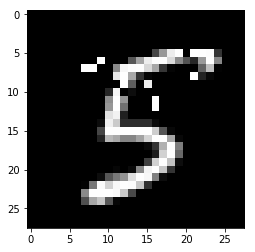

The classification label following attack is 3 from an original classification of 5
The L0 distance of the adversary is 0.012755102040816327


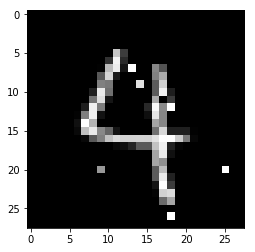

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.008928571428571428


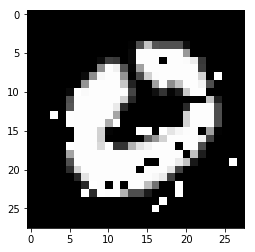

The classification label following attack is 8 from an original classification of 0
The L0 distance of the adversary is 0.039540816326530615


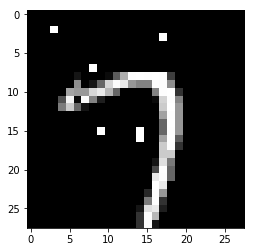

The classification label following attack is 9 from an original classification of 7
The L0 distance of the adversary is 0.008928571428571428


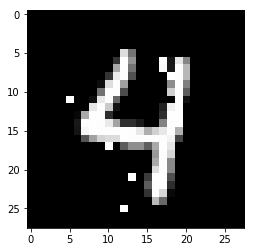

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.01020408163265306


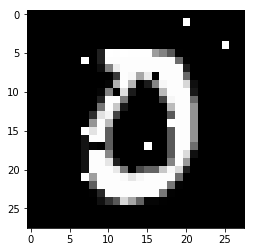

The classification label following attack is 3 from an original classification of 0
The L0 distance of the adversary is 0.01403061224489796


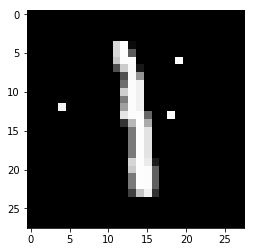

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.003826530612244898


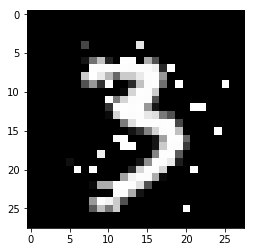

The classification label following attack is 8 from an original classification of 3
The L0 distance of the adversary is 0.03571428571428571


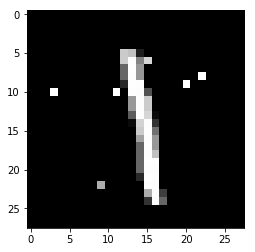

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.007653061224489796


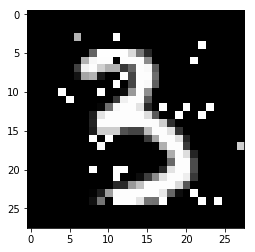

The classification label following attack is 8 from an original classification of 3
The L0 distance of the adversary is 0.03571428571428571


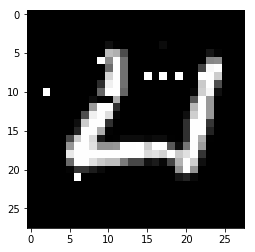

The classification label following attack is 0 from an original classification of 4
The L0 distance of the adversary is 0.012755102040816327


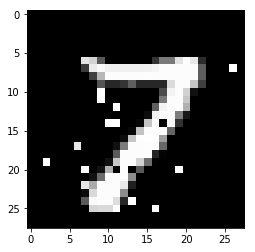

The classification label following attack is 8 from an original classification of 7
The L0 distance of the adversary is 0.02295918367346939


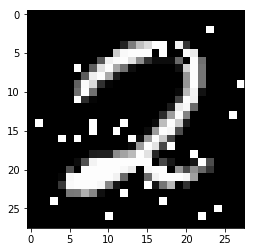

The classification label following attack is 8 from an original classification of 2
The L0 distance of the adversary is 0.042091836734693876


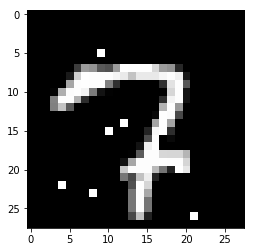

The classification label following attack is 3 from an original classification of 7
The L0 distance of the adversary is 0.011479591836734694


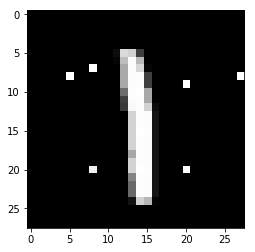

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.007653061224489796


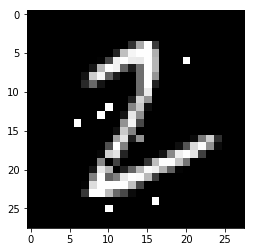

The classification label following attack is 3 from an original classification of 2
The L0 distance of the adversary is 0.01020408163265306


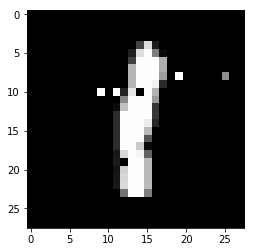

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.007653061224489796


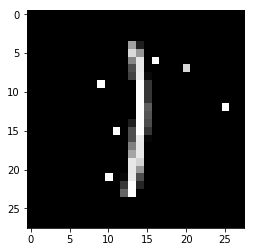

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.007653061224489796


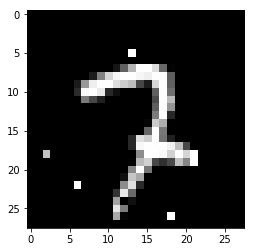

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.008928571428571428


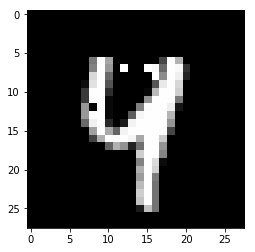

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.006377551020408163


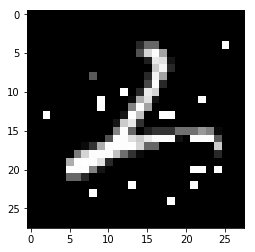

The classification label following attack is 8 from an original classification of 2
The L0 distance of the adversary is 0.02423469387755102


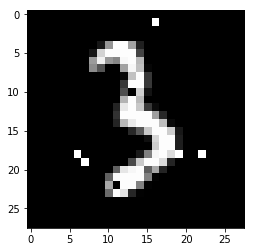

The classification label following attack is 2 from an original classification of 3
The L0 distance of the adversary is 0.01020408163265306


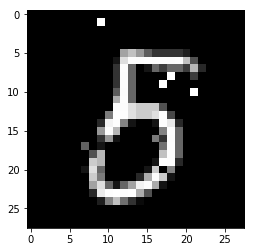

The classification label following attack is 8 from an original classification of 5
The L0 distance of the adversary is 0.008928571428571428


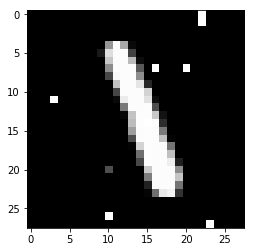

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.01020408163265306


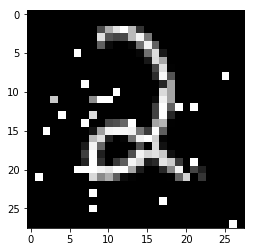

The classification label following attack is 3 from an original classification of 2
The L0 distance of the adversary is 0.036989795918367346


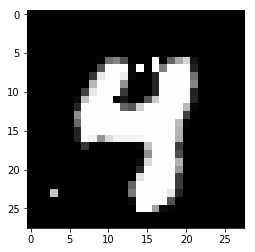

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.006377551020408163


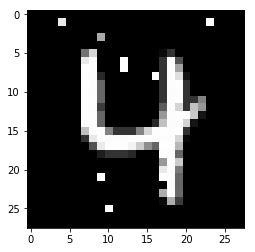

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.011479591836734694


In [71]:
adversary_found, adversary_distance, adversary_arrays = evaluate_l0_PointWiseAttack_resistance_CustomModel(
    model_prediction_function=cnn_predictions, model_weights="/MNIST_LeNet5_CNN.ckpt", var_list=var_list_LeNet,
    num_images_to_attack=num_images_to_attack, temp_batch_size=None)

In [72]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
mean_distance_successful_attacks = np.sum(adversary_distance)/np.sum(adversary_found)

print("The success ratio is " + str(success_ratio))
print("The mean distance is " + str(mean_distance_successful_attacks))


The success ratio is 1.0
The mean distance is 0.01693877551020408


The Point-Wise attack is able to achieve 100% misclassification against the binding CNN with a mean l-0 distance of 0.0233. This is a larger distance than that required against the binding CNN, arguing against increased adversarial resistance through the 'binding' representations. Note these results were obtained from 100 images. 

####Binding CNN

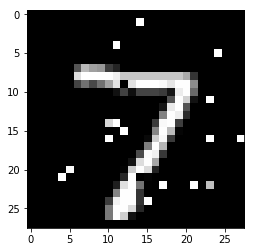

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.02423469387755102


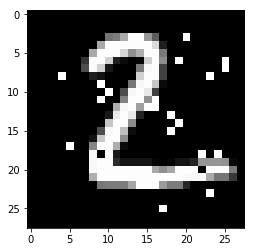

The classification label following attack is 8 from an original classification of 2
The L0 distance of the adversary is 0.02806122448979592


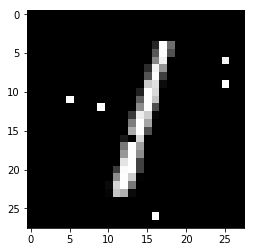

The classification label following attack is 5 from an original classification of 1
The L0 distance of the adversary is 0.007653061224489796


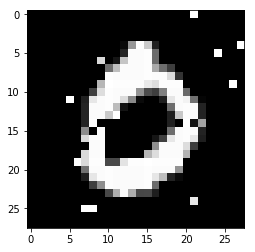

The classification label following attack is 5 from an original classification of 0
The L0 distance of the adversary is 0.02040816326530612


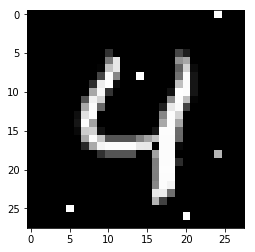

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.01020408163265306


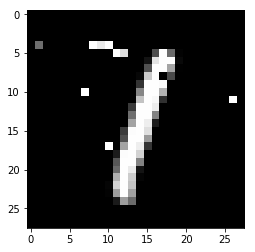

The classification label following attack is 7 from an original classification of 1
The L0 distance of the adversary is 0.012755102040816327


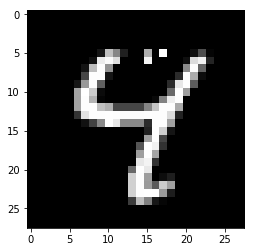

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.00510204081632653


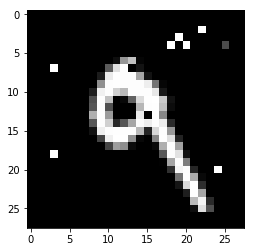

The classification label following attack is 5 from an original classification of 9
The L0 distance of the adversary is 0.012755102040816327


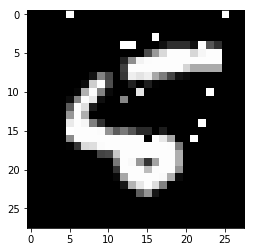

The classification label following attack is 6 from an original classification of 5
The L0 distance of the adversary is 0.016581632653061226


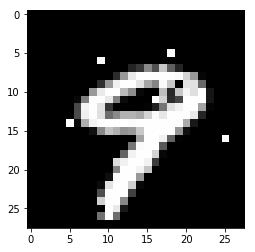

The classification label following attack is 4 from an original classification of 9
The L0 distance of the adversary is 0.012755102040816327


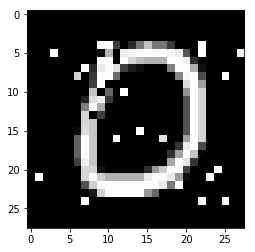

The classification label following attack is 2 from an original classification of 0
The L0 distance of the adversary is 0.03316326530612245


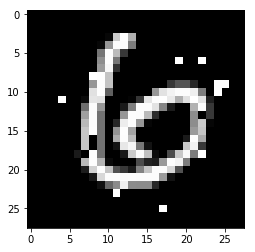

The classification label following attack is 5 from an original classification of 6
The L0 distance of the adversary is 0.01913265306122449


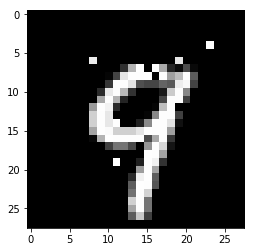

The classification label following attack is 4 from an original classification of 9
The L0 distance of the adversary is 0.01020408163265306


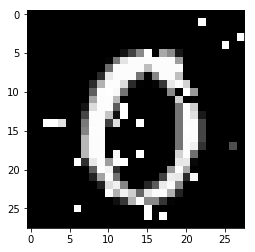

The classification label following attack is 9 from an original classification of 0
The L0 distance of the adversary is 0.03571428571428571


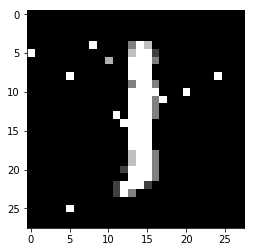

The classification label following attack is 3 from an original classification of 1
The L0 distance of the adversary is 0.015306122448979591


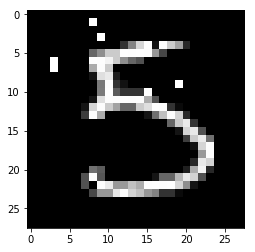

The classification label following attack is 3 from an original classification of 5
The L0 distance of the adversary is 0.012755102040816327


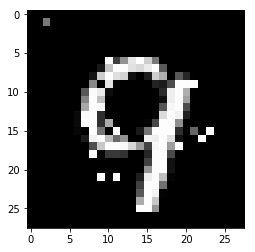

The classification label following attack is 7 from an original classification of 9
The L0 distance of the adversary is 0.02295918367346939


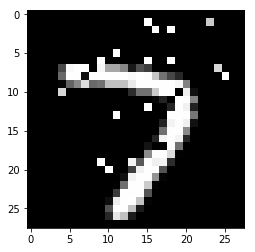

The classification label following attack is 3 from an original classification of 7
The L0 distance of the adversary is 0.03188775510204082
The model predicted a 5 when the ground-truth label is 3


/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


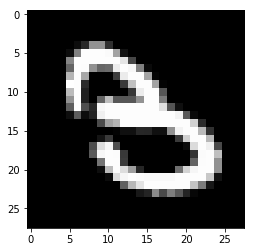

The classification label following attack is 5 from an original classification of 3
The L0 distance of the adversary is 0.0


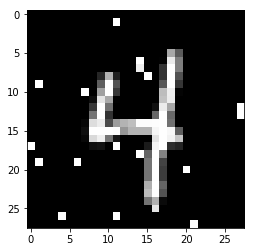

The classification label following attack is 7 from an original classification of 4
The L0 distance of the adversary is 0.025510204081632654


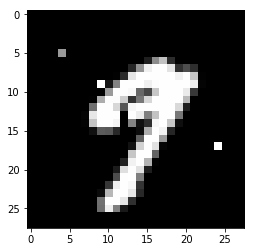

The classification label following attack is 7 from an original classification of 9
The L0 distance of the adversary is 0.006377551020408163


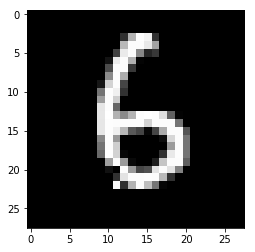

The classification label following attack is 5 from an original classification of 6
The L0 distance of the adversary is 0.002551020408163265


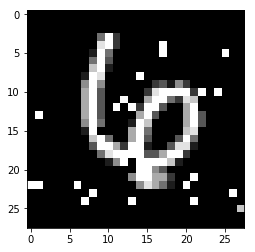

The classification label following attack is 5 from an original classification of 6
The L0 distance of the adversary is 0.03188775510204082


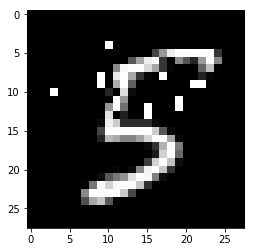

The classification label following attack is 3 from an original classification of 5
The L0 distance of the adversary is 0.02040816326530612


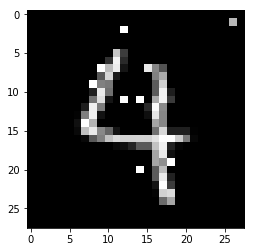

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.011479591836734694


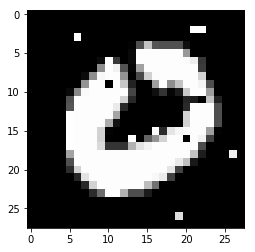

The classification label following attack is 6 from an original classification of 0
The L0 distance of the adversary is 0.015306122448979591


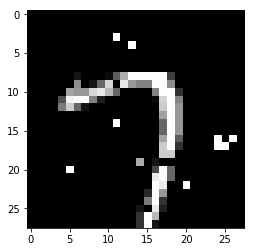

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.017857142857142856


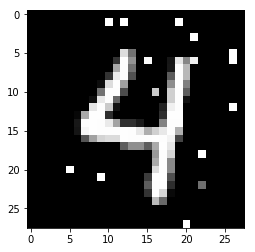

The classification label following attack is 5 from an original classification of 4
The L0 distance of the adversary is 0.01913265306122449


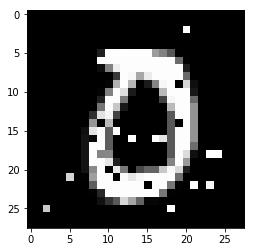

The classification label following attack is 2 from an original classification of 0
The L0 distance of the adversary is 0.02806122448979592


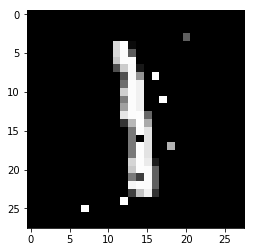

The classification label following attack is 3 from an original classification of 1
The L0 distance of the adversary is 0.011479591836734694


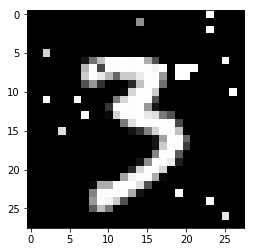

The classification label following attack is 5 from an original classification of 3
The L0 distance of the adversary is 0.025510204081632654


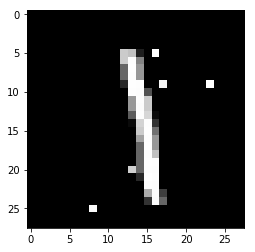

The classification label following attack is 5 from an original classification of 1
The L0 distance of the adversary is 0.006377551020408163


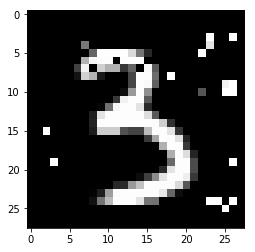

The classification label following attack is 5 from an original classification of 3
The L0 distance of the adversary is 0.029336734693877552


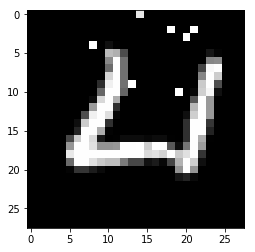

The classification label following attack is 0 from an original classification of 4
The L0 distance of the adversary is 0.008928571428571428


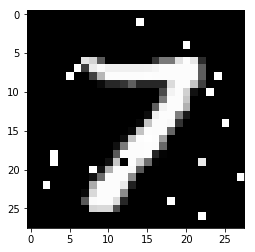

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.02040816326530612


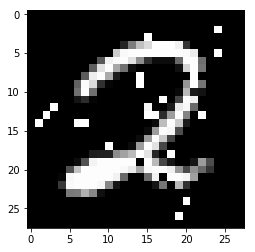

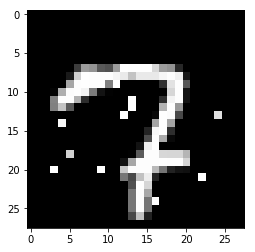

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.01403061224489796


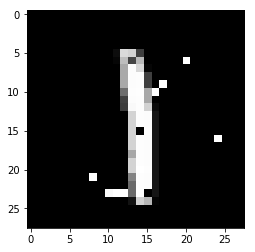

The classification label following attack is 5 from an original classification of 1
The L0 distance of the adversary is 0.01403061224489796


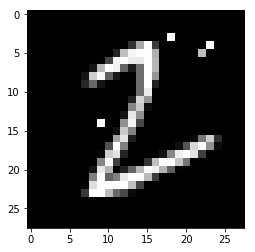

The classification label following attack is 1 from an original classification of 2
The L0 distance of the adversary is 0.00510204081632653


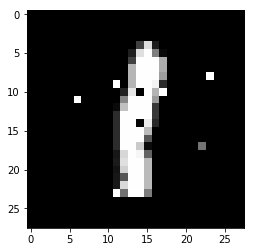

The classification label following attack is 8 from an original classification of 1
The L0 distance of the adversary is 0.011479591836734694


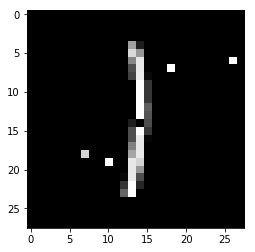

The classification label following attack is 5 from an original classification of 1
The L0 distance of the adversary is 0.006377551020408163


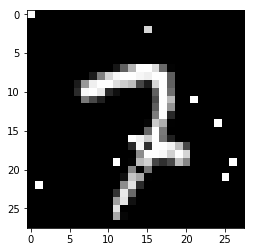

The classification label following attack is 2 from an original classification of 7
The L0 distance of the adversary is 0.016581632653061226


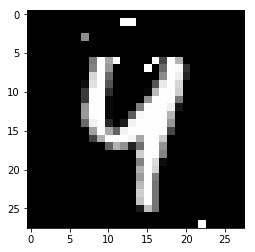

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.008928571428571428


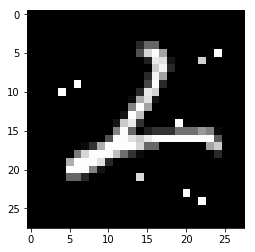

The classification label following attack is 1 from an original classification of 2
The L0 distance of the adversary is 0.01020408163265306


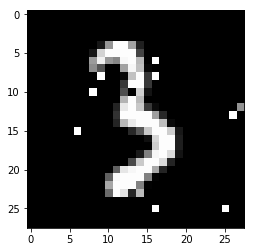

The classification label following attack is 5 from an original classification of 3
The L0 distance of the adversary is 0.01403061224489796


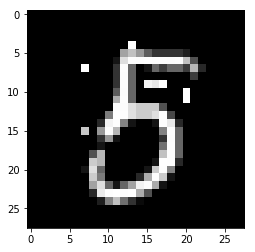

The classification label following attack is 3 from an original classification of 5
The L0 distance of the adversary is 0.01020408163265306


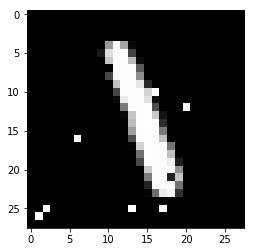

The classification label following attack is 3 from an original classification of 1
The L0 distance of the adversary is 0.011479591836734694


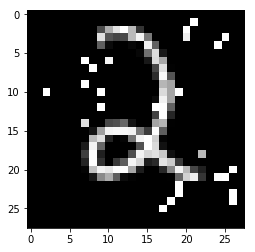

The classification label following attack is 5 from an original classification of 2
The L0 distance of the adversary is 0.03316326530612245


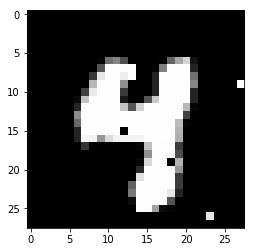

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.008928571428571428


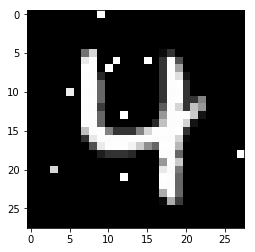

The classification label following attack is 9 from an original classification of 4
The L0 distance of the adversary is 0.011479591836734694


In [73]:
adversary_found, adversary_distance, adversary_arrays = evaluate_l0_PointWiseAttack_resistance_CustomModel(
    model_prediction_function=cnn_binding_predictions, model_weights="/Binding_CNN.ckpt", var_list=var_list_Binding,
    num_images_to_attack=num_images_to_attack, temp_batch_size=1)

In [74]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
mean_distance_successful_attacks = np.sum(adversary_distance)/np.sum(adversary_found)

print("The success ratio is " + str(success_ratio))
print("The mean distance is " + str(mean_distance_successful_attacks))


The success ratio is 1.0
The mean distance is 0.0164030612244898


The Point-Wise attack is able to achieve 100% misclassification against the binding CNN with a mean l-0 distance of 0.0147. This is a smaller distance than that required against the standard CNN, arguing against increased adversarial resistance. Note these results were obtained from 100 images. 

##Basic Iterative (Gradient-Based) Attack

L-infinity minimising, gradient based method.

###BIM Attack Functions for the TensorFlow Models

In [0]:
# *** this code can eventually be refractored with earlier functions

#Function used to attack an arbitrary model that has been implemented with TensorFlow's low-level API (i.e. requires a session to be called explicitly)
def BIM_Attack_customTensorFlowModel(model_prediction_function, model_weights, var_list, test_image, test_label, temp_batch_size, keep_prob, distance_metric):

    images = x #x is a place-holder for 28x28 images earlier defined
    logits = model_prediction_function(images, temp_batch_size, keep_prob)

    saver = tf.train.Saver(var_list) #Define saver object for use later when loading the model weights

    #Note how when attacking a low-level TensorFlow API model, it is necessary for all steps to occur within the tf.Session()
    with tf.Session() as session:
        saver.restore(session, model_weights)

        #Define the foolbox model
        fmodel = foolbox.models.TensorFlowModel(images, logits, (0,1)) #The final parameter specifies the input values range

        #The predicted label of the network prior to carrying out the attack
        pre_label = np.argmax(fmodel.predictions(test_image[:, :, :]))
        #print("The classification label prior to attack is " + str(pre_label))
        if (pre_label != test_label):
            print("The model predicted a " + str(pre_label) + " when the ground-truth label is " + str(test_label))
            plt.imshow(test_image[:,:,0], cmap='gray')

        #Carry out the untargeted Bounary Attack
        attack_fmodel = foolbox.attacks.LinfinityBasicIterativeAttack(model=fmodel, criterion=foolbox.criteria.Misclassification(),
                                                                     distance=distance_metric)
        adversarial_image_fmodel = attack_fmodel(test_image, test_label, epsilon=0.001)
        plt.imshow(adversarial_image_fmodel[:,:,0], cmap='gray')
        plt.show()
        
        #Check the output of the adversarial attack
        adversarial_label_fmodel = np.argmax(fmodel.predictions(adversarial_image_fmodel[:, :, :]))
        print("The classification label following attack is " + str(adversarial_label_fmodel) 
              + " from an original classification of " + str(test_label))
        
        return adversarial_image_fmodel, adversarial_label_fmodel

In [0]:
# *** this code can eventually be refractored with earlier functions

#Iterate through a series of images to be attacked
def evaluate_BIM_Attack_resistance_CustomModel(model_prediction_function, model_weights, 
                                                              var_list, num_images_to_attack, temp_batch_size, distance_metric):
    adversary_found = np.zeros([num_images_to_attack]) #array of booleans that indicates if an adversary was found for a particular image
    adversary_distance = np.zeros([num_images_to_attack])
    adversary_arrays = np.zeros([num_images_to_attack, testing_data.shape[1], testing_data.shape[2], 1])

    for ii in range(num_images_to_attack):
        test_image = testing_data[ii, :, :]
        test_label = np.argmax(testing_labels[ii,:])

        adversarial_image_fmodel, adversarial_classification = BIM_Attack_customTensorFlowModel(model_prediction_function, 
                                                                                                     model_weights, var_list, 
                                                                                                     test_image, test_label, 
                                                                                                     temp_batch_size,
                                                                                                     keep_prob=1.0,
                                                                                               distance_metric=distance_metric)
        adversary_arrays[ii, :, :] = adversarial_image_fmodel

        if distance_metric == foolbox.distances.Linfinity:
            l_inf_distance = scipy.spatial.distance.chebyshev(test_image.flatten(), adversarial_image_fmodel.flatten())
            print("The L-Infinite distance of the adversary is " + str(l_inf_distance))
            adversary_found[ii] = 1
            adversary_distance[ii] = l_inf_distance
        else:
            l2_distance = scipy.spatial.distance.euclidean(test_image.flatten(), adversarial_image_fmodel.flatten())
            print("The L2 distance of the adversary is " + str(l2_distance))
            adversary_found[ii] = 1
            adversary_distance[ii] = l2_distance
            
    return adversary_found, adversary_distance, adversary_arrays

###Visualize the BIM Attack

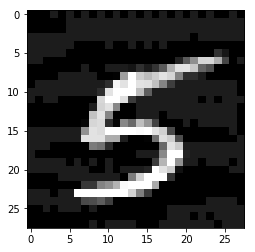

The classification label following attack is 3 from an original classification of 5


In [89]:
#An example of the attack
adversarial_image_fmodel, adversarial_label_fmodel = BIM_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                                                 model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                                                var_list=var_list_LeNet,
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=None,
                                                                                     keep_prob=1.0,
                                                                                     distance_metric=foolbox.distances.Linfinity)


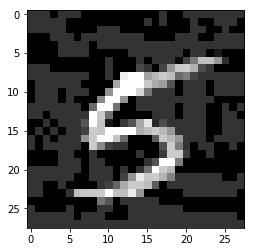

The classification label following attack is 9 from an original classification of 5


In [90]:
adversarial_image_fmodel, adversarial_label_fmodel = BIM_Attack_customTensorFlowModel(model_prediction_function=cnn_binding_predictions,
                                                                 model_weights="/Binding_CNN.ckpt",
                                                                  var_list=var_list_Binding,
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=1,
                                                                                     keep_prob=1.0,
                                                                                     distance_metric=foolbox.distances.Linfinity)


###Quantify Vulnerability to a L-2 Distance Based Attack

In [0]:
num_images_to_attack=50

W0621 12:45:12.165571 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


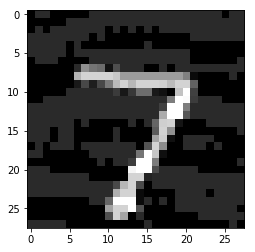

The classification label following attack is 9 from an original classification of 7
The L2 distance of the adversary is 3.5748396978389176


W0621 12:45:21.401707 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


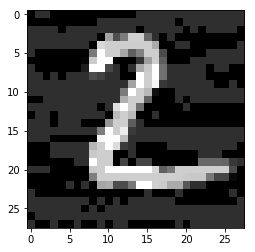

The classification label following attack is 6 from an original classification of 2
The L2 distance of the adversary is 4.106925151572696


W0621 12:45:30.592170 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


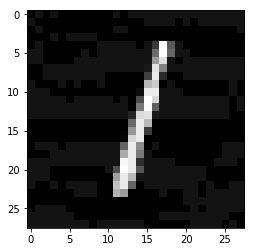

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 1.544525548109056


W0621 12:45:39.712729 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


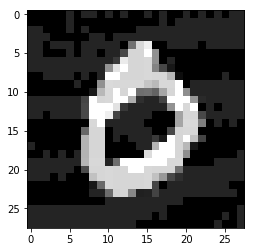

The classification label following attack is 6 from an original classification of 0
The L2 distance of the adversary is 3.2106824780165093


W0621 12:45:48.837566 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


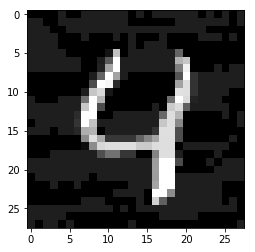

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 2.494276045247957


W0621 12:45:58.133491 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


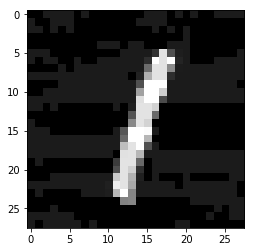

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 2.12316366087094


W0621 12:46:07.422955 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


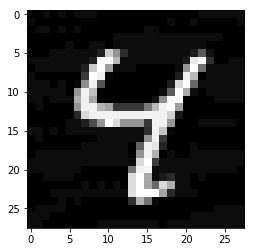

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 0.9848749867713801


W0621 12:46:16.696309 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


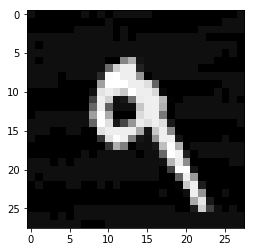

The classification label following attack is 4 from an original classification of 9
The L2 distance of the adversary is 1.353909080935473


W0621 12:46:25.988227 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


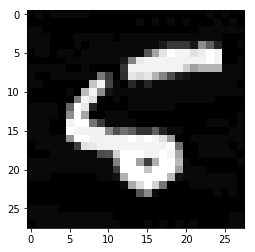

The classification label following attack is 6 from an original classification of 5
The L2 distance of the adversary is 0.7847048785547521


W0621 12:46:35.214195 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


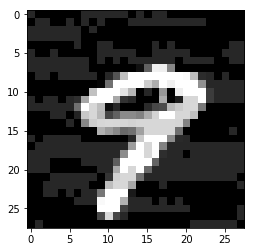

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 3.1085602331914326


W0621 12:46:44.520085 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


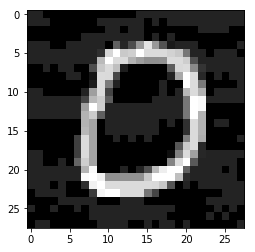

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 2.9228792506629633


W0621 12:46:53.897714 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


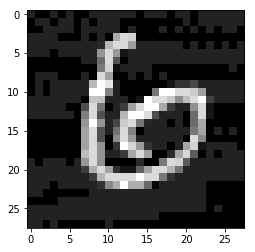

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 3.0058574643086695


W0621 12:47:03.262875 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


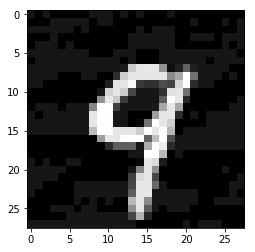

The classification label following attack is 4 from an original classification of 9
The L2 distance of the adversary is 1.7751873202628508


W0621 12:47:12.729765 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


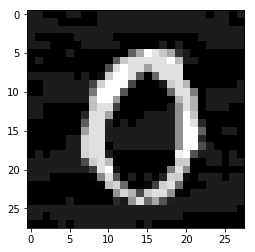

The classification label following attack is 9 from an original classification of 0
The L2 distance of the adversary is 2.379931548452191


W0621 12:47:22.190392 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


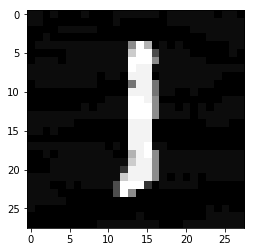

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 0.979160505823443


W0621 12:47:31.643558 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


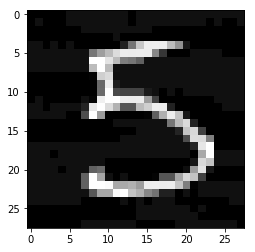

The classification label following attack is 3 from an original classification of 5
The L2 distance of the adversary is 1.3711490633627472


W0621 12:47:41.173459 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


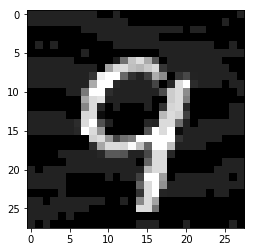

The classification label following attack is 4 from an original classification of 9
The L2 distance of the adversary is 2.7859135267314055


W0621 12:47:50.727623 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


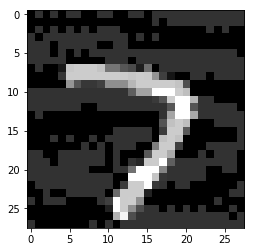

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 4.181810640656094


W0621 12:48:00.352337 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


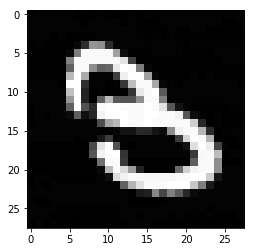

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 0.30669767952278537


W0621 12:48:09.736936 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


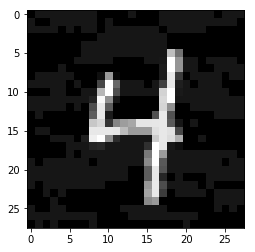

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 1.8753709261168399


W0621 12:48:19.385817 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


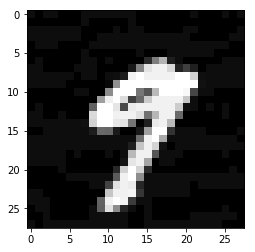

The classification label following attack is 7 from an original classification of 9
The L2 distance of the adversary is 1.1135933857080063


W0621 12:48:28.920954 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


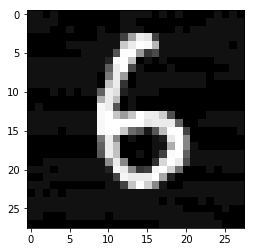

The classification label following attack is 5 from an original classification of 6
The L2 distance of the adversary is 1.5041414040463927


W0621 12:48:38.784641 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


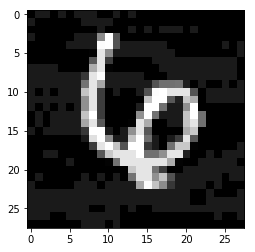

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 2.0902212021730353


W0621 12:48:48.401312 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


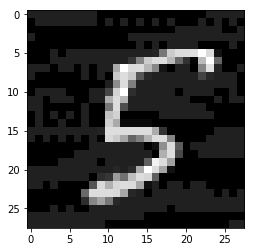

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 2.8083671759443476


W0621 12:48:58.310978 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


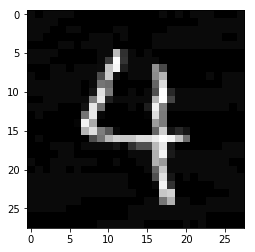

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 0.8656608697276563


W0621 12:49:08.019398 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


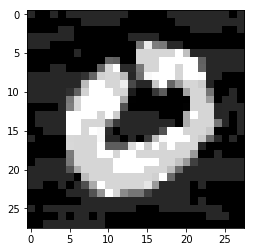

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 3.3078227754217027


W0621 12:49:17.866525 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


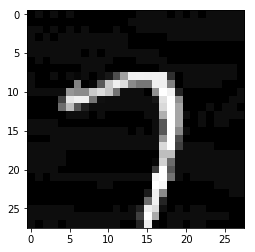

The classification label following attack is 9 from an original classification of 7
The L2 distance of the adversary is 1.1075841337492986


W0621 12:49:27.725554 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


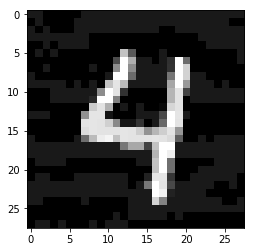

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 2.1129886545992695


W0621 12:49:37.606569 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


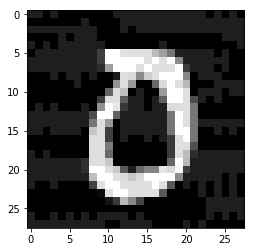

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 2.466937498751006


W0621 12:49:47.582003 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


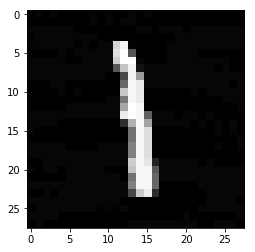

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 0.5595728298404196


W0621 12:49:57.333375 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


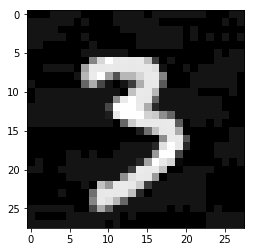

The classification label following attack is 9 from an original classification of 3
The L2 distance of the adversary is 1.7024583078005318


W0621 12:50:07.354390 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


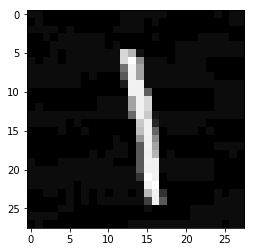

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 0.9543634726491067


W0621 12:50:17.288408 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


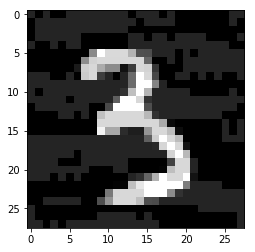

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 3.1775391786859406


W0621 12:50:27.216493 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


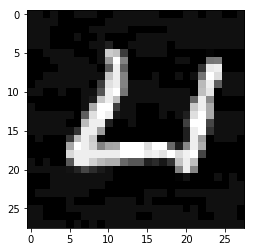

The classification label following attack is 6 from an original classification of 4
The L2 distance of the adversary is 1.4033231778844788


W0621 12:50:37.229849 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


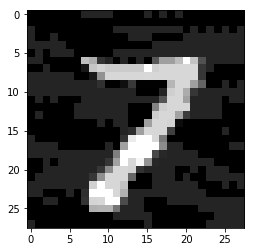

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 3.053847328124616


W0621 12:50:47.159589 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


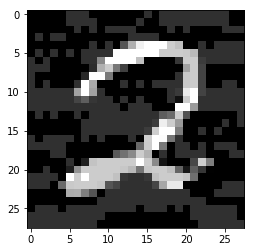

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 4.072549060764311


W0621 12:50:57.253706 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


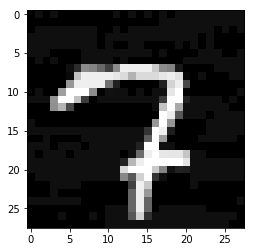

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 1.2918334232363762


W0621 12:51:07.249757 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


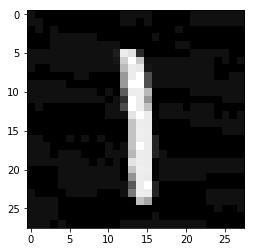

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 1.2707837182720576


W0621 12:51:17.355190 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


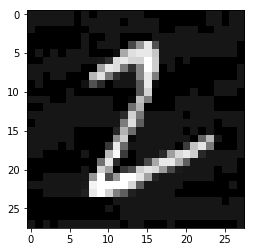

The classification label following attack is 1 from an original classification of 2
The L2 distance of the adversary is 1.959145557822897


W0621 12:51:27.519449 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


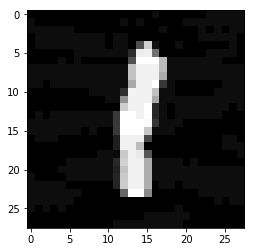

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 1.0476572398518464


W0621 12:51:37.698457 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


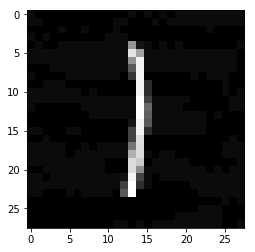

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 0.8701688034994655


W0621 12:51:47.760426 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


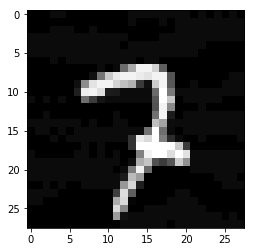

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 0.925497870807278


W0621 12:51:57.888420 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


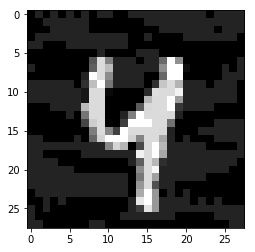

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 2.9441673573838267


W0621 12:52:07.995847 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


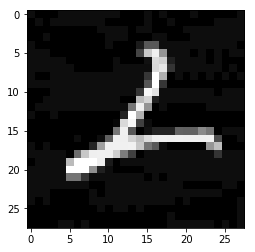

The classification label following attack is 1 from an original classification of 2
The L2 distance of the adversary is 1.149523102027162


W0621 12:52:18.291753 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


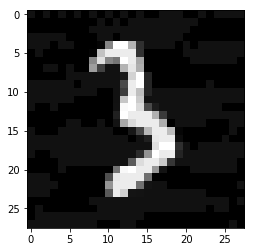

The classification label following attack is 2 from an original classification of 3
The L2 distance of the adversary is 1.4741208836116515


W0621 12:52:28.532520 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


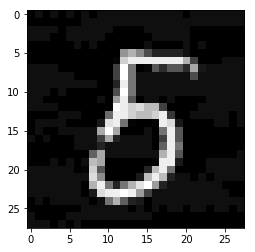

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 1.3201467673473977


W0621 12:52:38.768687 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


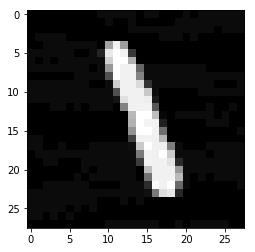

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 0.8653306244535466


W0621 12:52:48.956584 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


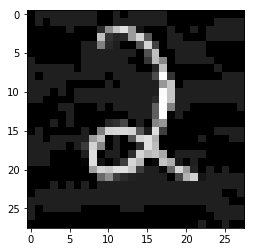

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 2.607514174654194


W0621 12:52:59.380865 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


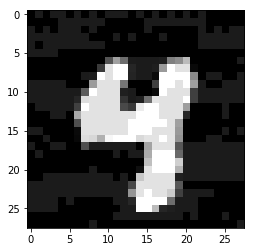

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 2.1477180579189445


W0621 12:53:09.610745 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


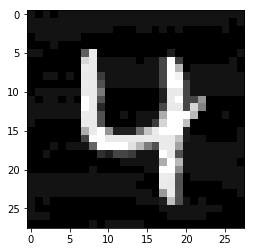

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 1.5591752721841308


In [101]:
adversary_found, adversary_distance, adversary_arrays = evaluate_BIM_Attack_resistance_CustomModel(model_prediction_function=cnn_predictions, 
                                                                                                   model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                                                                                   var_list=var_list_LeNet,
                                                                                                   num_images_to_attack=num_images_to_attack, 
                                                                                                   temp_batch_size=None,
                                                                                                  distance_metric=foolbox.distances.MeanSquaredDistance)

In [102]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
Standard_mean, Standard_var, Standard_std = scipy.stats.bayes_mvs(adversary_distance)

print("The success ratio is " + str(success_ratio))
print("Mean: " + str(Standard_mean))
print("Variance: " + str(Standard_var))
print("Standard deviation: " + str(Standard_std))


The success ratio is 1.0
Mean: Mean(statistic=1.9720834599190002, minmax=(1.733908002530877, 2.210258917307123))
Variance: Variance(statistic=1.0520315399397713, minmax=(0.7453495545154287, 1.4572660480302089))
Standard deviation: Std_dev(statistic=1.0202450051386964, minmax=(0.8633362928288308, 1.207172749870626))


W0621 12:53:20.154355 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


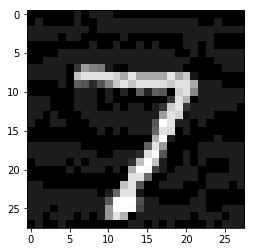

The classification label following attack is 3 from an original classification of 7
The L2 distance of the adversary is 2.471655215805872


W0621 12:53:31.296267 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


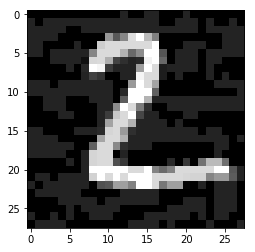

The classification label following attack is 1 from an original classification of 2
The L2 distance of the adversary is 2.9732056050812363


W0621 12:53:42.568461 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


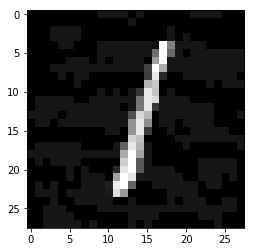

The classification label following attack is 5 from an original classification of 1
The L2 distance of the adversary is 1.6999977354808091


W0621 12:53:53.900972 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


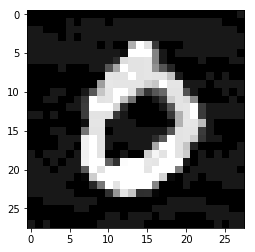

The classification label following attack is 6 from an original classification of 0
The L2 distance of the adversary is 1.9851138233975627


W0621 12:54:05.119817 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


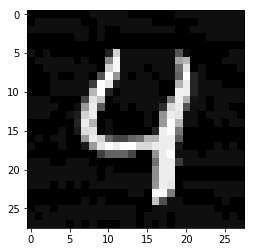

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 1.2626984366840215


W0621 12:54:16.448117 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


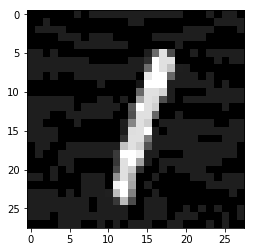

The classification label following attack is 7 from an original classification of 1
The L2 distance of the adversary is 2.445242990666529


W0621 12:54:28.982878 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


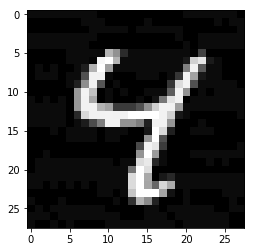

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 0.9214945599380897


W0621 12:54:40.276391 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


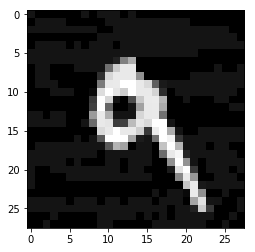

The classification label following attack is 5 from an original classification of 9
The L2 distance of the adversary is 1.7504366862445417


W0621 12:54:51.518518 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


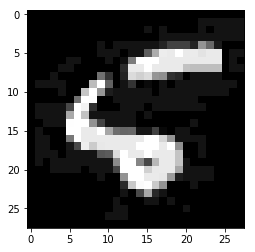

The classification label following attack is 6 from an original classification of 5
The L2 distance of the adversary is 1.355938534458824


W0621 12:55:02.836838 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


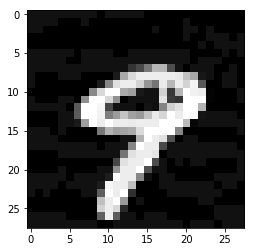

The classification label following attack is 4 from an original classification of 9
The L2 distance of the adversary is 1.4020497133276342


W0621 12:55:14.340475 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


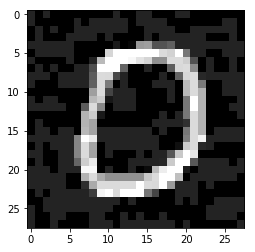

The classification label following attack is 2 from an original classification of 0
The L2 distance of the adversary is 2.91905572100073


W0621 12:55:25.823596 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


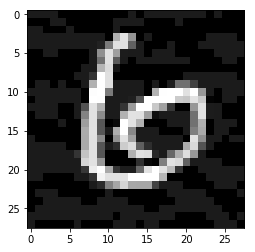

The classification label following attack is 5 from an original classification of 6
The L2 distance of the adversary is 2.298489922592622


W0621 12:55:37.568369 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


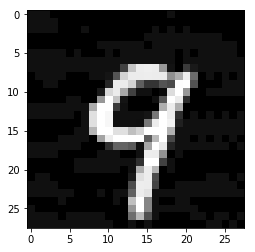

The classification label following attack is 4 from an original classification of 9
The L2 distance of the adversary is 1.3328043329467043


W0621 12:55:49.252222 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


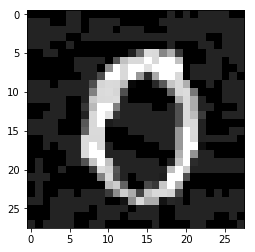

The classification label following attack is 9 from an original classification of 0
The L2 distance of the adversary is 2.9815739829619083


W0621 12:56:01.035711 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


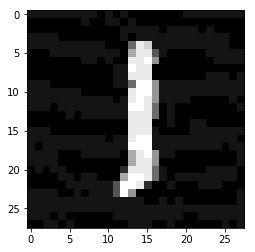

The classification label following attack is 5 from an original classification of 1
The L2 distance of the adversary is 1.6599008124235342


W0621 12:56:12.847704 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


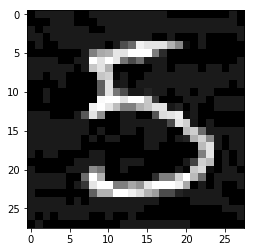

The classification label following attack is 3 from an original classification of 5
The L2 distance of the adversary is 2.228880410389122


W0621 12:56:24.730421 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


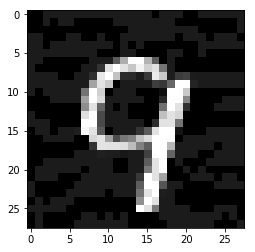

The classification label following attack is 7 from an original classification of 9
The L2 distance of the adversary is 2.238136035334098


W0621 12:56:36.580346 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


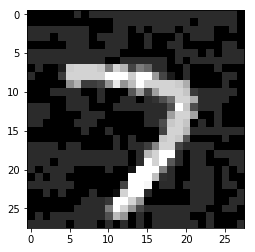

The classification label following attack is 9 from an original classification of 7
The L2 distance of the adversary is 3.6223858584270943
The model predicted a 5 when the ground-truth label is 3


/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:129: UserWarning: Not running the attack because the original input is already misclassified and the adversarial thus has a distance of 0.
  warnings.warn('Not running the attack because the original input'


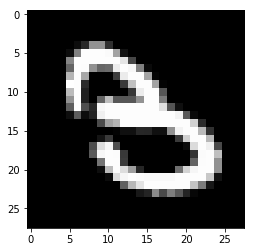

The classification label following attack is 5 from an original classification of 3
The L2 distance of the adversary is 0.0


W0621 12:56:58.183046 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


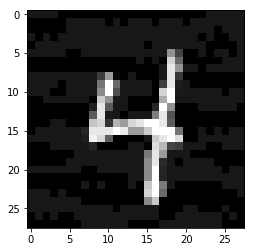

The classification label following attack is 7 from an original classification of 4
The L2 distance of the adversary is 1.948508689639647


W0621 12:57:10.043750 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


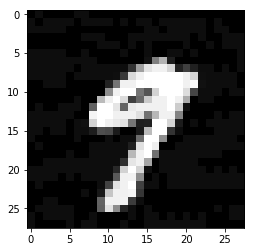

The classification label following attack is 7 from an original classification of 9
The L2 distance of the adversary is 1.106535576185767


W0621 12:57:21.897379 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


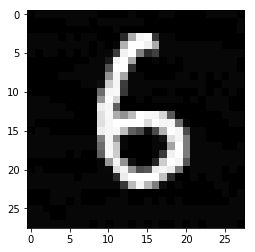

The classification label following attack is 5 from an original classification of 6
The L2 distance of the adversary is 0.6286607707532503


W0621 12:57:33.791707 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


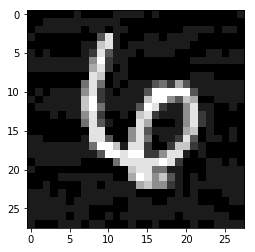

The classification label following attack is 5 from an original classification of 6
The L2 distance of the adversary is 2.316662776920482


W0621 12:57:45.922779 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


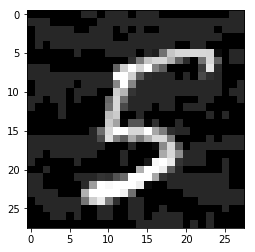

The classification label following attack is 3 from an original classification of 5
The L2 distance of the adversary is 3.1948572162744187


W0621 12:57:58.107918 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


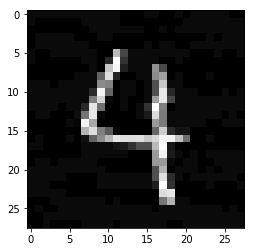

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 0.9229210243483712


W0621 12:58:10.258881 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


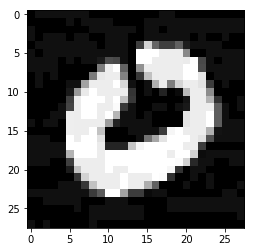

The classification label following attack is 6 from an original classification of 0
The L2 distance of the adversary is 1.3735924106180195


W0621 12:58:22.481472 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


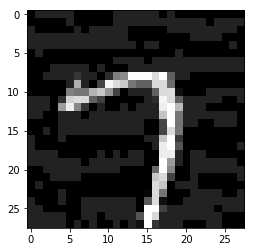

The classification label following attack is 9 from an original classification of 7
The L2 distance of the adversary is 2.7439433266479782


W0621 12:58:35.091380 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


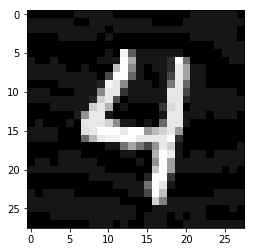

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 1.8801144335783746


W0621 12:58:47.417291 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


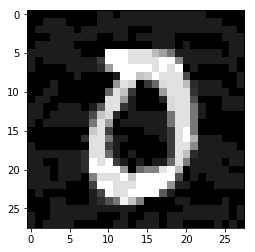

The classification label following attack is 2 from an original classification of 0
The L2 distance of the adversary is 2.405696448885558


W0621 12:59:00.149566 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


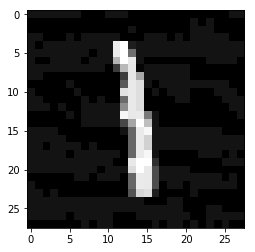

The classification label following attack is 3 from an original classification of 1
The L2 distance of the adversary is 1.5429345697298027


W0621 12:59:12.713382 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


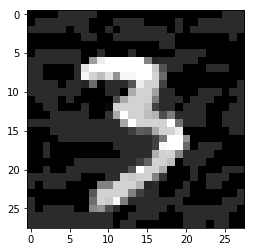

The classification label following attack is 7 from an original classification of 3
The L2 distance of the adversary is 3.58580899912565


W0621 12:59:25.305889 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


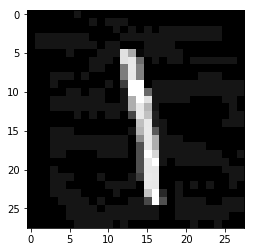

The classification label following attack is 5 from an original classification of 1
The L2 distance of the adversary is 1.5799197994558931


W0621 12:59:37.836669 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


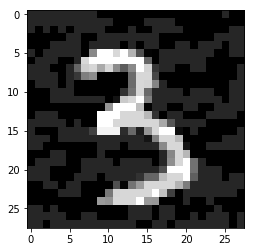

The classification label following attack is 7 from an original classification of 3
The L2 distance of the adversary is 3.166677359322349


W0621 12:59:50.509139 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


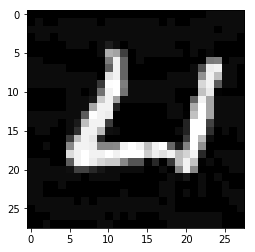

The classification label following attack is 0 from an original classification of 4
The L2 distance of the adversary is 1.0920322197129864


W0621 13:00:03.140074 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


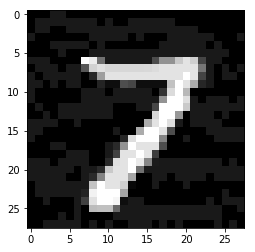

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 2.052899320271922


W0621 13:00:15.793493 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


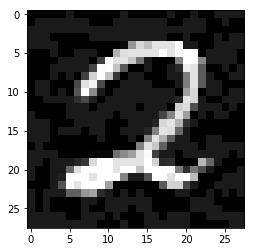

The classification label following attack is 1 from an original classification of 2
The L2 distance of the adversary is 2.2010700671614347


W0621 13:00:28.527606 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


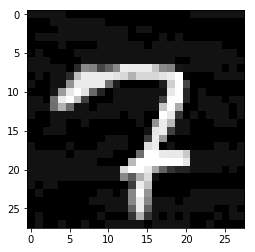

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 1.5087999074530076


W0621 13:00:41.250793 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


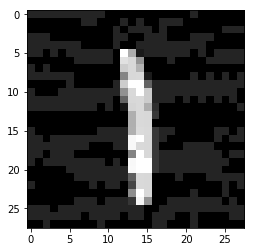

The classification label following attack is 5 from an original classification of 1
The L2 distance of the adversary is 2.823066950942912


W0621 13:00:54.178611 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


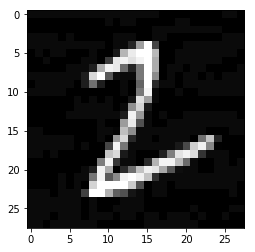

The classification label following attack is 1 from an original classification of 2
The L2 distance of the adversary is 0.8471903667281903


W0621 13:01:06.957824 140430577895296 iterative_projected_gradient.py:221] Running an attack that tries to minimize the Linfinity norm of the perturbation without specifying foolbox.distances.Linfinity as the distance metric might lead to suboptimal results.


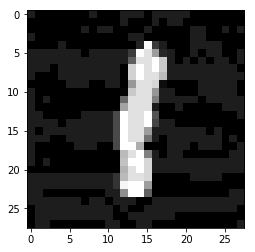

The classification label following attack is 3 from an original classification of 1
The L2 distance of the adversary is 2.328686802144874


In [0]:
adversary_found, adversary_distance, adversary_arrays = evaluate_BIM_Attack_resistance_CustomModel(model_prediction_function=cnn_binding_predictions, 
                                                                                                   model_weights="/Binding_CNN.ckpt", 
                                                                                                   var_list=var_list_Binding,
                                                                                                   num_images_to_attack=num_images_to_attack, 
                                                                                                   temp_batch_size=1,
                                                                                                  distance_metric=foolbox.distances.MeanSquaredDistance)


In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
Standard_mean, Standard_var, Standard_std = scipy.stats.bayes_mvs(adversary_distance)

print("The success ratio is " + str(success_ratio))
print("Mean: " + str(Standard_mean))
print("Variance: " + str(Standard_var))
print("Standard deviation: " + str(Standard_std))


###Quantify Vulnerability to an L-Infinitiy Distance Based Attack

##Blended Uniform Noise Attack

###Blended Uniform Noise Attack Function for the TensorFlow Models

In [0]:
# *** this code can eventually be refractored with earlier functions

#Function used to attack an arbitrary model that has been implemented with TensorFlow's low-level API (i.e. requires a session to be called explicitly)
def BlendedUniformNoise_Attack_customTensorFlowModel(model_prediction_function, model_weights, 
                                                     var_list, test_image, test_label, temp_batch_size, keep_prob):

    images = x #x is a place-holder for 28x28 images earlier defined
    logits = model_prediction_function(images, temp_batch_size, keep_prob)

    saver = tf.train.Saver(var_list) #Define saver object for use later when loading the model weights

    #Note how when attacking a low-level TensorFlow API model, it is necessary for all steps to occur within the tf.Session()
    with tf.Session() as session:
        saver.restore(session, model_weights)

        #Define the foolbox model
        fmodel = foolbox.models.TensorFlowModel(images, logits, (0,1)) #The final parameter specifies the input values range

        #The predicted label of the network prior to carrying out the attack
        pre_label = np.argmax(fmodel.predictions(test_image[:, :, :]))
        #print("The classification label prior to attack is " + str(pre_label))
        if (pre_label != test_label):
            print("The model predicted a " + str(pre_label) + " when the ground-truth label is " + str(test_label))
            plt.imshow(test_image[:,:,0], cmap='gray')

        #Carry out the untargeted Bounary Attack
        attack_fmodel = foolbox.attacks.BlendedUniformNoiseAttack(model=fmodel, criterion=foolbox.criteria.Misclassification())
        adversarial_image_fmodel = attack_fmodel(test_image, test_label)
        plt.imshow(adversarial_image_fmodel[:,:,0], cmap='gray')
        plt.show()
        
        #Check the output of the adversarial attack
        adversarial_label_fmodel = np.argmax(fmodel.predictions(adversarial_image_fmodel[:, :, :]))
        print("The classification label following attack is " + str(adversarial_label_fmodel) 
              + " from an original classification of " + str(test_label))
        
        return adversarial_image_fmodel, adversarial_label_fmodel

In [0]:
# *** this code can eventually be refractored with earlier functions

#Iterate through a series of images to be attacked
def evaluate_BlendedUniformNoiseAttack_resistance_CustomModel(model_prediction_function, model_weights, 
                                                              var_list, num_images_to_attack, temp_batch_size):
    adversary_found = np.zeros([num_images_to_attack]) #array of booleans that indicates if an adversary was found for a particular image
    adversary_distance = np.zeros([num_images_to_attack])
    adversary_arrays = np.zeros([num_images_to_attack, testing_data.shape[1], testing_data.shape[2], 1])

    for ii in range(num_images_to_attack):
        test_image = testing_data[ii, :, :]
        test_label = np.argmax(testing_labels[ii,:])

        adversarial_image_fmodel, adversarial_classification = BlendedUniformNoise_Attack_customTensorFlowModel(model_prediction_function, 
                                                                                                     model_weights, var_list, 
                                                                                                     test_image, test_label, 
                                                                                                     temp_batch_size,
                                                                                                     keep_prob=1.0)
        adversary_arrays[ii, :, :] = adversarial_image_fmodel

        if ((np.any(adversarial_image_fmodel == None) | adversarial_classification == test_label)):
            print("No adversarial image found")

        else:
            l2_distance = scipy.spatial.distance.euclidean(test_image.flatten(), adversarial_image_fmodel.flatten())
            print("The L2 distance of the adversary is " + str(l2_distance))
            adversary_found[ii] = 1
            adversary_distance[ii] = l2_distance
        
    return adversary_found, adversary_distance, adversary_arrays

###Blended Uniform Noise Attack Function for the Keras Models

In [0]:
#Function to iterate through a series of images to be attacked
def evaluate_BlendedUniformNoiseAttack_resistance_MadryModel(num_images_to_attack):
    adversary_found = np.zeros([num_images_to_attack]) #array of booleans that indicates if an adversary was found for a particular image
    adversary_distance = np.zeros([num_images_to_attack])
    adversary_arrays = np.zeros([num_images_to_attack, Madry_testing_data.shape[1]])
    
    for ii in range(num_images_to_attack):
        test_image_Madry = Madry_testing_data[ii, :]
        test_label_Madry = np.argmax(Madry_testing_labels[ii,:])

        Madry_attack = foolbox.attacks.BlendedUniformNoiseAttack(model=Madry_model, criterion=foolbox.criteria.Misclassification())
        Madry_adversarial_image = Madry_attack(test_image_Madry, test_label_Madry)
        adversary_arrays[ii, :] = Madry_adversarial_image
        
        # **** need to check this logical statement for accuracy
        if np.any(np.any(Madry_adversarial_image == None) | (Madry_model.predictions(Madry_adversarial_image) == test_label_Madry)):
            print("No adversarial image found")

        else:
            l2_distance = scipy.spatial.distance.euclidean(test_image_Madry, Madry_adversarial_image)
            print("The L2 distance of the adversary is " + str(l2_distance))
            adversary_found[ii] = 1
            adversary_distance[ii] = l2_distance

    return adversary_found, adversary_distance, adversary_arrays


###Visualize the Attack

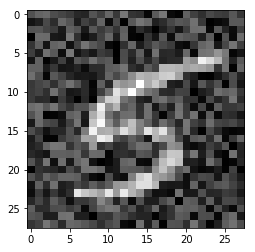

The classification label following attack is 9 from an original classification of 5


In [0]:
#An example of the attack
adversarial_image_fmodel, adversarial_label_fmodel = BlendedUniformNoise_Attack_customTensorFlowModel(model_prediction_function=cnn_predictions,
                                                                 model_weights="/MNIST_LeNet5_CNN.ckpt", 
                                                                var_list=var_list_LeNet,
                                                                 test_image=test_image_LeNet, 
                                                                 test_label=test_label_LeNet,
                                                                 temp_batch_size=None,
                                                                                                     keep_prob=1.0)


###Quantify Vulnerability

In [0]:
num_images_to_attack=75

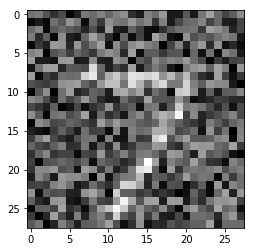

The classification label following attack is 0 from an original classification of 7
The L2 distance of the adversary is 10.093498921656577


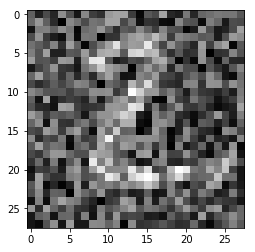

The classification label following attack is 4 from an original classification of 2
The L2 distance of the adversary is 10.012675592882772


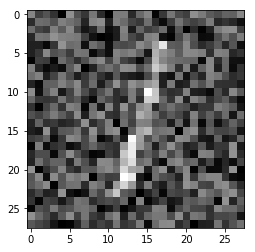

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 9.063729104635609


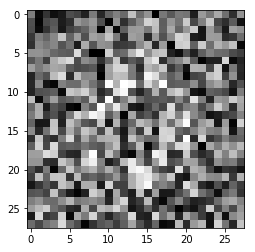

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 12.861495866112692


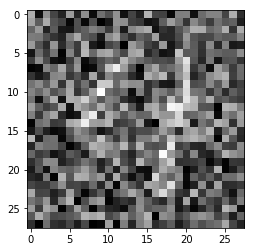

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 10.859299923469827


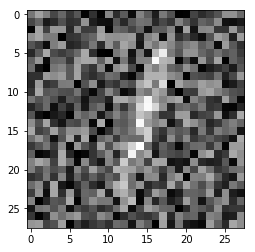

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 9.956147308192323


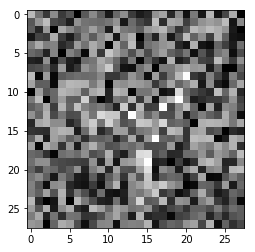

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 11.717123850789138


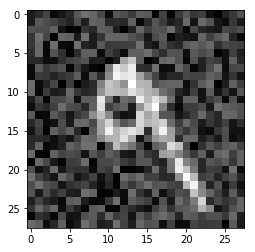

The classification label following attack is 4 from an original classification of 9
The L2 distance of the adversary is 6.908782860454014


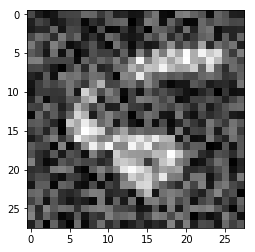

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 8.001818852160836


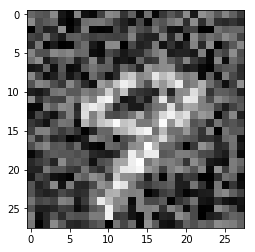

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 8.700889042492715


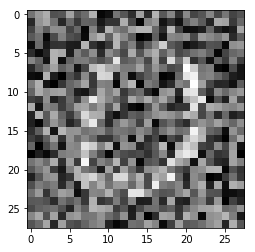

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 11.199089453084992


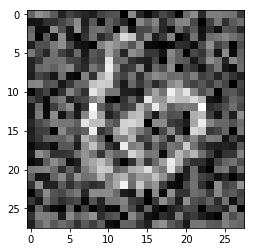

The classification label following attack is 0 from an original classification of 6
The L2 distance of the adversary is 8.642546672769397


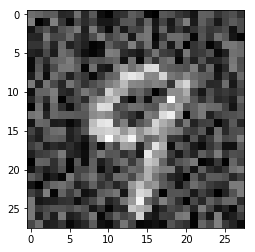

The classification label following attack is 4 from an original classification of 9
The L2 distance of the adversary is 7.703725125783995


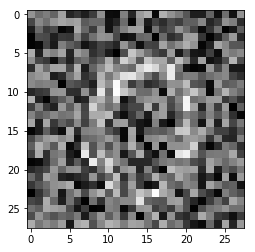

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 11.03287357615449


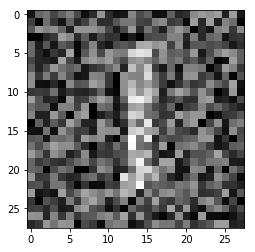

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 10.043504380116623


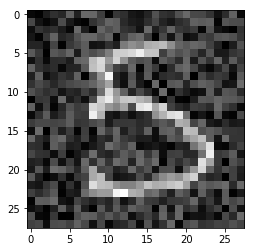

The classification label following attack is 3 from an original classification of 5
The L2 distance of the adversary is 6.482735359022814


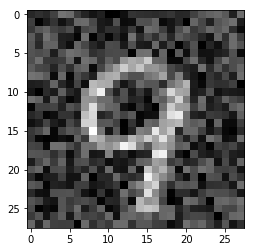

The classification label following attack is 4 from an original classification of 9
The L2 distance of the adversary is 7.124294924098196


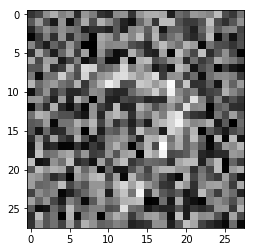

The classification label following attack is 0 from an original classification of 7
The L2 distance of the adversary is 11.8393928612046


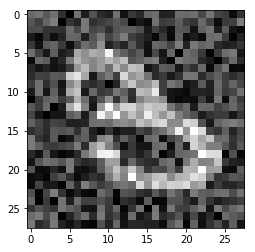

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 7.63978733884153


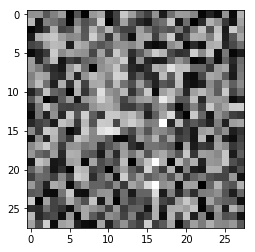

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 12.635153087274215


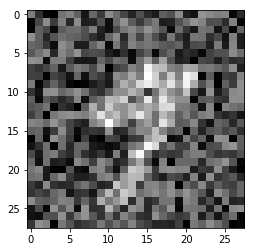

The classification label following attack is 4 from an original classification of 9
The L2 distance of the adversary is 9.429048290087703


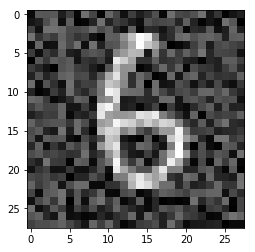

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 7.011161826849466


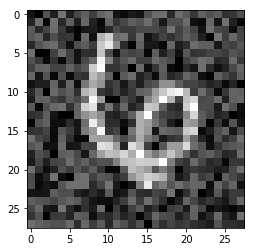

The classification label following attack is 4 from an original classification of 6
The L2 distance of the adversary is 7.0300975531796785


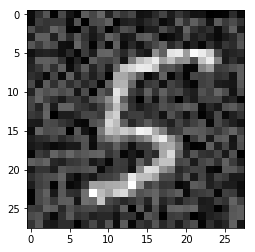

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 6.306701155580897


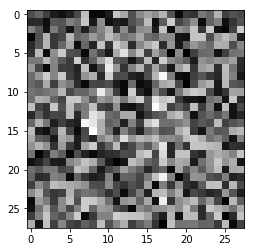

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 11.354626720187266


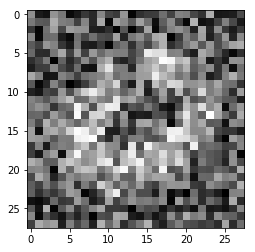

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 10.809810215406152


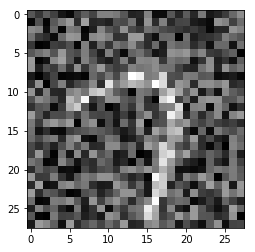

The classification label following attack is 0 from an original classification of 7
The L2 distance of the adversary is 9.218705624455387


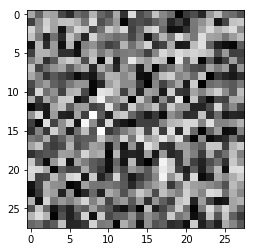

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 13.729023534472892


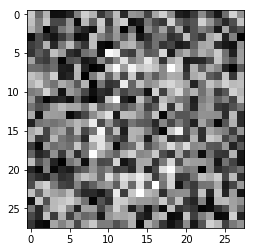

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 12.670549897127366


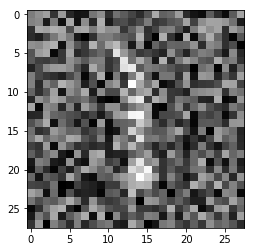

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 10.783145657530657


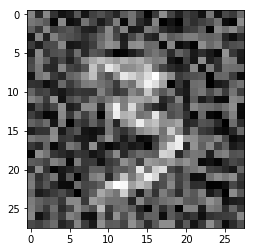

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 8.99629308135272


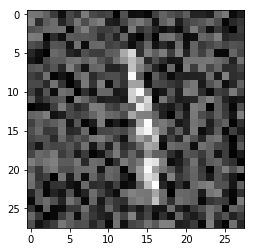

The classification label following attack is 4 from an original classification of 1
The L2 distance of the adversary is 8.175238435892012


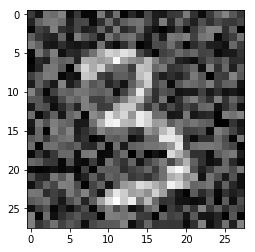

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 8.081814042546215


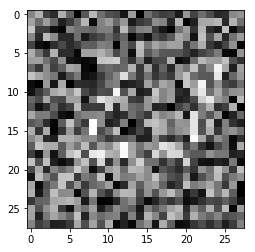

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 12.05543885334069


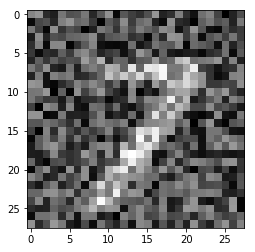

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 9.509400672660428


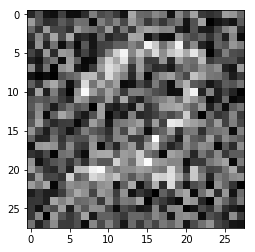

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 10.25590591451446


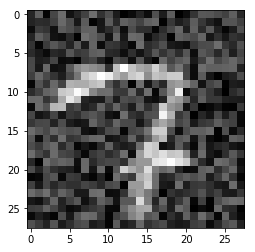

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 6.89031795753308


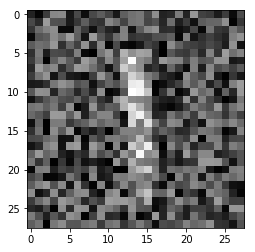

The classification label following attack is 4 from an original classification of 1
The L2 distance of the adversary is 9.753485704824488


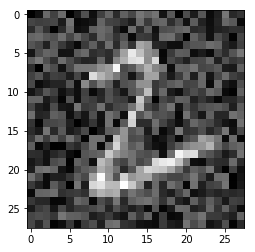

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 7.329347077195394


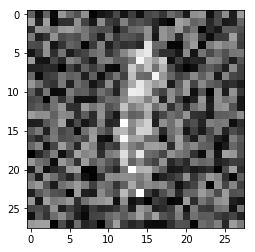

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 9.97901494448243


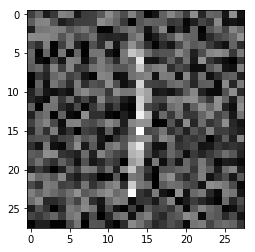

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 8.364965247309026


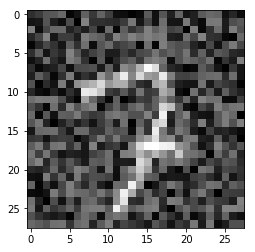

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 8.105287854389852


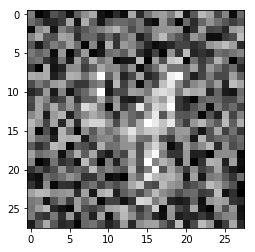

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 10.922500642209283


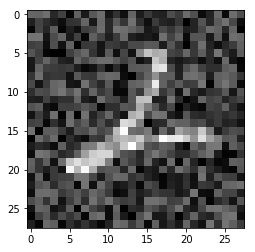

The classification label following attack is 4 from an original classification of 2
The L2 distance of the adversary is 7.278238296909522


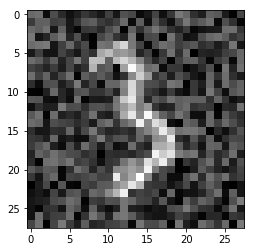

The classification label following attack is 4 from an original classification of 3
The L2 distance of the adversary is 7.44622759190907


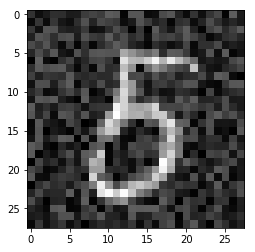

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 5.636184721849951


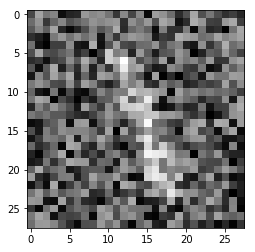

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 10.923949435937674


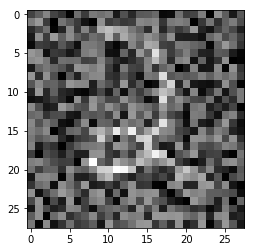

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 9.639096817149067


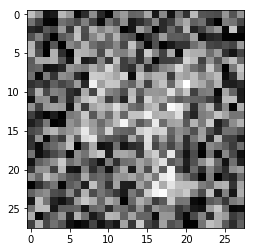

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 11.859265879992153


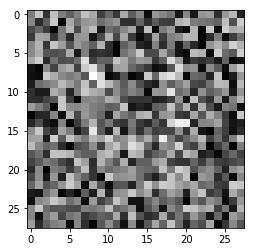

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 12.483356482994811


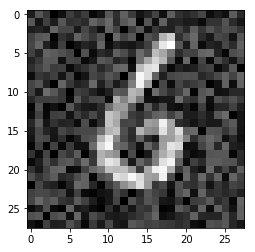

The classification label following attack is 0 from an original classification of 6
The L2 distance of the adversary is 6.302966265539266


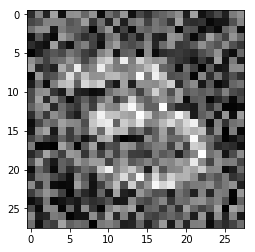

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 9.87645878818874


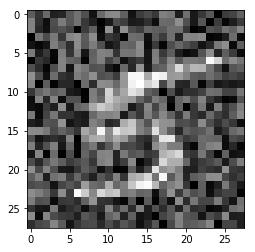

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 8.63945744055799


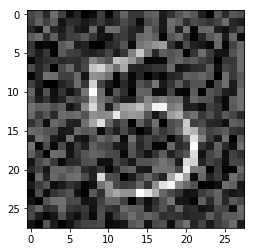

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 7.0079283592851125


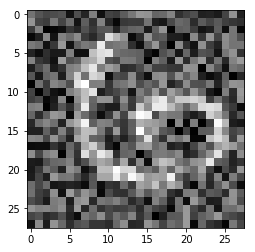

The classification label following attack is 4 from an original classification of 6
The L2 distance of the adversary is 9.42077649171663


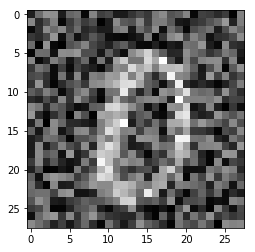

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 9.347785115678022


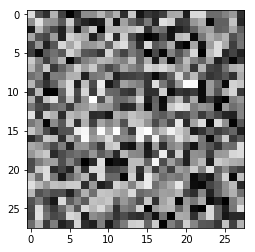

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 13.464213692942126


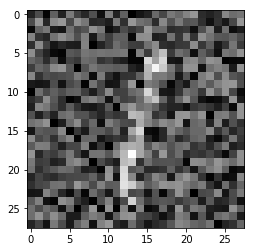

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 9.397142907949979


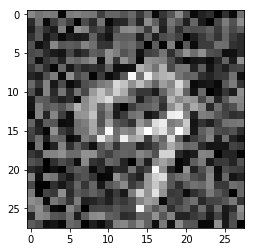

The classification label following attack is 4 from an original classification of 9
The L2 distance of the adversary is 8.724358907648131


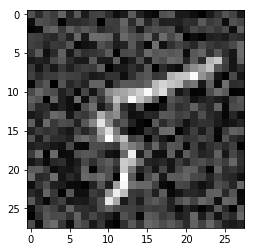

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 6.13290351650419


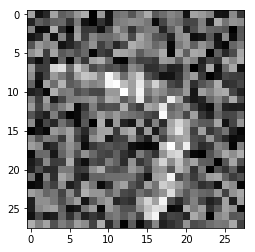

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 10.909560350768366


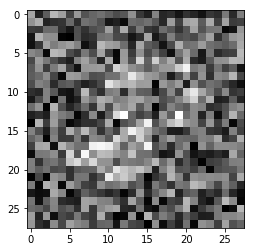

The classification label following attack is 4 from an original classification of 8
The L2 distance of the adversary is 10.989588678370737


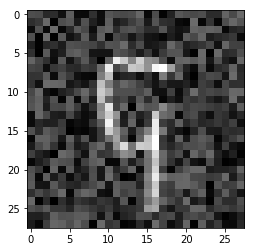

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 6.483974214167198


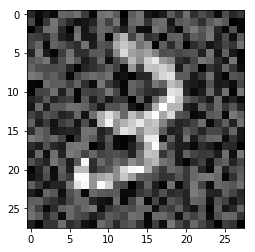

The classification label following attack is 9 from an original classification of 3
The L2 distance of the adversary is 7.354160634684586


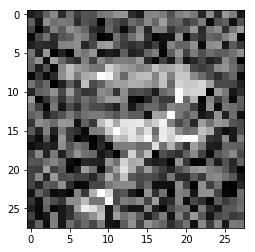

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 9.448004533344719


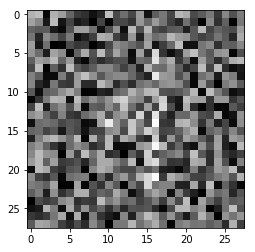

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 11.558748694915053


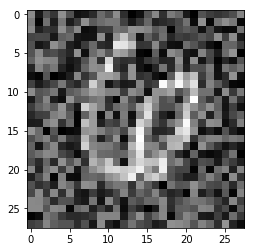

The classification label following attack is 4 from an original classification of 6
The L2 distance of the adversary is 8.762130327343497


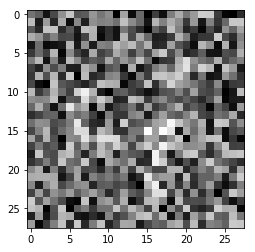

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 11.581830296391557


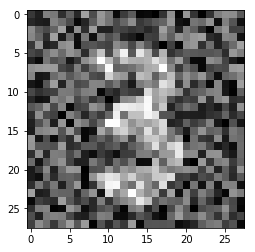

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 9.89815141386124


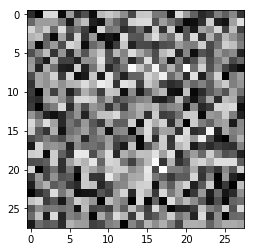

The classification label following attack is 2 from an original classification of 0
The L2 distance of the adversary is 14.112003946257945


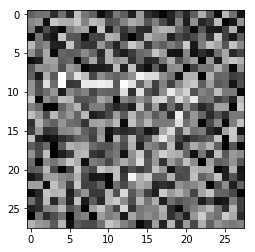

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 12.596816285198393


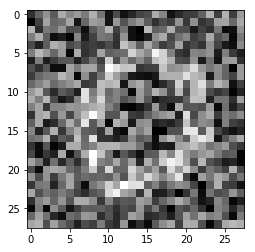

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 11.15644740029356


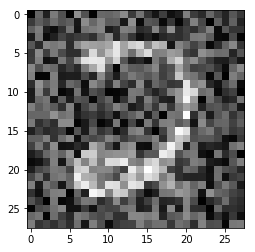

The classification label following attack is 0 from an original classification of 2
The L2 distance of the adversary is 8.60396375467183


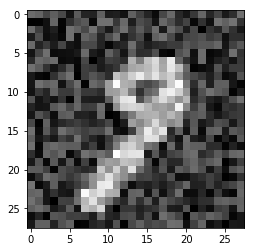

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 7.09208517943325


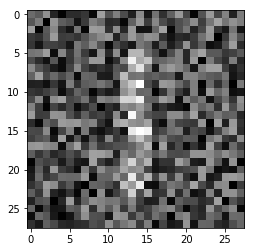

The classification label following attack is 4 from an original classification of 1
The L2 distance of the adversary is 9.855021670474265


In [0]:
adversary_found, adversary_distance, adversary_arrays = evaluate_BlendedUniformNoiseAttack_resistance_CustomModel(
    model_prediction_function=cnn_predictions, model_weights="/MNIST_LeNet5_CNN.ckpt", var_list=var_list_LeNet,
    num_images_to_attack=num_images_to_attack, temp_batch_size=None)

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
Standard_mean, Standard_var, Standard_std = scipy.stats.bayes_mvs(adversary_distance)

print("The success ratio is " + str(success_ratio))
print("Mean: " + str(Standard_mean))
print("Variance: " + str(Standard_var))
print("Standard deviation: " + str(Standard_std))


The success ratio is 1.0
Mean: Mean(statistic=9.510176574630046, minmax=(9.116315117646574, 9.904038031613519))
Variance: Variance(statistic=4.309732226138489, minmax=(3.2635247556856064, 5.622486746031296))
Standard deviation: Std_dev(statistic=2.0687938912334003, minmax=(1.80652283563912, 2.371178345471149))


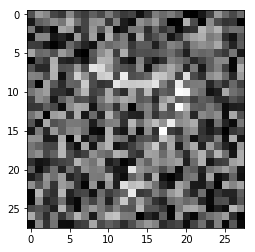

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 10.931427957529465


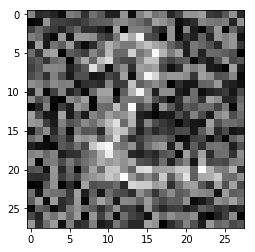

The classification label following attack is 0 from an original classification of 2
The L2 distance of the adversary is 10.19338585407948


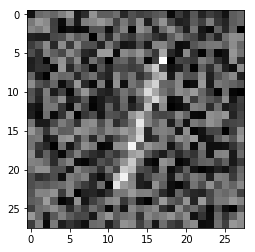

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 9.324088296495637


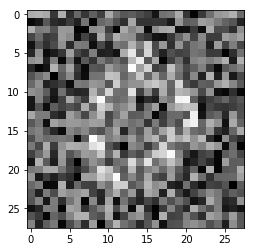

The classification label following attack is 2 from an original classification of 0
The L2 distance of the adversary is 11.046397849621592


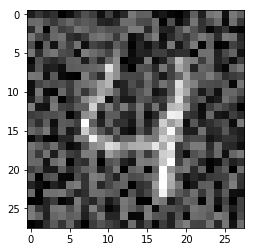

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 7.972106288583642


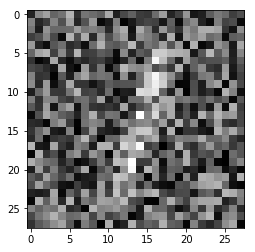

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 11.099735246065004


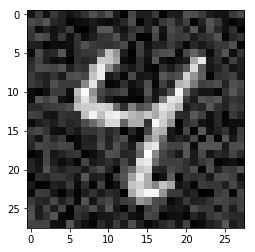

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 5.159497260395026


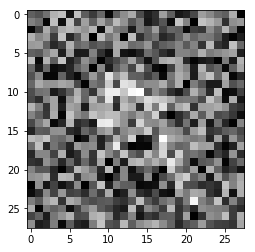

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 11.655840391208441


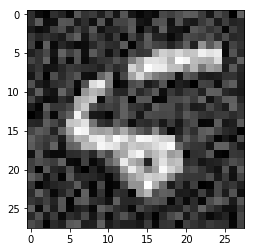

The classification label following attack is 9 from an original classification of 5
The L2 distance of the adversary is 5.982969168988558


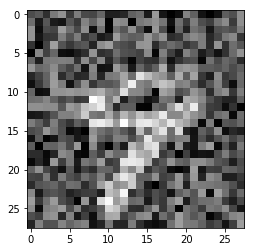

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 9.766887196083914


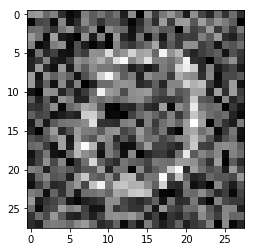

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 9.758090972712832


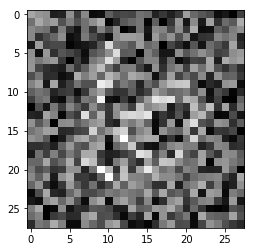

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 10.422289509004829


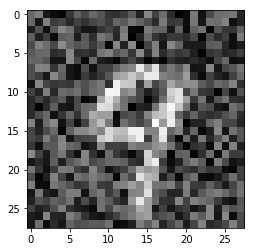

The classification label following attack is 3 from an original classification of 9
The L2 distance of the adversary is 8.04291692780241


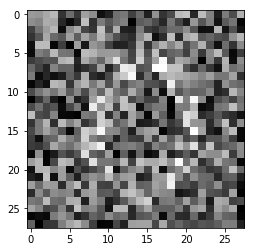

The classification label following attack is 2 from an original classification of 0
The L2 distance of the adversary is 11.67759849191351


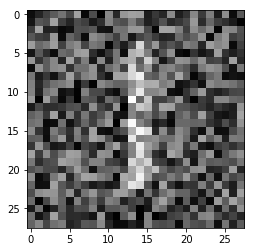

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 10.295520648346745


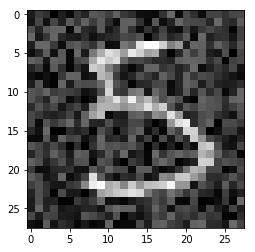

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 6.322388639782053


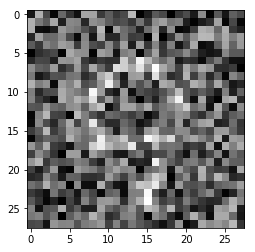

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 11.165770048763818


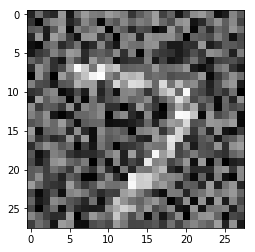

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 10.092127381546472


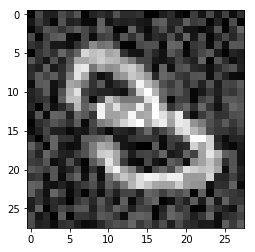

The classification label following attack is 5 from an original classification of 3
The L2 distance of the adversary is 6.252242058921717


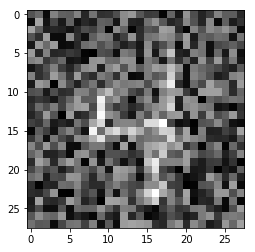

The classification label following attack is 7 from an original classification of 4
The L2 distance of the adversary is 9.916958434399247


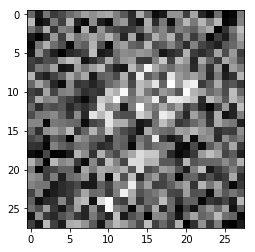

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 11.517604139871922


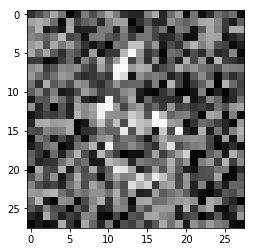

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 10.964991133951592


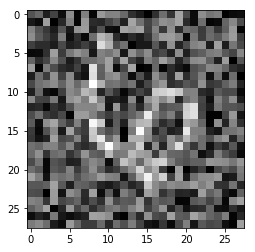

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 9.677949272531489


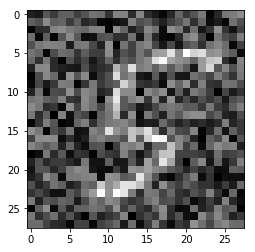

The classification label following attack is 3 from an original classification of 5
The L2 distance of the adversary is 8.864309275117352


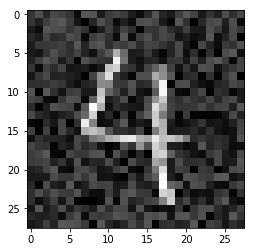

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 5.100118707305516


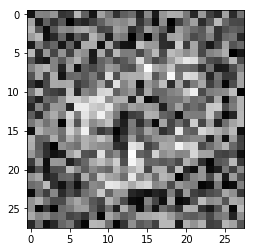

The classification label following attack is 2 from an original classification of 0
The L2 distance of the adversary is 11.888496714851428


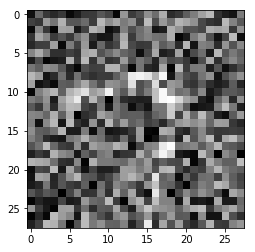

The classification label following attack is 0 from an original classification of 7
The L2 distance of the adversary is 11.135804908012581


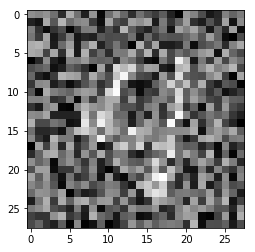

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 10.97638843148977


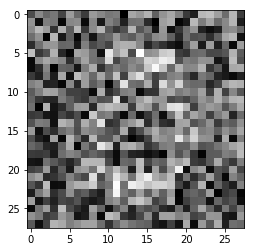

The classification label following attack is 2 from an original classification of 0
The L2 distance of the adversary is 11.74416166916169


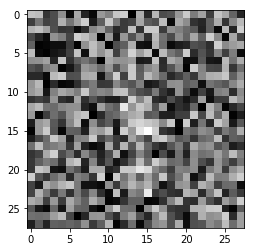

The classification label following attack is 9 from an original classification of 1
The L2 distance of the adversary is 12.461286111417206


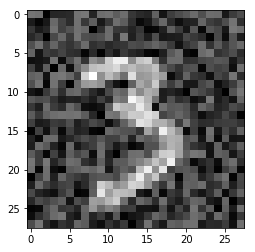

The classification label following attack is 9 from an original classification of 3
The L2 distance of the adversary is 7.552367628324631


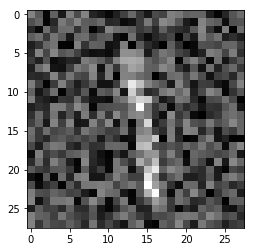

The classification label following attack is 9 from an original classification of 1
The L2 distance of the adversary is 8.62079721080498


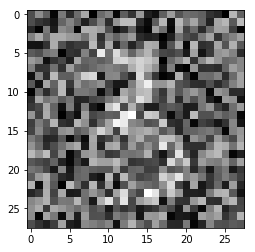

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 11.574165598674776


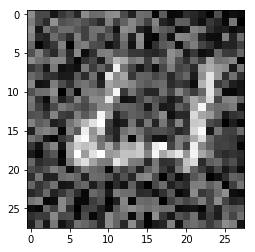

The classification label following attack is 0 from an original classification of 4
The L2 distance of the adversary is 8.297654870526799


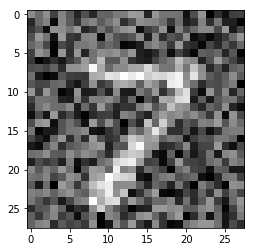

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 9.893247179021254


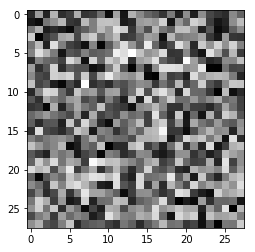

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 13.525929096808955


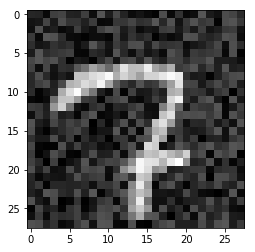

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 5.316076190513428


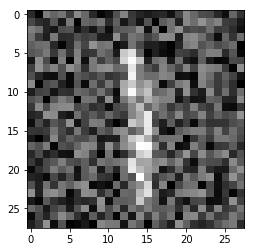

The classification label following attack is 9 from an original classification of 1
The L2 distance of the adversary is 9.15608417078885


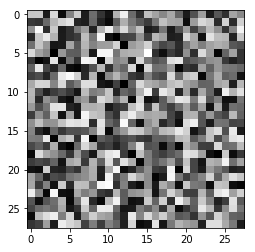

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 14.540718457273654


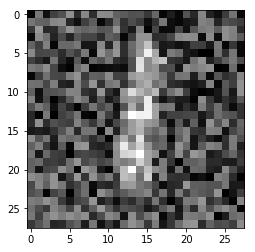

The classification label following attack is 9 from an original classification of 1
The L2 distance of the adversary is 9.375491517810973


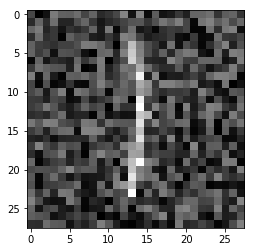

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 7.296704265767999


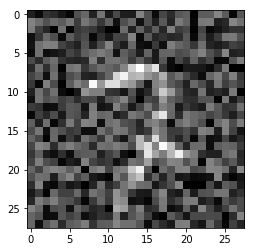

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 8.316109424619777


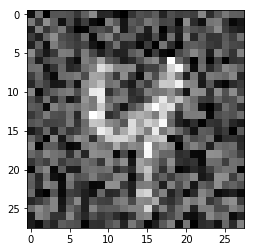

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 8.97303864343434


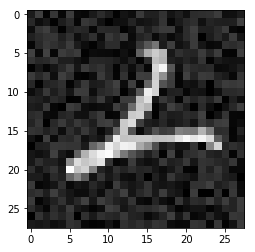

The classification label following attack is 4 from an original classification of 2
The L2 distance of the adversary is 3.9989367625869003


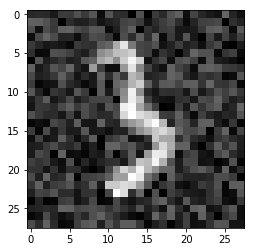

The classification label following attack is 5 from an original classification of 3
The L2 distance of the adversary is 6.033884447121382


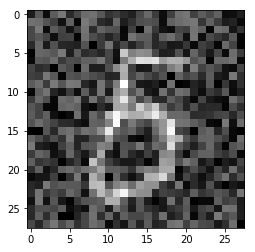

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 7.453076947546839


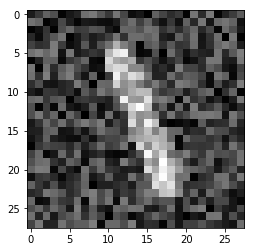

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 7.8109874448481165


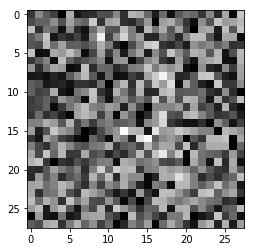

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 12.133653023532824


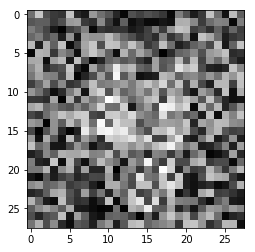

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 12.253737158606063


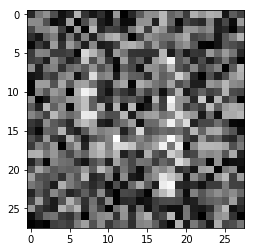

The classification label following attack is 2 from an original classification of 4
The L2 distance of the adversary is 11.169791626341484


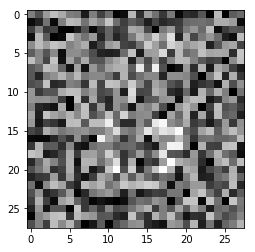

The classification label following attack is 5 from an original classification of 6
The L2 distance of the adversary is 12.27868029252165


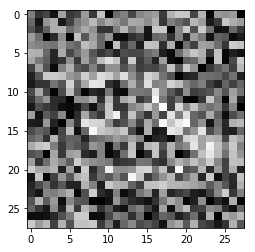

The classification label following attack is 2 from an original classification of 3
The L2 distance of the adversary is 12.2289224766088


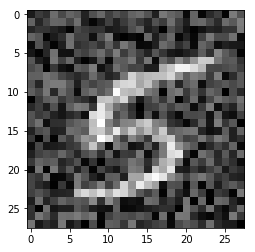

The classification label following attack is 0 from an original classification of 5
The L2 distance of the adversary is 7.32868413429859


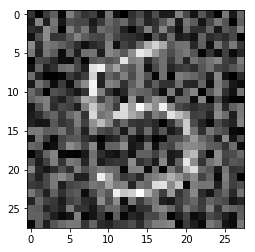

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 8.097669003989415


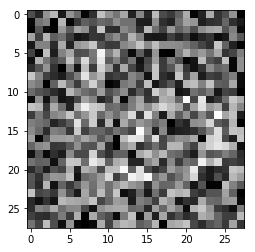

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 12.041887123466127


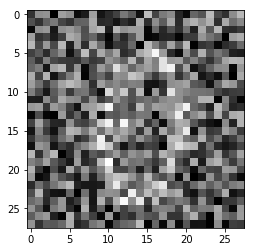

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 11.363074145414368


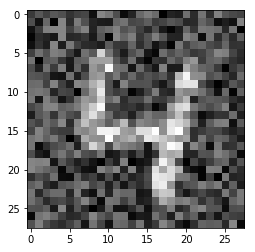

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 8.405247685215807


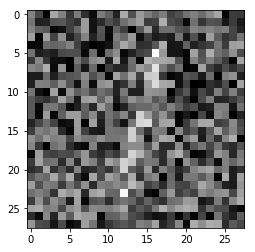

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 10.338297845511018


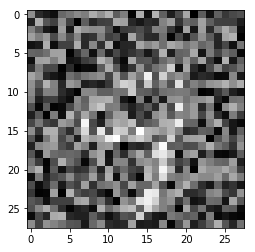

The classification label following attack is 5 from an original classification of 9
The L2 distance of the adversary is 10.799667593774888


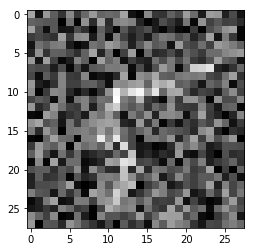

The classification label following attack is 8 from an original classification of 5
The L2 distance of the adversary is 9.547390628970717


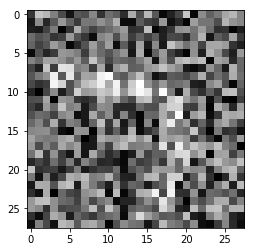

The classification label following attack is 2 from an original classification of 7
The L2 distance of the adversary is 12.071595930914025


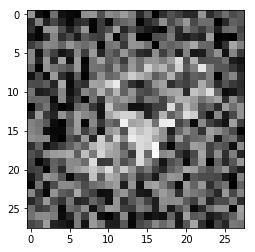

The classification label following attack is 2 from an original classification of 8
The L2 distance of the adversary is 10.18844655891552


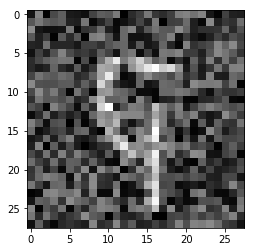

The classification label following attack is 7 from an original classification of 9
The L2 distance of the adversary is 8.104172608486406


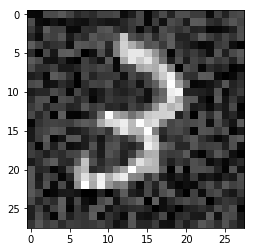

The classification label following attack is 2 from an original classification of 3
The L2 distance of the adversary is 5.818504929797664


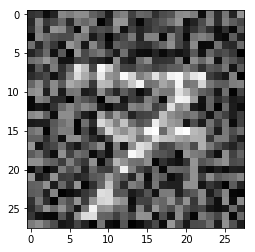

The classification label following attack is 8 from an original classification of 7
The L2 distance of the adversary is 9.160378475238039


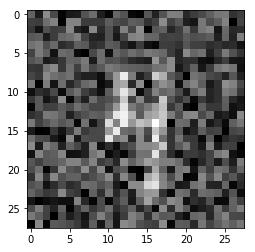

The classification label following attack is 8 from an original classification of 4
The L2 distance of the adversary is 8.305289561182173


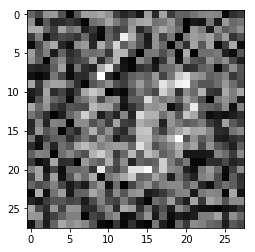

The classification label following attack is 8 from an original classification of 6
The L2 distance of the adversary is 10.336452985483065


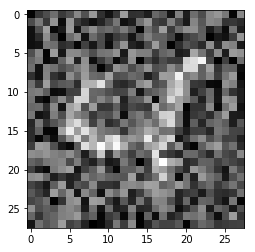

The classification label following attack is 9 from an original classification of 4
The L2 distance of the adversary is 9.661263599067144


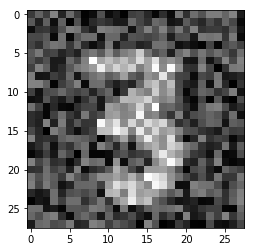

The classification label following attack is 8 from an original classification of 3
The L2 distance of the adversary is 8.320981775088557


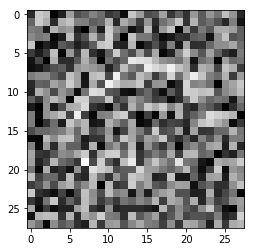

The classification label following attack is 8 from an original classification of 0
The L2 distance of the adversary is 12.37837335525192


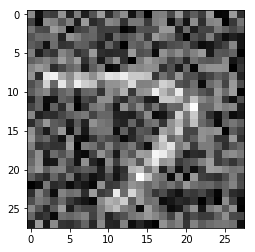

The classification label following attack is 0 from an original classification of 7
The L2 distance of the adversary is 9.86894879178253


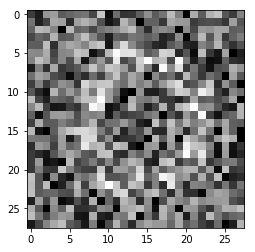

The classification label following attack is 2 from an original classification of 0
The L2 distance of the adversary is 12.145173230988528


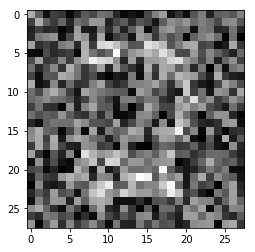

The classification label following attack is 8 from an original classification of 2
The L2 distance of the adversary is 10.503391689845484


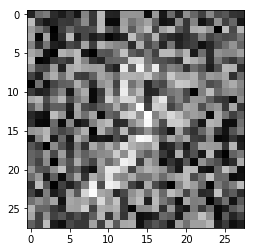

The classification label following attack is 8 from an original classification of 9
The L2 distance of the adversary is 11.957300154013758


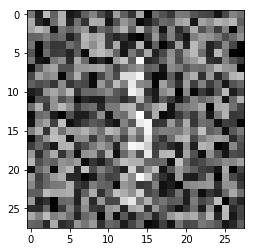

The classification label following attack is 8 from an original classification of 1
The L2 distance of the adversary is 11.787430539062603


In [0]:
adversary_found, adversary_distance, adversary_arrays = evaluate_BlendedUniformNoiseAttack_resistance_CustomModel(
    model_prediction_function=cnn_binding_predictions, model_weights="/Binding_CNN.ckpt", var_list=var_list_Binding,
    num_images_to_attack=num_images_to_attack, temp_batch_size=1)

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
Binding_mean, Binding_var, Binding_std = scipy.stats.bayes_mvs(adversary_distance)

print("The success ratio is " + str(success_ratio))
print("Mean: " + str(Binding_mean))
print("Variance: " + str(Binding_var))
print("Standard deviation: " + str(Binding_std))


The success ratio is 1.0
Mean: Mean(statistic=9.703187010210637, minmax=(9.280362222730336, 10.126011797690937))
Variance: Variance(statistic=4.966886083948747, minmax=(3.76115146906953, 6.4798112065238405))
Standard deviation: Std_dev(statistic=2.2209264752656703, minmax=(1.9393688326539464, 2.5455473294605704))


In [0]:
adversary_found, adversary_distance, adversary_arrays = evaluate_BlendedUniformNoiseAttack_resistance_MadryModel(num_images_to_attack)

The L2 distance of the adversary is 8.131730759854022
The L2 distance of the adversary is 9.163212141445218
The L2 distance of the adversary is 7.746222797572135
The L2 distance of the adversary is 11.183817443029952
The L2 distance of the adversary is 7.712289712833421
The L2 distance of the adversary is 7.8503279280814775
The L2 distance of the adversary is 6.857939108541092
The L2 distance of the adversary is 6.783215399376258
The L2 distance of the adversary is 8.844975573580653
The L2 distance of the adversary is 7.271605656270911
The L2 distance of the adversary is 10.059057010608235
The L2 distance of the adversary is 7.958530224416653
The L2 distance of the adversary is 8.746630060395958
The L2 distance of the adversary is 11.326755399819541
The L2 distance of the adversary is 8.533495007712947
The L2 distance of the adversary is 10.04589392736717
The L2 distance of the adversary is 9.604554696701557
The L2 distance of the adversary is 7.70278876436897
The L2 distance of the ad

In [0]:
success_ratio = np.sum(adversary_found)/num_images_to_attack
Madry_mean, Madry_var, Madry_std = scipy.stats.bayes_mvs(adversary_distance)

print("The success ratio is " + str(success_ratio))
print("Mean: " + str(Madry_mean))
print("Variance: " + str(Madry_var))
print("Standard deviation: " + str(Madry_std))

The success ratio is 1.0
Mean: Mean(statistic=8.73855318361521, minmax=(8.39837518544816, 9.078731181782258))
Variance: Variance(statistic=3.214961402200217, minmax=(2.4345146227460686, 4.1942461676021665))
Standard deviation: Std_dev(statistic=1.7868165367842235, minmax=(1.5602931207776536, 2.0479858807135773))


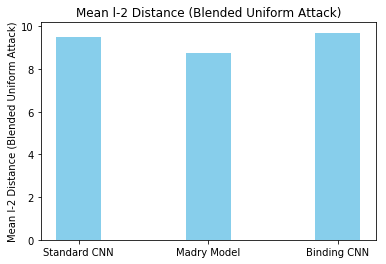

In [0]:
#Results form Blended Uniform attack

model_labels = ('Standard CNN', 'Madry Model', 'Binding CNN')
Blended_distance = np.zeros([1,3])
Blended_distance[0,0] = Standard_mean[0]
Blended_distance[0,1] = Madry_mean[0]
Blended_distance[0,2] = Binding_mean[0]

fig, ax = plt.subplots()
bar_width = 0.35
ax.grid(False)
plt.bar([0, 1, 2], Blended_distance[0,:], bar_width, color='SkyBlue')
plt.xticks([0, 1, 2], model_labels)
plt.ylabel('Mean l-2 Distance (Blended Uniform Attack)')
plt.title('Mean l-2 Distance (Blended Uniform Attack)')
plt.show()

#Visualizaiton of Results

In [0]:
#Overview of the results
#Columns 0:2 correspond to Standard CNN, Madry model, and the binding model respectively
#Rows 0:1 correspond to accuracy against one's own adversarial examples during generation
Boundary_attack_results = np.zeros([2,3])
Boundary_attack_results[0,0] = 1.0 #Standard CNN
Boundary_attack_results[1,0] = 1.591

Boundary_attack_results[0,1] = 1.0 #Madry model
Boundary_attack_results[1,1] = 1.433

Boundary_attack_results[0,2] = 0.24 #Binding model
Boundary_attack_results[1,2] = 8.328


#Columns 0:2 correspond to Standard CNN, Madry model, and the binding model respectively
#Rows 0:2 correspond to performance on adversaries from the Standard CNN, Madry model, and the binding model respectively
Transfer_attack_results = np.zeros([3,3])

Transfer_attack_results[0,0] = 1
Transfer_attack_results[1,0] = 0.333
Transfer_attack_results[2,0] = 0.378

Transfer_attack_results[0,1] = 0.155
Transfer_attack_results[1,1] = 1
Transfer_attack_results[2,1] = 0.267

Transfer_attack_results[0,2] = 0.267
Transfer_attack_results[1,2] = 0.083
Transfer_attack_results[2,2] = 1

Transfer_attack_results = Transfer_attack_results #Normalize the results

model_labels = ('Standard CNN', 'Madry Model', 'Binding CNN')

In [0]:
### *** Boundary attack results with binding net removed

Boundary_attack_results = np.zeros([2,2])
Boundary_attack_results[0,0] = 1.0 #Standard CNN
Boundary_attack_results[1,0] = 1.591

Boundary_attack_results[0,1] = 1.0 #Madry model
Boundary_attack_results[1,1] = 1.433

model_labels = ('Standard CNN', 'Madry Model')

In [0]:
fig, ax = plt.subplots(figsize=(5,5))
bar_width = 0.35
ax.grid(False)
plt.bar([0, 1], Boundary_attack_results[0,:], bar_width, color='IndianRed')
plt.xticks([0, 1], model_labels)
plt.ylabel('Percentage of Adv. Examples Misclassified')
plt.title('Percentage of Adv. Examples Misclassified (Boundary Attack)')
plt.show()

In [0]:
fig, ax = plt.subplots(figsize=(5,5))
bar_width = 0.35
ax.grid(False)
plt.bar([0, 1], Boundary_attack_results[1,:], bar_width, color='SkyBlue')
plt.xticks([0, 1], model_labels)
plt.ylabel('Mean Euclidian Distance for Misclassificaiton')
plt.title('Mean Euclidian Distance for Misclassificaiton (Boundary Attack)')
plt.show()

In [0]:
fig, ax = plt.subplots()
bar_width = 0.5
ax.grid(False)
plt.bar([0, 1, 2], Boundary_attack_results[1,:], bar_width, color='SkyBlue')
plt.xticks([0, 1, 2], model_labels)
plt.ylabel('Mean Euclidian Distance for Misclassificaiton')
plt.title('Mean Euclidian Distance for Misclassificaiton (Boundary Attack)')
plt.show()

In [0]:
n_groups = 3
bar_width = 0.35
#_, ax = plt.subplots()
index = np.arange(n_groups)


plt.figure(figsize=(16,10))
plt.grid(False)
results_Standard_examples = plt.bar(index - bar_width/2, Transfer_attack_results[0,:], bar_width, color='IndianRed', label="Standard Adv. Examples")

results_Madry_examples = plt.bar(index, Transfer_attack_results[1,:], bar_width, label="Madry Adv. Examples")

results_Binding_examples = plt.bar(index + bar_width/2, Transfer_attack_results[2,:], bar_width, color='SkyBlue', label="Binding Adv. Examples")

plt.xticks(index, model_labels)
plt.ylabel('Percentage of Misclassification')
plt.title('Percentage of Misclassification (Transfer Attack)')
plt.legend(loc='upper left', frameon=1)
plt.show()

In [0]:
### mean transfer resistance results


#Columns 0:2 correspond to Standard CNN, Madry model, and the binding model respectively
#Rows 0:2 correspond to performance on adversaries from the Standard CNN, Madry model, and the binding model respectively
Transfer_attack_results = np.zeros([3,3])

Transfer_attack_results[0,0] = 1
Transfer_attack_results[1,0] = 0.333
Transfer_attack_results[2,0] = 0.378

Transfer_attack_results[0,1] = 0.155
Transfer_attack_results[1,1] = 1
Transfer_attack_results[2,1] = 0.267

Transfer_attack_results[0,2] = 0.267
Transfer_attack_results[1,2] = 0.083
Transfer_attack_results[2,2] = 1

Transfer_attack_results = Transfer_attack_results #Normalize the results

model_labels = ('Standard CNN', 'Madry Model', 'Binding CNN')

In [0]:
Transfer_means = np.zeros([1,3])
Transfer_means[0,0] = np.mean(Transfer_attack_results[:,0])
Transfer_means[0,1] = np.mean(Transfer_attack_results[:,1])
Transfer_means[0,2] = np.mean(Transfer_attack_results[:,2])

fig, ax = plt.subplots()
bar_width = 0.35
ax.grid(False)
plt.bar([0, 1, 2], Transfer_means[0,:], bar_width, color='IndianRed')
plt.xticks([0, 1, 2], model_labels)
plt.ylabel('Mean Misclassification (Transfer Attack)')
plt.title('Mean Misclassification (Transfer Attack)')
plt.show()

In [0]:
#Results form Blended Uniform attack

Blended_distance = np.zeros([1,3])
Blended_distance[0,0] = 8.526335774869567
Blended_distance[0,1] = 8.559281853495518
Blended_distance[0,2] = 9.433369523695147

fig, ax = plt.subplots()
bar_width = 0.35
ax.grid(False)
plt.bar([0, 1, 2], Blended_distance[0,:], bar_width, color='SkyBlue')
plt.xticks([0, 1, 2], model_labels)
plt.ylabel('Mean l-2 Distance (Blended Uniform Attack)')
plt.title('Mean l-2 Distance (Blended Uniform Attack)')
plt.show()